<div align=center>

<font size=5>
    In the Name of God
<font/>
<br/>
<br/>
<font>
    Sharif University of Technology - Departmenet of Electrical Engineering
</font>
<br/>
<font>
    Introducing with Machine Learing - Dr. S. Amini
</font>
<br/>
<br/>
Spring 2023

</div>

<hr/>
<div align=center>
<font size=6>
    Neural Networks Practical Assignment
    
    Question 1
</font>
<br/>		
<font size=4>
<br/>
</div>

# Personal Data

In [119]:
# Set your student number
student_number = 98109815
Name = 'Amirmohammad'
Last_Name = 'Marshalpirgheybi'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch. 

In [120]:
!pip install numpy
!pip install matplotlib
!pip install torchvision
!pip install torch

## Importing Libraries

In [121]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict
import torch.optim as optim

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [122]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

In [123]:
image_shape = train_set[0][0].shape
input_dim = np.prod(image_shape).item()
num_classes = len(FashionMNIST.classes)

In [124]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class

- **Hint**:  You can use `plt.subplots` for visualization

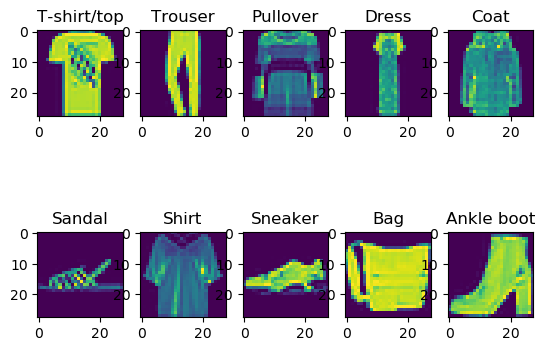

In [125]:
## FILL HERE
data = train_set.data
targets = train_set.targets
plt.figure()
for i in range(num_classes):
    class_data = data[targets == i,:,:]
    random_idx = np.random.choice(class_data.shape[0],1)
    plt.subplot(2,5,i+1)
    plt.imshow(class_data[random_idx,:,:].reshape(class_data.shape[1],class_data.shape[2]))
    title = train_set.classes[i]
    plt.title(title)

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [126]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [127]:
import gc
torch.cuda.empty_cache() 
gc.collect()
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)


## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [156]:
def affine_forward(x, w, b):
    ## FILL HERE
    return x @ w+b

def relu(x):
    ## FILL HERE
    return (torch.abs(x)+x)/2

Function `model` returns output of the whole model for the input `x` using the parameters:

In [155]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)
    ## FILL HERE
    for i in range(num_layers):
        
        x = affine_forward(x,parameters[f'w{i}'],parameters[f'b{i}'])
        if(i < num_layers-1):
            x = relu(x)
    output = x
    return output

Implementing cross entropy loss:

In [130]:
def cross_entropy_loss(scores, y):
    n = len(y)
    ## FILL HERE
    pred = scores.exp() / (scores.exp().sum(-1)).unsqueeze(-1)
    loss = -pred[range(y.shape[0]), y].log().mean()
    return loss
    

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [131]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    torch.cuda.empty_cache()
    '''This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient (parameter.grad). Finally, you should zero the gradients of the parameters after updating
    the parameter value.'''
    ## FILL HERE
    for p in parameters:
        new = parameters[p]
        with torch.no_grad():
            new -= learning_rate * new.grad
        new.grad.zero_()
        parameters.update({p: new})

Training functions:

In [151]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    ## FILL HERE
    acc = (y_pred == y_true).sum(axis = 0)/len(y_pred)
    return acc

def train(train_loader,learning_rate=0.001, epoch=None):
    '''This function implements the training loop for a single epoch. For each batch you should do the following:
        1- Calculate the output of the model to the given input batch
        2- Calculate the loss based on the model output
        3- Update the gradients using loss.backward() method
        4- Optimize the model parameters using the sgd_optimizer function defined previously
        5- Print the train loss (Show the epoch and batch as well)
        '''
    train_loss = 0
    N_train = len(train_loader.dataset)
    
    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)
        del x

        ## FILL HERE
        loss = cross_entropy_loss(p,y)
        loss.backward()
        sgd_optimizer(parameters,learning_rate)
        
        print(f'Loss of train set: {loss} at epoch: {epoch} and batch_num: {i}')
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
        train_loss += loss.item()/N_train
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of train set: {acc}')
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch
    
    Finally the function calculates the model accuracy.'''
    total_loss = 0
    N = len(loader.dataset)
    
    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    for i, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        ## FILL HERE
        loss = cross_entropy_loss(p,y)
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
        print(f'Loss of test set: {loss} at epoch: {epoch} and batch_num: {i}')
        total_loss += loss.item()
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    total_loss /= N
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    return total_loss, acc

In [152]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [153]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders
    
    for epoch in range(num_epochs):
        ## FILL HERE
        ## You should calculate the train and test loss and accuracies for each epoch and add them to
        ## the lists `train_losses`, `test_losses`, `train_accuracies` and `test_accuracies`
        train_loss, train_acc = train(train_loader, learning_rate, epoch)
        test_loss, test_acc = validate(test_loader, epoch, set_name='FashionMNIST')
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
    ## plot the loss history of training and test sets 
    ## FILL HERE
    plt.figure()
    plt.plot(train_losses)
    plt.plot(test_losses)
    plt.grid()
    plt.legend(["Train","Test"])
    plt.title("Loss VS Iteration")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    

    ## plot the accuracy history of training and test sets
    ## FILL HERE
    plt.figure()
    plt.plot(train_accuracies)
    plt.plot(test_accuracies)
    plt.grid()
    plt.legend(["Train","Test"])
    plt.title("Accuracy VS Iteration")
    plt.xlabel("#iteration")
    plt.ylabel("loss")

Loss of train set: 0.23684629797935486 at epoch: 0 and batch_num: 0
Loss of train set: 0.34154099225997925 at epoch: 0 and batch_num: 1
Loss of train set: 0.38155078887939453 at epoch: 0 and batch_num: 2
Loss of train set: 0.5982749462127686 at epoch: 0 and batch_num: 3
Loss of train set: 0.22734199464321136 at epoch: 0 and batch_num: 4
Loss of train set: 0.30521678924560547 at epoch: 0 and batch_num: 5
Loss of train set: 0.31141021847724915 at epoch: 0 and batch_num: 6
Loss of train set: 0.4261656701564789 at epoch: 0 and batch_num: 7
Loss of train set: 0.3480401337146759 at epoch: 0 and batch_num: 8
Loss of train set: 0.2765907645225525 at epoch: 0 and batch_num: 9
Loss of train set: 0.1956864893436432 at epoch: 0 and batch_num: 10
Loss of train set: 0.3707488775253296 at epoch: 0 and batch_num: 11
Loss of train set: 0.501805305480957 at epoch: 0 and batch_num: 12
Loss of train set: 0.32864975929260254 at epoch: 0 and batch_num: 13
Loss of train set: 0.394482284784317 at epoch: 0 and

Loss of train set: 0.32154372334480286 at epoch: 0 and batch_num: 125
Loss of train set: 0.33914077281951904 at epoch: 0 and batch_num: 126
Loss of train set: 0.5132722854614258 at epoch: 0 and batch_num: 127
Loss of train set: 0.25594258308410645 at epoch: 0 and batch_num: 128
Loss of train set: 0.5964510440826416 at epoch: 0 and batch_num: 129
Loss of train set: 0.3360803425312042 at epoch: 0 and batch_num: 130
Loss of train set: 0.5301743745803833 at epoch: 0 and batch_num: 131
Loss of train set: 0.525313138961792 at epoch: 0 and batch_num: 132
Loss of train set: 0.4906216859817505 at epoch: 0 and batch_num: 133
Loss of train set: 0.5831438302993774 at epoch: 0 and batch_num: 134
Loss of train set: 0.3179851770401001 at epoch: 0 and batch_num: 135
Loss of train set: 0.24308940768241882 at epoch: 0 and batch_num: 136
Loss of train set: 0.30702394247055054 at epoch: 0 and batch_num: 137
Loss of train set: 0.46001702547073364 at epoch: 0 and batch_num: 138
Loss of train set: 0.41512399

Loss of train set: 0.7013425230979919 at epoch: 0 and batch_num: 251
Loss of train set: 0.22862622141838074 at epoch: 0 and batch_num: 252
Loss of train set: 0.4040961265563965 at epoch: 0 and batch_num: 253
Loss of train set: 0.22281140089035034 at epoch: 0 and batch_num: 254
Loss of train set: 0.2657378315925598 at epoch: 0 and batch_num: 255
Loss of train set: 0.711071789264679 at epoch: 0 and batch_num: 256
Loss of train set: 0.3382020592689514 at epoch: 0 and batch_num: 257
Loss of train set: 0.39246630668640137 at epoch: 0 and batch_num: 258
Loss of train set: 0.20642030239105225 at epoch: 0 and batch_num: 259
Loss of train set: 0.4002939462661743 at epoch: 0 and batch_num: 260
Loss of train set: 0.3465844988822937 at epoch: 0 and batch_num: 261
Loss of train set: 0.35452738404273987 at epoch: 0 and batch_num: 262
Loss of train set: 0.3618354797363281 at epoch: 0 and batch_num: 263
Loss of train set: 0.4109650254249573 at epoch: 0 and batch_num: 264
Loss of train set: 0.233501568

Loss of train set: 0.4293748736381531 at epoch: 0 and batch_num: 370
Loss of train set: 0.30681705474853516 at epoch: 0 and batch_num: 371
Loss of train set: 0.3165408968925476 at epoch: 0 and batch_num: 372
Loss of train set: 0.2413996160030365 at epoch: 0 and batch_num: 373
Loss of train set: 0.5736427903175354 at epoch: 0 and batch_num: 374
Loss of train set: 0.41641366481781006 at epoch: 0 and batch_num: 375
Loss of train set: 0.43236368894577026 at epoch: 0 and batch_num: 376
Loss of train set: 0.3901330828666687 at epoch: 0 and batch_num: 377
Loss of train set: 0.4189893901348114 at epoch: 0 and batch_num: 378
Loss of train set: 0.45793092250823975 at epoch: 0 and batch_num: 379
Loss of train set: 0.2322806864976883 at epoch: 0 and batch_num: 380
Loss of train set: 0.356760710477829 at epoch: 0 and batch_num: 381
Loss of train set: 0.2587815523147583 at epoch: 0 and batch_num: 382
Loss of train set: 0.3672368824481964 at epoch: 0 and batch_num: 383
Loss of train set: 0.3007408380

Loss of train set: 0.39410775899887085 at epoch: 0 and batch_num: 501
Loss of train set: 0.42626428604125977 at epoch: 0 and batch_num: 502
Loss of train set: 0.31831395626068115 at epoch: 0 and batch_num: 503
Loss of train set: 0.5429269671440125 at epoch: 0 and batch_num: 504
Loss of train set: 0.47803419828414917 at epoch: 0 and batch_num: 505
Loss of train set: 0.4239692687988281 at epoch: 0 and batch_num: 506
Loss of train set: 0.38657742738723755 at epoch: 0 and batch_num: 507
Loss of train set: 0.27424895763397217 at epoch: 0 and batch_num: 508
Loss of train set: 0.5735201835632324 at epoch: 0 and batch_num: 509
Loss of train set: 0.6509040594100952 at epoch: 0 and batch_num: 510
Loss of train set: 0.5490021705627441 at epoch: 0 and batch_num: 511
Loss of train set: 0.23069101572036743 at epoch: 0 and batch_num: 512
Loss of train set: 0.2676221430301666 at epoch: 0 and batch_num: 513
Loss of train set: 0.3766956925392151 at epoch: 0 and batch_num: 514
Loss of train set: 0.319555

Loss of train set: 0.33376452326774597 at epoch: 0 and batch_num: 635
Loss of train set: 0.38349321484565735 at epoch: 0 and batch_num: 636
Loss of train set: 0.507037878036499 at epoch: 0 and batch_num: 637
Loss of train set: 0.6931674480438232 at epoch: 0 and batch_num: 638
Loss of train set: 0.370506227016449 at epoch: 0 and batch_num: 639
Loss of train set: 0.28609544038772583 at epoch: 0 and batch_num: 640
Loss of train set: 0.3822576105594635 at epoch: 0 and batch_num: 641
Loss of train set: 0.19011306762695312 at epoch: 0 and batch_num: 642
Loss of train set: 0.23292607069015503 at epoch: 0 and batch_num: 643
Loss of train set: 0.3433769941329956 at epoch: 0 and batch_num: 644
Loss of train set: 0.2655166983604431 at epoch: 0 and batch_num: 645
Loss of train set: 0.5559884309768677 at epoch: 0 and batch_num: 646
Loss of train set: 0.28695857524871826 at epoch: 0 and batch_num: 647
Loss of train set: 0.37560540437698364 at epoch: 0 and batch_num: 648
Loss of train set: 0.43450576

Loss of train set: 0.3399146795272827 at epoch: 0 and batch_num: 773
Loss of train set: 0.3275381028652191 at epoch: 0 and batch_num: 774
Loss of train set: 0.41566264629364014 at epoch: 0 and batch_num: 775
Loss of train set: 0.29501309990882874 at epoch: 0 and batch_num: 776
Loss of train set: 0.46446162462234497 at epoch: 0 and batch_num: 777
Loss of train set: 0.30979636311531067 at epoch: 0 and batch_num: 778
Loss of train set: 0.2963276505470276 at epoch: 0 and batch_num: 779
Loss of train set: 0.2753964364528656 at epoch: 0 and batch_num: 780
Loss of train set: 0.7420386075973511 at epoch: 0 and batch_num: 781
Loss of train set: 0.22282949090003967 at epoch: 0 and batch_num: 782
Loss of train set: 0.34051620960235596 at epoch: 0 and batch_num: 783
Loss of train set: 0.4855588972568512 at epoch: 0 and batch_num: 784
Loss of train set: 0.41189417243003845 at epoch: 0 and batch_num: 785
Loss of train set: 0.36117637157440186 at epoch: 0 and batch_num: 786
Loss of train set: 0.37699

Loss of train set: 0.415225625038147 at epoch: 0 and batch_num: 910
Loss of train set: 0.37174880504608154 at epoch: 0 and batch_num: 911
Loss of train set: 0.3559023439884186 at epoch: 0 and batch_num: 912
Loss of train set: 0.35702306032180786 at epoch: 0 and batch_num: 913
Loss of train set: 0.35807785391807556 at epoch: 0 and batch_num: 914
Loss of train set: 0.4248388111591339 at epoch: 0 and batch_num: 915
Loss of train set: 0.34579408168792725 at epoch: 0 and batch_num: 916
Loss of train set: 0.43540486693382263 at epoch: 0 and batch_num: 917
Loss of train set: 0.33084195852279663 at epoch: 0 and batch_num: 918
Loss of train set: 0.3291042745113373 at epoch: 0 and batch_num: 919
Loss of train set: 0.3111221492290497 at epoch: 0 and batch_num: 920
Loss of train set: 0.28372102975845337 at epoch: 0 and batch_num: 921
Loss of train set: 0.36876025795936584 at epoch: 0 and batch_num: 922
Loss of train set: 0.6022666692733765 at epoch: 0 and batch_num: 923
Loss of train set: 0.185134

Loss of test set: 0.46167612075805664 at epoch: 0 and batch_num: 98
Loss of test set: 0.4520862102508545 at epoch: 0 and batch_num: 99
Loss of test set: 0.3219566345214844 at epoch: 0 and batch_num: 100
Loss of test set: 0.5382290482521057 at epoch: 0 and batch_num: 101
Loss of test set: 0.5521970391273499 at epoch: 0 and batch_num: 102
Loss of test set: 0.4601646363735199 at epoch: 0 and batch_num: 103
Loss of test set: 0.25799795985221863 at epoch: 0 and batch_num: 104
Loss of test set: 0.45640501379966736 at epoch: 0 and batch_num: 105
Loss of test set: 0.25931137800216675 at epoch: 0 and batch_num: 106
Loss of test set: 0.4268757104873657 at epoch: 0 and batch_num: 107
Loss of test set: 0.33202579617500305 at epoch: 0 and batch_num: 108
Loss of test set: 0.5083356499671936 at epoch: 0 and batch_num: 109
Loss of test set: 0.7721631526947021 at epoch: 0 and batch_num: 110
Loss of test set: 0.4207928776741028 at epoch: 0 and batch_num: 111
Loss of test set: 0.4700452387332916 at epoch

Loss of train set: 0.350083589553833 at epoch: 1 and batch_num: 78
Loss of train set: 0.47792738676071167 at epoch: 1 and batch_num: 79
Loss of train set: 0.3940805196762085 at epoch: 1 and batch_num: 80
Loss of train set: 0.29568904638290405 at epoch: 1 and batch_num: 81
Loss of train set: 0.45258066058158875 at epoch: 1 and batch_num: 82
Loss of train set: 0.2434501051902771 at epoch: 1 and batch_num: 83
Loss of train set: 0.41878658533096313 at epoch: 1 and batch_num: 84
Loss of train set: 0.3370389938354492 at epoch: 1 and batch_num: 85
Loss of train set: 0.36273080110549927 at epoch: 1 and batch_num: 86
Loss of train set: 0.4451390504837036 at epoch: 1 and batch_num: 87
Loss of train set: 0.42934465408325195 at epoch: 1 and batch_num: 88
Loss of train set: 0.46310022473335266 at epoch: 1 and batch_num: 89
Loss of train set: 0.31179800629615784 at epoch: 1 and batch_num: 90
Loss of train set: 0.36664095520973206 at epoch: 1 and batch_num: 91
Loss of train set: 0.3133951425552368 at

Loss of train set: 0.2194800078868866 at epoch: 1 and batch_num: 203
Loss of train set: 0.3928673267364502 at epoch: 1 and batch_num: 204
Loss of train set: 0.41501450538635254 at epoch: 1 and batch_num: 205
Loss of train set: 0.2601366639137268 at epoch: 1 and batch_num: 206
Loss of train set: 0.4095039963722229 at epoch: 1 and batch_num: 207
Loss of train set: 0.40781229734420776 at epoch: 1 and batch_num: 208
Loss of train set: 0.3235400915145874 at epoch: 1 and batch_num: 209
Loss of train set: 0.40283650159835815 at epoch: 1 and batch_num: 210
Loss of train set: 0.28695571422576904 at epoch: 1 and batch_num: 211
Loss of train set: 0.3593689203262329 at epoch: 1 and batch_num: 212
Loss of train set: 0.37625330686569214 at epoch: 1 and batch_num: 213
Loss of train set: 0.35065963864326477 at epoch: 1 and batch_num: 214
Loss of train set: 0.26796969771385193 at epoch: 1 and batch_num: 215
Loss of train set: 0.4872586727142334 at epoch: 1 and batch_num: 216
Loss of train set: 0.334761

Loss of train set: 0.2844749689102173 at epoch: 1 and batch_num: 325
Loss of train set: 0.5336766242980957 at epoch: 1 and batch_num: 326
Loss of train set: 0.36674216389656067 at epoch: 1 and batch_num: 327
Loss of train set: 0.6216031908988953 at epoch: 1 and batch_num: 328
Loss of train set: 0.4845908284187317 at epoch: 1 and batch_num: 329
Loss of train set: 0.36342427134513855 at epoch: 1 and batch_num: 330
Loss of train set: 0.5148757100105286 at epoch: 1 and batch_num: 331
Loss of train set: 0.2349933534860611 at epoch: 1 and batch_num: 332
Loss of train set: 0.23643049597740173 at epoch: 1 and batch_num: 333
Loss of train set: 0.35072797536849976 at epoch: 1 and batch_num: 334
Loss of train set: 0.4258663058280945 at epoch: 1 and batch_num: 335
Loss of train set: 0.3106231391429901 at epoch: 1 and batch_num: 336
Loss of train set: 0.3365819454193115 at epoch: 1 and batch_num: 337
Loss of train set: 0.23307140171527863 at epoch: 1 and batch_num: 338
Loss of train set: 0.33330178

Loss of train set: 0.29725807905197144 at epoch: 1 and batch_num: 445
Loss of train set: 0.27685481309890747 at epoch: 1 and batch_num: 446
Loss of train set: 0.3462672531604767 at epoch: 1 and batch_num: 447
Loss of train set: 0.3824814260005951 at epoch: 1 and batch_num: 448
Loss of train set: 0.23786331713199615 at epoch: 1 and batch_num: 449
Loss of train set: 0.3193095326423645 at epoch: 1 and batch_num: 450
Loss of train set: 0.25091272592544556 at epoch: 1 and batch_num: 451
Loss of train set: 0.43892163038253784 at epoch: 1 and batch_num: 452
Loss of train set: 0.34164535999298096 at epoch: 1 and batch_num: 453
Loss of train set: 0.4243552088737488 at epoch: 1 and batch_num: 454
Loss of train set: 0.22508439421653748 at epoch: 1 and batch_num: 455
Loss of train set: 0.20243695378303528 at epoch: 1 and batch_num: 456
Loss of train set: 0.4666583240032196 at epoch: 1 and batch_num: 457
Loss of train set: 0.19325712323188782 at epoch: 1 and batch_num: 458
Loss of train set: 0.4491

Loss of train set: 0.3242982029914856 at epoch: 1 and batch_num: 579
Loss of train set: 0.3924444317817688 at epoch: 1 and batch_num: 580
Loss of train set: 0.27829235792160034 at epoch: 1 and batch_num: 581
Loss of train set: 0.38563117384910583 at epoch: 1 and batch_num: 582
Loss of train set: 0.3260478675365448 at epoch: 1 and batch_num: 583
Loss of train set: 0.42292019724845886 at epoch: 1 and batch_num: 584
Loss of train set: 0.4260767698287964 at epoch: 1 and batch_num: 585
Loss of train set: 0.5511505603790283 at epoch: 1 and batch_num: 586
Loss of train set: 0.3251630961894989 at epoch: 1 and batch_num: 587
Loss of train set: 0.5584235191345215 at epoch: 1 and batch_num: 588
Loss of train set: 0.3553968369960785 at epoch: 1 and batch_num: 589
Loss of train set: 0.4415556490421295 at epoch: 1 and batch_num: 590
Loss of train set: 0.6062453985214233 at epoch: 1 and batch_num: 591
Loss of train set: 0.31553876399993896 at epoch: 1 and batch_num: 592
Loss of train set: 0.470901966

Loss of train set: 0.26556575298309326 at epoch: 1 and batch_num: 710
Loss of train set: 0.3086255192756653 at epoch: 1 and batch_num: 711
Loss of train set: 0.44281136989593506 at epoch: 1 and batch_num: 712
Loss of train set: 0.48453718423843384 at epoch: 1 and batch_num: 713
Loss of train set: 0.3010103702545166 at epoch: 1 and batch_num: 714
Loss of train set: 0.5719151496887207 at epoch: 1 and batch_num: 715
Loss of train set: 0.578802227973938 at epoch: 1 and batch_num: 716
Loss of train set: 0.21490171551704407 at epoch: 1 and batch_num: 717
Loss of train set: 0.38559070229530334 at epoch: 1 and batch_num: 718
Loss of train set: 0.33568596839904785 at epoch: 1 and batch_num: 719
Loss of train set: 0.2924855351448059 at epoch: 1 and batch_num: 720
Loss of train set: 0.35746780037879944 at epoch: 1 and batch_num: 721
Loss of train set: 0.40829557180404663 at epoch: 1 and batch_num: 722
Loss of train set: 0.39083409309387207 at epoch: 1 and batch_num: 723
Loss of train set: 0.36823

Loss of train set: 0.33890414237976074 at epoch: 1 and batch_num: 830
Loss of train set: 0.2555154860019684 at epoch: 1 and batch_num: 831
Loss of train set: 0.5110238790512085 at epoch: 1 and batch_num: 832
Loss of train set: 0.41295063495635986 at epoch: 1 and batch_num: 833
Loss of train set: 0.23925158381462097 at epoch: 1 and batch_num: 834
Loss of train set: 0.32336196303367615 at epoch: 1 and batch_num: 835
Loss of train set: 0.542203426361084 at epoch: 1 and batch_num: 836
Loss of train set: 0.2961232662200928 at epoch: 1 and batch_num: 837
Loss of train set: 0.36730051040649414 at epoch: 1 and batch_num: 838
Loss of train set: 0.28214067220687866 at epoch: 1 and batch_num: 839
Loss of train set: 0.5393984317779541 at epoch: 1 and batch_num: 840
Loss of train set: 0.3409457206726074 at epoch: 1 and batch_num: 841
Loss of train set: 0.29511094093322754 at epoch: 1 and batch_num: 842
Loss of train set: 0.3624495565891266 at epoch: 1 and batch_num: 843
Loss of train set: 0.4908881

Loss of test set: 0.4613851308822632 at epoch: 1 and batch_num: 17
Loss of test set: 0.3347603678703308 at epoch: 1 and batch_num: 18
Loss of test set: 0.6339390277862549 at epoch: 1 and batch_num: 19
Loss of test set: 0.3793758153915405 at epoch: 1 and batch_num: 20
Loss of test set: 0.40524420142173767 at epoch: 1 and batch_num: 21
Loss of test set: 0.2720924913883209 at epoch: 1 and batch_num: 22
Loss of test set: 0.40952423214912415 at epoch: 1 and batch_num: 23
Loss of test set: 0.28766727447509766 at epoch: 1 and batch_num: 24
Loss of test set: 0.5941420793533325 at epoch: 1 and batch_num: 25
Loss of test set: 0.3178987205028534 at epoch: 1 and batch_num: 26
Loss of test set: 0.4208369553089142 at epoch: 1 and batch_num: 27
Loss of test set: 0.23791161179542542 at epoch: 1 and batch_num: 28
Loss of test set: 0.42967158555984497 at epoch: 1 and batch_num: 29
Loss of test set: 0.3260662257671356 at epoch: 1 and batch_num: 30
Loss of test set: 0.42729565501213074 at epoch: 1 and bat

Loss of test set: 0.5269691944122314 at epoch: 1 and batch_num: 149
Loss of test set: 0.32767218351364136 at epoch: 1 and batch_num: 150
Loss of test set: 0.224827378988266 at epoch: 1 and batch_num: 151
Loss of test set: 0.40513718128204346 at epoch: 1 and batch_num: 152
Loss of test set: 0.42385420203208923 at epoch: 1 and batch_num: 153
Loss of test set: 0.5091288089752197 at epoch: 1 and batch_num: 154
Loss of test set: 0.5182786583900452 at epoch: 1 and batch_num: 155
Loss of test set: 0.7919517755508423 at epoch: 1 and batch_num: 156
Accuracy of FashionMNIST set: 0.8519
Loss of train set: 0.2594914734363556 at epoch: 2 and batch_num: 0
Loss of train set: 0.3920285403728485 at epoch: 2 and batch_num: 1
Loss of train set: 0.4676814675331116 at epoch: 2 and batch_num: 2
Loss of train set: 0.35826852917671204 at epoch: 2 and batch_num: 3
Loss of train set: 0.4283817708492279 at epoch: 2 and batch_num: 4
Loss of train set: 0.38054803013801575 at epoch: 2 and batch_num: 5
Loss of train

Loss of train set: 0.44387948513031006 at epoch: 2 and batch_num: 125
Loss of train set: 0.2468045949935913 at epoch: 2 and batch_num: 126
Loss of train set: 0.4844149947166443 at epoch: 2 and batch_num: 127
Loss of train set: 0.5031107068061829 at epoch: 2 and batch_num: 128
Loss of train set: 0.45078417658805847 at epoch: 2 and batch_num: 129
Loss of train set: 0.3526938855648041 at epoch: 2 and batch_num: 130
Loss of train set: 0.27499687671661377 at epoch: 2 and batch_num: 131
Loss of train set: 0.21639776229858398 at epoch: 2 and batch_num: 132
Loss of train set: 0.35455799102783203 at epoch: 2 and batch_num: 133
Loss of train set: 0.27836301922798157 at epoch: 2 and batch_num: 134
Loss of train set: 0.4017488658428192 at epoch: 2 and batch_num: 135
Loss of train set: 0.29326844215393066 at epoch: 2 and batch_num: 136
Loss of train set: 0.4871397912502289 at epoch: 2 and batch_num: 137
Loss of train set: 0.4466438293457031 at epoch: 2 and batch_num: 138
Loss of train set: 0.199661

Loss of train set: 0.32186996936798096 at epoch: 2 and batch_num: 247
Loss of train set: 0.2893880605697632 at epoch: 2 and batch_num: 248
Loss of train set: 0.29742351174354553 at epoch: 2 and batch_num: 249
Loss of train set: 0.2325161248445511 at epoch: 2 and batch_num: 250
Loss of train set: 0.46663814783096313 at epoch: 2 and batch_num: 251
Loss of train set: 0.42820122838020325 at epoch: 2 and batch_num: 252
Loss of train set: 0.4024653136730194 at epoch: 2 and batch_num: 253
Loss of train set: 0.3909338712692261 at epoch: 2 and batch_num: 254
Loss of train set: 0.41132915019989014 at epoch: 2 and batch_num: 255
Loss of train set: 0.40913325548171997 at epoch: 2 and batch_num: 256
Loss of train set: 0.465553343296051 at epoch: 2 and batch_num: 257
Loss of train set: 0.41237297654151917 at epoch: 2 and batch_num: 258
Loss of train set: 0.34835565090179443 at epoch: 2 and batch_num: 259
Loss of train set: 0.3346342146396637 at epoch: 2 and batch_num: 260
Loss of train set: 0.204965

Loss of train set: 0.40669313073158264 at epoch: 2 and batch_num: 370
Loss of train set: 0.43974408507347107 at epoch: 2 and batch_num: 371
Loss of train set: 0.44485968351364136 at epoch: 2 and batch_num: 372
Loss of train set: 0.3453119993209839 at epoch: 2 and batch_num: 373
Loss of train set: 0.26810967922210693 at epoch: 2 and batch_num: 374
Loss of train set: 0.41543900966644287 at epoch: 2 and batch_num: 375
Loss of train set: 0.3931903541088104 at epoch: 2 and batch_num: 376
Loss of train set: 0.3159489631652832 at epoch: 2 and batch_num: 377
Loss of train set: 0.31426405906677246 at epoch: 2 and batch_num: 378
Loss of train set: 0.3848831355571747 at epoch: 2 and batch_num: 379
Loss of train set: 0.26700323820114136 at epoch: 2 and batch_num: 380
Loss of train set: 0.2672433853149414 at epoch: 2 and batch_num: 381
Loss of train set: 0.3421512246131897 at epoch: 2 and batch_num: 382
Loss of train set: 0.6306793689727783 at epoch: 2 and batch_num: 383
Loss of train set: 0.318066

Loss of train set: 0.21772639453411102 at epoch: 2 and batch_num: 494
Loss of train set: 0.29997745156288147 at epoch: 2 and batch_num: 495
Loss of train set: 0.2343507558107376 at epoch: 2 and batch_num: 496
Loss of train set: 0.31430017948150635 at epoch: 2 and batch_num: 497
Loss of train set: 0.44655078649520874 at epoch: 2 and batch_num: 498
Loss of train set: 0.29890817403793335 at epoch: 2 and batch_num: 499
Loss of train set: 0.31196489930152893 at epoch: 2 and batch_num: 500
Loss of train set: 0.25875324010849 at epoch: 2 and batch_num: 501
Loss of train set: 0.4387657046318054 at epoch: 2 and batch_num: 502
Loss of train set: 0.21789714694023132 at epoch: 2 and batch_num: 503
Loss of train set: 0.3863503336906433 at epoch: 2 and batch_num: 504
Loss of train set: 0.3710055947303772 at epoch: 2 and batch_num: 505
Loss of train set: 0.28372424840927124 at epoch: 2 and batch_num: 506
Loss of train set: 0.25108802318573 at epoch: 2 and batch_num: 507
Loss of train set: 0.465212285

Loss of train set: 0.4305481016635895 at epoch: 2 and batch_num: 620
Loss of train set: 0.21755072474479675 at epoch: 2 and batch_num: 621
Loss of train set: 0.30302780866622925 at epoch: 2 and batch_num: 622
Loss of train set: 0.2729795575141907 at epoch: 2 and batch_num: 623
Loss of train set: 0.25775888562202454 at epoch: 2 and batch_num: 624
Loss of train set: 0.3749161660671234 at epoch: 2 and batch_num: 625
Loss of train set: 0.39281851053237915 at epoch: 2 and batch_num: 626
Loss of train set: 0.2920130491256714 at epoch: 2 and batch_num: 627
Loss of train set: 0.41537588834762573 at epoch: 2 and batch_num: 628
Loss of train set: 0.46259933710098267 at epoch: 2 and batch_num: 629
Loss of train set: 0.4907442331314087 at epoch: 2 and batch_num: 630
Loss of train set: 0.3882972300052643 at epoch: 2 and batch_num: 631
Loss of train set: 0.4343458116054535 at epoch: 2 and batch_num: 632
Loss of train set: 0.32555508613586426 at epoch: 2 and batch_num: 633
Loss of train set: 0.217533

Loss of train set: 0.2931292653083801 at epoch: 2 and batch_num: 746
Loss of train set: 0.30626147985458374 at epoch: 2 and batch_num: 747
Loss of train set: 0.3972514271736145 at epoch: 2 and batch_num: 748
Loss of train set: 0.4636181890964508 at epoch: 2 and batch_num: 749
Loss of train set: 0.30363646149635315 at epoch: 2 and batch_num: 750
Loss of train set: 0.4022686779499054 at epoch: 2 and batch_num: 751
Loss of train set: 0.4310694932937622 at epoch: 2 and batch_num: 752
Loss of train set: 0.2781248092651367 at epoch: 2 and batch_num: 753
Loss of train set: 0.4495573043823242 at epoch: 2 and batch_num: 754
Loss of train set: 0.4995322525501251 at epoch: 2 and batch_num: 755
Loss of train set: 0.24864289164543152 at epoch: 2 and batch_num: 756
Loss of train set: 0.5050042271614075 at epoch: 2 and batch_num: 757
Loss of train set: 0.5501735210418701 at epoch: 2 and batch_num: 758
Loss of train set: 0.3409837782382965 at epoch: 2 and batch_num: 759
Loss of train set: 0.3894101977

Loss of train set: 0.25223568081855774 at epoch: 2 and batch_num: 866
Loss of train set: 0.4905925393104553 at epoch: 2 and batch_num: 867
Loss of train set: 0.3699924349784851 at epoch: 2 and batch_num: 868
Loss of train set: 0.2758708596229553 at epoch: 2 and batch_num: 869
Loss of train set: 0.42891839146614075 at epoch: 2 and batch_num: 870
Loss of train set: 0.3891327977180481 at epoch: 2 and batch_num: 871
Loss of train set: 0.36850959062576294 at epoch: 2 and batch_num: 872
Loss of train set: 0.592562735080719 at epoch: 2 and batch_num: 873
Loss of train set: 0.3886052668094635 at epoch: 2 and batch_num: 874
Loss of train set: 0.3593737483024597 at epoch: 2 and batch_num: 875
Loss of train set: 0.5642231702804565 at epoch: 2 and batch_num: 876
Loss of train set: 0.5907999277114868 at epoch: 2 and batch_num: 877
Loss of train set: 0.30039799213409424 at epoch: 2 and batch_num: 878
Loss of train set: 0.34299176931381226 at epoch: 2 and batch_num: 879
Loss of train set: 0.336384415

Loss of test set: 0.3804761469364166 at epoch: 2 and batch_num: 63
Loss of test set: 0.4637799859046936 at epoch: 2 and batch_num: 64
Loss of test set: 0.4055601954460144 at epoch: 2 and batch_num: 65
Loss of test set: 0.3964419662952423 at epoch: 2 and batch_num: 66
Loss of test set: 0.3676512837409973 at epoch: 2 and batch_num: 67
Loss of test set: 0.3583683967590332 at epoch: 2 and batch_num: 68
Loss of test set: 0.5128660202026367 at epoch: 2 and batch_num: 69
Loss of test set: 0.32388585805892944 at epoch: 2 and batch_num: 70
Loss of test set: 0.49348169565200806 at epoch: 2 and batch_num: 71
Loss of test set: 0.3155672252178192 at epoch: 2 and batch_num: 72
Loss of test set: 0.28992825746536255 at epoch: 2 and batch_num: 73
Loss of test set: 0.49606001377105713 at epoch: 2 and batch_num: 74
Loss of test set: 0.43314486742019653 at epoch: 2 and batch_num: 75
Loss of test set: 0.4554835259914398 at epoch: 2 and batch_num: 76
Loss of test set: 0.5158458948135376 at epoch: 2 and batc

Loss of train set: 0.47403115034103394 at epoch: 3 and batch_num: 30
Loss of train set: 0.2418273538351059 at epoch: 3 and batch_num: 31
Loss of train set: 0.42834562063217163 at epoch: 3 and batch_num: 32
Loss of train set: 0.45934396982192993 at epoch: 3 and batch_num: 33
Loss of train set: 0.24437546730041504 at epoch: 3 and batch_num: 34
Loss of train set: 0.40084195137023926 at epoch: 3 and batch_num: 35
Loss of train set: 0.37992995977401733 at epoch: 3 and batch_num: 36
Loss of train set: 0.5151453018188477 at epoch: 3 and batch_num: 37
Loss of train set: 0.35357046127319336 at epoch: 3 and batch_num: 38
Loss of train set: 0.4476476311683655 at epoch: 3 and batch_num: 39
Loss of train set: 0.35907575488090515 at epoch: 3 and batch_num: 40
Loss of train set: 0.34820684790611267 at epoch: 3 and batch_num: 41
Loss of train set: 0.4008493423461914 at epoch: 3 and batch_num: 42
Loss of train set: 0.40929514169692993 at epoch: 3 and batch_num: 43
Loss of train set: 0.3234340250492096 

Loss of train set: 0.3854299783706665 at epoch: 3 and batch_num: 150
Loss of train set: 0.2797486186027527 at epoch: 3 and batch_num: 151
Loss of train set: 0.4167001247406006 at epoch: 3 and batch_num: 152
Loss of train set: 0.5700344443321228 at epoch: 3 and batch_num: 153
Loss of train set: 0.47594666481018066 at epoch: 3 and batch_num: 154
Loss of train set: 0.5442844033241272 at epoch: 3 and batch_num: 155
Loss of train set: 0.21296176314353943 at epoch: 3 and batch_num: 156
Loss of train set: 0.4390031397342682 at epoch: 3 and batch_num: 157
Loss of train set: 0.3423312306404114 at epoch: 3 and batch_num: 158
Loss of train set: 0.3826282322406769 at epoch: 3 and batch_num: 159
Loss of train set: 0.2814168334007263 at epoch: 3 and batch_num: 160
Loss of train set: 0.4690384566783905 at epoch: 3 and batch_num: 161
Loss of train set: 0.220234215259552 at epoch: 3 and batch_num: 162
Loss of train set: 0.359974205493927 at epoch: 3 and batch_num: 163
Loss of train set: 0.4444847702980

Loss of train set: 0.41621166467666626 at epoch: 3 and batch_num: 283
Loss of train set: 0.38472503423690796 at epoch: 3 and batch_num: 284
Loss of train set: 0.23187488317489624 at epoch: 3 and batch_num: 285
Loss of train set: 0.4577639698982239 at epoch: 3 and batch_num: 286
Loss of train set: 0.3202451467514038 at epoch: 3 and batch_num: 287
Loss of train set: 0.28284984827041626 at epoch: 3 and batch_num: 288
Loss of train set: 0.3306998014450073 at epoch: 3 and batch_num: 289
Loss of train set: 0.362399160861969 at epoch: 3 and batch_num: 290
Loss of train set: 0.30888935923576355 at epoch: 3 and batch_num: 291
Loss of train set: 0.2705376148223877 at epoch: 3 and batch_num: 292
Loss of train set: 0.49889129400253296 at epoch: 3 and batch_num: 293
Loss of train set: 0.4437445402145386 at epoch: 3 and batch_num: 294
Loss of train set: 0.35621893405914307 at epoch: 3 and batch_num: 295
Loss of train set: 0.43743056058883667 at epoch: 3 and batch_num: 296
Loss of train set: 0.387127

Loss of train set: 0.22705936431884766 at epoch: 3 and batch_num: 421
Loss of train set: 0.4616886377334595 at epoch: 3 and batch_num: 422
Loss of train set: 0.5175651907920837 at epoch: 3 and batch_num: 423
Loss of train set: 0.34398093819618225 at epoch: 3 and batch_num: 424
Loss of train set: 0.4099167287349701 at epoch: 3 and batch_num: 425
Loss of train set: 0.28293120861053467 at epoch: 3 and batch_num: 426
Loss of train set: 0.5339188575744629 at epoch: 3 and batch_num: 427
Loss of train set: 0.2735292315483093 at epoch: 3 and batch_num: 428
Loss of train set: 0.7019764184951782 at epoch: 3 and batch_num: 429
Loss of train set: 0.44580960273742676 at epoch: 3 and batch_num: 430
Loss of train set: 0.3921690583229065 at epoch: 3 and batch_num: 431
Loss of train set: 0.435700923204422 at epoch: 3 and batch_num: 432
Loss of train set: 0.6004925966262817 at epoch: 3 and batch_num: 433
Loss of train set: 0.34456828236579895 at epoch: 3 and batch_num: 434
Loss of train set: 0.301227092

Loss of train set: 0.4009113311767578 at epoch: 3 and batch_num: 547
Loss of train set: 0.4570685625076294 at epoch: 3 and batch_num: 548
Loss of train set: 0.4155636131763458 at epoch: 3 and batch_num: 549
Loss of train set: 0.4066839814186096 at epoch: 3 and batch_num: 550
Loss of train set: 0.46854734420776367 at epoch: 3 and batch_num: 551
Loss of train set: 0.43259742856025696 at epoch: 3 and batch_num: 552
Loss of train set: 0.21448522806167603 at epoch: 3 and batch_num: 553
Loss of train set: 0.21468448638916016 at epoch: 3 and batch_num: 554
Loss of train set: 0.29532724618911743 at epoch: 3 and batch_num: 555
Loss of train set: 0.37025758624076843 at epoch: 3 and batch_num: 556
Loss of train set: 0.35836437344551086 at epoch: 3 and batch_num: 557
Loss of train set: 0.37372642755508423 at epoch: 3 and batch_num: 558
Loss of train set: 0.29808780550956726 at epoch: 3 and batch_num: 559
Loss of train set: 0.2510404586791992 at epoch: 3 and batch_num: 560
Loss of train set: 0.3518

Loss of train set: 0.25173723697662354 at epoch: 3 and batch_num: 674
Loss of train set: 0.28569889068603516 at epoch: 3 and batch_num: 675
Loss of train set: 0.22582606971263885 at epoch: 3 and batch_num: 676
Loss of train set: 0.30519556999206543 at epoch: 3 and batch_num: 677
Loss of train set: 0.33532801270484924 at epoch: 3 and batch_num: 678
Loss of train set: 0.5287194848060608 at epoch: 3 and batch_num: 679
Loss of train set: 0.3269439935684204 at epoch: 3 and batch_num: 680
Loss of train set: 0.48553407192230225 at epoch: 3 and batch_num: 681
Loss of train set: 0.3388320207595825 at epoch: 3 and batch_num: 682
Loss of train set: 0.5812841057777405 at epoch: 3 and batch_num: 683
Loss of train set: 0.5588445067405701 at epoch: 3 and batch_num: 684
Loss of train set: 0.41381245851516724 at epoch: 3 and batch_num: 685
Loss of train set: 0.38061201572418213 at epoch: 3 and batch_num: 686
Loss of train set: 0.30696818232536316 at epoch: 3 and batch_num: 687
Loss of train set: 0.2968

Loss of train set: 0.2561814486980438 at epoch: 3 and batch_num: 800
Loss of train set: 0.4479371905326843 at epoch: 3 and batch_num: 801
Loss of train set: 0.3310825526714325 at epoch: 3 and batch_num: 802
Loss of train set: 0.35538914799690247 at epoch: 3 and batch_num: 803
Loss of train set: 0.28641384840011597 at epoch: 3 and batch_num: 804
Loss of train set: 0.3578549027442932 at epoch: 3 and batch_num: 805
Loss of train set: 0.37929078936576843 at epoch: 3 and batch_num: 806
Loss of train set: 0.365389347076416 at epoch: 3 and batch_num: 807
Loss of train set: 0.36604368686676025 at epoch: 3 and batch_num: 808
Loss of train set: 0.36864298582077026 at epoch: 3 and batch_num: 809
Loss of train set: 0.4915613830089569 at epoch: 3 and batch_num: 810
Loss of train set: 0.37004002928733826 at epoch: 3 and batch_num: 811
Loss of train set: 0.3742353916168213 at epoch: 3 and batch_num: 812
Loss of train set: 0.41149282455444336 at epoch: 3 and batch_num: 813
Loss of train set: 0.4111141

Loss of train set: 0.2279684841632843 at epoch: 3 and batch_num: 927
Loss of train set: 0.23977836966514587 at epoch: 3 and batch_num: 928
Loss of train set: 0.19684594869613647 at epoch: 3 and batch_num: 929
Loss of train set: 0.38638076186180115 at epoch: 3 and batch_num: 930
Loss of train set: 0.36340853571891785 at epoch: 3 and batch_num: 931
Loss of train set: 0.2766600251197815 at epoch: 3 and batch_num: 932
Loss of train set: 0.23626670241355896 at epoch: 3 and batch_num: 933
Loss of train set: 0.25380831956863403 at epoch: 3 and batch_num: 934
Loss of train set: 0.41394519805908203 at epoch: 3 and batch_num: 935
Loss of train set: 0.3449236750602722 at epoch: 3 and batch_num: 936
Loss of train set: 0.3130996823310852 at epoch: 3 and batch_num: 937
Accuracy of train set: 0.8724666666666666
Loss of test set: 0.5723856687545776 at epoch: 3 and batch_num: 0
Loss of test set: 0.4097191095352173 at epoch: 3 and batch_num: 1
Loss of test set: 0.47945737838745117 at epoch: 3 and batch_

Loss of test set: 0.3454568088054657 at epoch: 3 and batch_num: 127
Loss of test set: 0.30514174699783325 at epoch: 3 and batch_num: 128
Loss of test set: 0.26817628741264343 at epoch: 3 and batch_num: 129
Loss of test set: 0.41621577739715576 at epoch: 3 and batch_num: 130
Loss of test set: 0.41705113649368286 at epoch: 3 and batch_num: 131
Loss of test set: 0.31749412417411804 at epoch: 3 and batch_num: 132
Loss of test set: 0.27568912506103516 at epoch: 3 and batch_num: 133
Loss of test set: 0.35817089676856995 at epoch: 3 and batch_num: 134
Loss of test set: 0.30293768644332886 at epoch: 3 and batch_num: 135
Loss of test set: 0.5715955495834351 at epoch: 3 and batch_num: 136
Loss of test set: 0.6154892444610596 at epoch: 3 and batch_num: 137
Loss of test set: 0.3352344036102295 at epoch: 3 and batch_num: 138
Loss of test set: 0.7479535341262817 at epoch: 3 and batch_num: 139
Loss of test set: 0.34657806158065796 at epoch: 3 and batch_num: 140
Loss of test set: 0.312117338180542 at 

Loss of train set: 0.2560054063796997 at epoch: 4 and batch_num: 98
Loss of train set: 0.4236893355846405 at epoch: 4 and batch_num: 99
Loss of train set: 0.399283766746521 at epoch: 4 and batch_num: 100
Loss of train set: 0.3034120202064514 at epoch: 4 and batch_num: 101
Loss of train set: 0.25213149189949036 at epoch: 4 and batch_num: 102
Loss of train set: 0.4199574589729309 at epoch: 4 and batch_num: 103
Loss of train set: 0.3143118619918823 at epoch: 4 and batch_num: 104
Loss of train set: 0.3151547312736511 at epoch: 4 and batch_num: 105
Loss of train set: 0.2921695113182068 at epoch: 4 and batch_num: 106
Loss of train set: 0.2287590503692627 at epoch: 4 and batch_num: 107
Loss of train set: 0.36687612533569336 at epoch: 4 and batch_num: 108
Loss of train set: 0.37382882833480835 at epoch: 4 and batch_num: 109
Loss of train set: 0.5383939146995544 at epoch: 4 and batch_num: 110
Loss of train set: 0.2708171606063843 at epoch: 4 and batch_num: 111
Loss of train set: 0.2780067026615

Loss of train set: 0.20133063197135925 at epoch: 4 and batch_num: 218
Loss of train set: 0.2639216184616089 at epoch: 4 and batch_num: 219
Loss of train set: 0.3607422709465027 at epoch: 4 and batch_num: 220
Loss of train set: 0.4060354232788086 at epoch: 4 and batch_num: 221
Loss of train set: 0.45482510328292847 at epoch: 4 and batch_num: 222
Loss of train set: 0.44192764163017273 at epoch: 4 and batch_num: 223
Loss of train set: 0.3709757328033447 at epoch: 4 and batch_num: 224
Loss of train set: 0.3361068069934845 at epoch: 4 and batch_num: 225
Loss of train set: 0.3225145936012268 at epoch: 4 and batch_num: 226
Loss of train set: 0.48567089438438416 at epoch: 4 and batch_num: 227
Loss of train set: 0.34853076934814453 at epoch: 4 and batch_num: 228
Loss of train set: 0.2800992727279663 at epoch: 4 and batch_num: 229
Loss of train set: 0.29599136114120483 at epoch: 4 and batch_num: 230
Loss of train set: 0.44652172923088074 at epoch: 4 and batch_num: 231
Loss of train set: 0.388214

Loss of train set: 0.22225061058998108 at epoch: 4 and batch_num: 338
Loss of train set: 0.3915135860443115 at epoch: 4 and batch_num: 339
Loss of train set: 0.33562231063842773 at epoch: 4 and batch_num: 340
Loss of train set: 0.23954857885837555 at epoch: 4 and batch_num: 341
Loss of train set: 0.4026848077774048 at epoch: 4 and batch_num: 342
Loss of train set: 0.31409090757369995 at epoch: 4 and batch_num: 343
Loss of train set: 0.5514094829559326 at epoch: 4 and batch_num: 344
Loss of train set: 0.2204158902168274 at epoch: 4 and batch_num: 345
Loss of train set: 0.454693078994751 at epoch: 4 and batch_num: 346
Loss of train set: 0.25963228940963745 at epoch: 4 and batch_num: 347
Loss of train set: 0.4793913960456848 at epoch: 4 and batch_num: 348
Loss of train set: 0.35435453057289124 at epoch: 4 and batch_num: 349
Loss of train set: 0.5085902214050293 at epoch: 4 and batch_num: 350
Loss of train set: 0.3666827380657196 at epoch: 4 and batch_num: 351
Loss of train set: 0.35755413

Loss of train set: 0.45484107732772827 at epoch: 4 and batch_num: 458
Loss of train set: 0.26876312494277954 at epoch: 4 and batch_num: 459
Loss of train set: 0.6683852672576904 at epoch: 4 and batch_num: 460
Loss of train set: 0.3630589246749878 at epoch: 4 and batch_num: 461
Loss of train set: 0.18489477038383484 at epoch: 4 and batch_num: 462
Loss of train set: 0.2154092788696289 at epoch: 4 and batch_num: 463
Loss of train set: 0.3479018211364746 at epoch: 4 and batch_num: 464
Loss of train set: 0.2683812379837036 at epoch: 4 and batch_num: 465
Loss of train set: 0.36555108428001404 at epoch: 4 and batch_num: 466
Loss of train set: 0.3002437353134155 at epoch: 4 and batch_num: 467
Loss of train set: 0.5879657864570618 at epoch: 4 and batch_num: 468
Loss of train set: 0.5115981101989746 at epoch: 4 and batch_num: 469
Loss of train set: 0.34005993604660034 at epoch: 4 and batch_num: 470
Loss of train set: 0.41396135091781616 at epoch: 4 and batch_num: 471
Loss of train set: 0.4417703

Loss of train set: 0.593529224395752 at epoch: 4 and batch_num: 577
Loss of train set: 0.33185362815856934 at epoch: 4 and batch_num: 578
Loss of train set: 0.16386198997497559 at epoch: 4 and batch_num: 579
Loss of train set: 0.476624071598053 at epoch: 4 and batch_num: 580
Loss of train set: 0.37171077728271484 at epoch: 4 and batch_num: 581
Loss of train set: 0.28165072202682495 at epoch: 4 and batch_num: 582
Loss of train set: 0.2774900794029236 at epoch: 4 and batch_num: 583
Loss of train set: 0.4573044776916504 at epoch: 4 and batch_num: 584
Loss of train set: 0.23686957359313965 at epoch: 4 and batch_num: 585
Loss of train set: 0.4319879412651062 at epoch: 4 and batch_num: 586
Loss of train set: 0.3578300476074219 at epoch: 4 and batch_num: 587
Loss of train set: 0.3066129684448242 at epoch: 4 and batch_num: 588
Loss of train set: 0.41677621006965637 at epoch: 4 and batch_num: 589
Loss of train set: 0.3898746967315674 at epoch: 4 and batch_num: 590
Loss of train set: 0.430062860

Loss of train set: 0.2610170245170593 at epoch: 4 and batch_num: 700
Loss of train set: 0.30710193514823914 at epoch: 4 and batch_num: 701
Loss of train set: 0.3805635869503021 at epoch: 4 and batch_num: 702
Loss of train set: 0.3065524697303772 at epoch: 4 and batch_num: 703
Loss of train set: 0.38599544763565063 at epoch: 4 and batch_num: 704
Loss of train set: 0.3387543261051178 at epoch: 4 and batch_num: 705
Loss of train set: 0.24682305753231049 at epoch: 4 and batch_num: 706
Loss of train set: 0.36304500699043274 at epoch: 4 and batch_num: 707
Loss of train set: 0.49451136589050293 at epoch: 4 and batch_num: 708
Loss of train set: 0.3579583764076233 at epoch: 4 and batch_num: 709
Loss of train set: 0.32265129685401917 at epoch: 4 and batch_num: 710
Loss of train set: 0.16854330897331238 at epoch: 4 and batch_num: 711
Loss of train set: 0.2771632969379425 at epoch: 4 and batch_num: 712
Loss of train set: 0.29563987255096436 at epoch: 4 and batch_num: 713
Loss of train set: 0.26066

Loss of train set: 0.2552722096443176 at epoch: 4 and batch_num: 826
Loss of train set: 0.4100149869918823 at epoch: 4 and batch_num: 827
Loss of train set: 0.24098604917526245 at epoch: 4 and batch_num: 828
Loss of train set: 0.34866946935653687 at epoch: 4 and batch_num: 829
Loss of train set: 0.2294107973575592 at epoch: 4 and batch_num: 830
Loss of train set: 0.2985087037086487 at epoch: 4 and batch_num: 831
Loss of train set: 0.4123185873031616 at epoch: 4 and batch_num: 832
Loss of train set: 0.3980070650577545 at epoch: 4 and batch_num: 833
Loss of train set: 0.30045241117477417 at epoch: 4 and batch_num: 834
Loss of train set: 0.4968576431274414 at epoch: 4 and batch_num: 835
Loss of train set: 0.24387763440608978 at epoch: 4 and batch_num: 836
Loss of train set: 0.4575902819633484 at epoch: 4 and batch_num: 837
Loss of train set: 0.327401340007782 at epoch: 4 and batch_num: 838
Loss of train set: 0.412584125995636 at epoch: 4 and batch_num: 839
Loss of train set: 0.21803495287

Loss of test set: 0.31251513957977295 at epoch: 4 and batch_num: 19
Loss of test set: 0.380281001329422 at epoch: 4 and batch_num: 20
Loss of test set: 0.4162091910839081 at epoch: 4 and batch_num: 21
Loss of test set: 0.22640348970890045 at epoch: 4 and batch_num: 22
Loss of test set: 0.28617149591445923 at epoch: 4 and batch_num: 23
Loss of test set: 0.3639892339706421 at epoch: 4 and batch_num: 24
Loss of test set: 0.33126020431518555 at epoch: 4 and batch_num: 25
Loss of test set: 0.32226455211639404 at epoch: 4 and batch_num: 26
Loss of test set: 0.49530327320098877 at epoch: 4 and batch_num: 27
Loss of test set: 0.43728145956993103 at epoch: 4 and batch_num: 28
Loss of test set: 0.6336638927459717 at epoch: 4 and batch_num: 29
Loss of test set: 0.2306765913963318 at epoch: 4 and batch_num: 30
Loss of test set: 0.2268698364496231 at epoch: 4 and batch_num: 31
Loss of test set: 0.45467087626457214 at epoch: 4 and batch_num: 32
Loss of test set: 0.42176416516304016 at epoch: 4 and b

Loss of train set: 0.28548362851142883 at epoch: 5 and batch_num: 3
Loss of train set: 0.31970155239105225 at epoch: 5 and batch_num: 4
Loss of train set: 0.3043757975101471 at epoch: 5 and batch_num: 5
Loss of train set: 0.30439653992652893 at epoch: 5 and batch_num: 6
Loss of train set: 0.36177968978881836 at epoch: 5 and batch_num: 7
Loss of train set: 0.4256604313850403 at epoch: 5 and batch_num: 8
Loss of train set: 0.3460397720336914 at epoch: 5 and batch_num: 9
Loss of train set: 0.4416459798812866 at epoch: 5 and batch_num: 10
Loss of train set: 0.3141334056854248 at epoch: 5 and batch_num: 11
Loss of train set: 0.36127591133117676 at epoch: 5 and batch_num: 12
Loss of train set: 0.2894209027290344 at epoch: 5 and batch_num: 13
Loss of train set: 0.2907959520816803 at epoch: 5 and batch_num: 14
Loss of train set: 0.5610299706459045 at epoch: 5 and batch_num: 15
Loss of train set: 0.47757449746131897 at epoch: 5 and batch_num: 16
Loss of train set: 0.5731956958770752 at epoch: 5

Loss of train set: 0.4539678394794464 at epoch: 5 and batch_num: 129
Loss of train set: 0.2782912254333496 at epoch: 5 and batch_num: 130
Loss of train set: 0.47954803705215454 at epoch: 5 and batch_num: 131
Loss of train set: 0.3811373710632324 at epoch: 5 and batch_num: 132
Loss of train set: 0.37424540519714355 at epoch: 5 and batch_num: 133
Loss of train set: 0.2495921552181244 at epoch: 5 and batch_num: 134
Loss of train set: 0.4161294102668762 at epoch: 5 and batch_num: 135
Loss of train set: 0.4022901952266693 at epoch: 5 and batch_num: 136
Loss of train set: 0.3069436550140381 at epoch: 5 and batch_num: 137
Loss of train set: 0.33802133798599243 at epoch: 5 and batch_num: 138
Loss of train set: 0.21047323942184448 at epoch: 5 and batch_num: 139
Loss of train set: 0.29154080152511597 at epoch: 5 and batch_num: 140
Loss of train set: 0.3833158016204834 at epoch: 5 and batch_num: 141
Loss of train set: 0.46498721837997437 at epoch: 5 and batch_num: 142
Loss of train set: 0.2572725

Loss of train set: 0.33960461616516113 at epoch: 5 and batch_num: 254
Loss of train set: 0.38209205865859985 at epoch: 5 and batch_num: 255
Loss of train set: 0.463973730802536 at epoch: 5 and batch_num: 256
Loss of train set: 0.3089860677719116 at epoch: 5 and batch_num: 257
Loss of train set: 0.2329672873020172 at epoch: 5 and batch_num: 258
Loss of train set: 0.26139169931411743 at epoch: 5 and batch_num: 259
Loss of train set: 0.48581305146217346 at epoch: 5 and batch_num: 260
Loss of train set: 0.21265289187431335 at epoch: 5 and batch_num: 261
Loss of train set: 0.442771315574646 at epoch: 5 and batch_num: 262
Loss of train set: 0.3430158495903015 at epoch: 5 and batch_num: 263
Loss of train set: 0.24879685044288635 at epoch: 5 and batch_num: 264
Loss of train set: 0.4767700433731079 at epoch: 5 and batch_num: 265
Loss of train set: 0.41981184482574463 at epoch: 5 and batch_num: 266
Loss of train set: 0.4708656668663025 at epoch: 5 and batch_num: 267
Loss of train set: 0.33615249

Loss of train set: 0.3814237117767334 at epoch: 5 and batch_num: 374
Loss of train set: 0.2881056070327759 at epoch: 5 and batch_num: 375
Loss of train set: 0.2054227590560913 at epoch: 5 and batch_num: 376
Loss of train set: 0.37669312953948975 at epoch: 5 and batch_num: 377
Loss of train set: 0.2789471745491028 at epoch: 5 and batch_num: 378
Loss of train set: 0.2930487394332886 at epoch: 5 and batch_num: 379
Loss of train set: 0.28952839970588684 at epoch: 5 and batch_num: 380
Loss of train set: 0.3918379545211792 at epoch: 5 and batch_num: 381
Loss of train set: 0.2759205102920532 at epoch: 5 and batch_num: 382
Loss of train set: 0.23006394505500793 at epoch: 5 and batch_num: 383
Loss of train set: 0.4870188236236572 at epoch: 5 and batch_num: 384
Loss of train set: 0.43105924129486084 at epoch: 5 and batch_num: 385
Loss of train set: 0.2679617404937744 at epoch: 5 and batch_num: 386
Loss of train set: 0.39683687686920166 at epoch: 5 and batch_num: 387
Loss of train set: 0.29595386

Loss of train set: 0.24946241080760956 at epoch: 5 and batch_num: 494
Loss of train set: 0.3003358840942383 at epoch: 5 and batch_num: 495
Loss of train set: 0.381176233291626 at epoch: 5 and batch_num: 496
Loss of train set: 0.5145374536514282 at epoch: 5 and batch_num: 497
Loss of train set: 0.15520069003105164 at epoch: 5 and batch_num: 498
Loss of train set: 0.3530886769294739 at epoch: 5 and batch_num: 499
Loss of train set: 0.2794909179210663 at epoch: 5 and batch_num: 500
Loss of train set: 0.23377639055252075 at epoch: 5 and batch_num: 501
Loss of train set: 0.34339529275894165 at epoch: 5 and batch_num: 502
Loss of train set: 0.25338584184646606 at epoch: 5 and batch_num: 503
Loss of train set: 0.33038148283958435 at epoch: 5 and batch_num: 504
Loss of train set: 0.4234309494495392 at epoch: 5 and batch_num: 505
Loss of train set: 0.28101688623428345 at epoch: 5 and batch_num: 506
Loss of train set: 0.37487632036209106 at epoch: 5 and batch_num: 507
Loss of train set: 0.235271

Loss of train set: 0.34189796447753906 at epoch: 5 and batch_num: 614
Loss of train set: 0.3001869320869446 at epoch: 5 and batch_num: 615
Loss of train set: 0.4983699321746826 at epoch: 5 and batch_num: 616
Loss of train set: 0.27841052412986755 at epoch: 5 and batch_num: 617
Loss of train set: 0.28486719727516174 at epoch: 5 and batch_num: 618
Loss of train set: 0.22768676280975342 at epoch: 5 and batch_num: 619
Loss of train set: 0.31730329990386963 at epoch: 5 and batch_num: 620
Loss of train set: 0.3195241689682007 at epoch: 5 and batch_num: 621
Loss of train set: 0.2859334647655487 at epoch: 5 and batch_num: 622
Loss of train set: 0.31466707587242126 at epoch: 5 and batch_num: 623
Loss of train set: 0.20400750637054443 at epoch: 5 and batch_num: 624
Loss of train set: 0.3192867338657379 at epoch: 5 and batch_num: 625
Loss of train set: 0.3049853444099426 at epoch: 5 and batch_num: 626
Loss of train set: 0.5279408097267151 at epoch: 5 and batch_num: 627
Loss of train set: 0.369902

Loss of train set: 0.3098326623439789 at epoch: 5 and batch_num: 734
Loss of train set: 0.4056606888771057 at epoch: 5 and batch_num: 735
Loss of train set: 0.3035254180431366 at epoch: 5 and batch_num: 736
Loss of train set: 0.31676071882247925 at epoch: 5 and batch_num: 737
Loss of train set: 0.29489728808403015 at epoch: 5 and batch_num: 738
Loss of train set: 0.24328690767288208 at epoch: 5 and batch_num: 739
Loss of train set: 0.41775503754615784 at epoch: 5 and batch_num: 740
Loss of train set: 0.5756316184997559 at epoch: 5 and batch_num: 741
Loss of train set: 0.2571820616722107 at epoch: 5 and batch_num: 742
Loss of train set: 0.4363974332809448 at epoch: 5 and batch_num: 743
Loss of train set: 0.3378002941608429 at epoch: 5 and batch_num: 744
Loss of train set: 0.2817978858947754 at epoch: 5 and batch_num: 745
Loss of train set: 0.4113946557044983 at epoch: 5 and batch_num: 746
Loss of train set: 0.38717490434646606 at epoch: 5 and batch_num: 747
Loss of train set: 0.39557772

Loss of train set: 0.24620190262794495 at epoch: 5 and batch_num: 854
Loss of train set: 0.20538195967674255 at epoch: 5 and batch_num: 855
Loss of train set: 0.4952852725982666 at epoch: 5 and batch_num: 856
Loss of train set: 0.41250091791152954 at epoch: 5 and batch_num: 857
Loss of train set: 0.5334160923957825 at epoch: 5 and batch_num: 858
Loss of train set: 0.28137171268463135 at epoch: 5 and batch_num: 859
Loss of train set: 0.279624879360199 at epoch: 5 and batch_num: 860
Loss of train set: 0.18782079219818115 at epoch: 5 and batch_num: 861
Loss of train set: 0.19555798172950745 at epoch: 5 and batch_num: 862
Loss of train set: 0.3136337399482727 at epoch: 5 and batch_num: 863
Loss of train set: 0.2842535674571991 at epoch: 5 and batch_num: 864
Loss of train set: 0.38472023606300354 at epoch: 5 and batch_num: 865
Loss of train set: 0.4093184173107147 at epoch: 5 and batch_num: 866
Loss of train set: 0.3363884687423706 at epoch: 5 and batch_num: 867
Loss of train set: 0.1998249

Loss of test set: 0.5576777458190918 at epoch: 5 and batch_num: 50
Loss of test set: 0.30565863847732544 at epoch: 5 and batch_num: 51
Loss of test set: 0.489368736743927 at epoch: 5 and batch_num: 52
Loss of test set: 0.26674115657806396 at epoch: 5 and batch_num: 53
Loss of test set: 0.5531885623931885 at epoch: 5 and batch_num: 54
Loss of test set: 0.4372890889644623 at epoch: 5 and batch_num: 55
Loss of test set: 0.4099896550178528 at epoch: 5 and batch_num: 56
Loss of test set: 0.4509613811969757 at epoch: 5 and batch_num: 57
Loss of test set: 0.3765270709991455 at epoch: 5 and batch_num: 58
Loss of test set: 0.3888360261917114 at epoch: 5 and batch_num: 59
Loss of test set: 0.5240737795829773 at epoch: 5 and batch_num: 60
Loss of test set: 0.3657699227333069 at epoch: 5 and batch_num: 61
Loss of test set: 0.5069942474365234 at epoch: 5 and batch_num: 62
Loss of test set: 0.5623688697814941 at epoch: 5 and batch_num: 63
Loss of test set: 0.4245522618293762 at epoch: 5 and batch_nu

Loss of train set: 0.28097671270370483 at epoch: 6 and batch_num: 27
Loss of train set: 0.4836598038673401 at epoch: 6 and batch_num: 28
Loss of train set: 0.3466724157333374 at epoch: 6 and batch_num: 29
Loss of train set: 0.3038210868835449 at epoch: 6 and batch_num: 30
Loss of train set: 0.2379949986934662 at epoch: 6 and batch_num: 31
Loss of train set: 0.20784495770931244 at epoch: 6 and batch_num: 32
Loss of train set: 0.5723549723625183 at epoch: 6 and batch_num: 33
Loss of train set: 0.23812299966812134 at epoch: 6 and batch_num: 34
Loss of train set: 0.34631583094596863 at epoch: 6 and batch_num: 35
Loss of train set: 0.2986729145050049 at epoch: 6 and batch_num: 36
Loss of train set: 0.35653942823410034 at epoch: 6 and batch_num: 37
Loss of train set: 0.43279144167900085 at epoch: 6 and batch_num: 38
Loss of train set: 0.25398585200309753 at epoch: 6 and batch_num: 39
Loss of train set: 0.29332613945007324 at epoch: 6 and batch_num: 40
Loss of train set: 0.19130034744739532 a

Loss of train set: 0.4841029644012451 at epoch: 6 and batch_num: 155
Loss of train set: 0.48754793405532837 at epoch: 6 and batch_num: 156
Loss of train set: 0.32841604948043823 at epoch: 6 and batch_num: 157
Loss of train set: 0.2710016071796417 at epoch: 6 and batch_num: 158
Loss of train set: 0.40095967054367065 at epoch: 6 and batch_num: 159
Loss of train set: 0.37411952018737793 at epoch: 6 and batch_num: 160
Loss of train set: 0.30351927876472473 at epoch: 6 and batch_num: 161
Loss of train set: 0.3583544194698334 at epoch: 6 and batch_num: 162
Loss of train set: 0.360988974571228 at epoch: 6 and batch_num: 163
Loss of train set: 0.47315847873687744 at epoch: 6 and batch_num: 164
Loss of train set: 0.35865518450737 at epoch: 6 and batch_num: 165
Loss of train set: 0.49030107259750366 at epoch: 6 and batch_num: 166
Loss of train set: 0.5632325410842896 at epoch: 6 and batch_num: 167
Loss of train set: 0.39808547496795654 at epoch: 6 and batch_num: 168
Loss of train set: 0.19464960

Loss of train set: 0.3989173173904419 at epoch: 6 and batch_num: 282
Loss of train set: 0.4272894263267517 at epoch: 6 and batch_num: 283
Loss of train set: 0.2692386507987976 at epoch: 6 and batch_num: 284
Loss of train set: 0.2001195251941681 at epoch: 6 and batch_num: 285
Loss of train set: 0.5963003635406494 at epoch: 6 and batch_num: 286
Loss of train set: 0.42211857438087463 at epoch: 6 and batch_num: 287
Loss of train set: 0.3950737714767456 at epoch: 6 and batch_num: 288
Loss of train set: 0.42838165163993835 at epoch: 6 and batch_num: 289
Loss of train set: 0.3071001172065735 at epoch: 6 and batch_num: 290
Loss of train set: 0.26588189601898193 at epoch: 6 and batch_num: 291
Loss of train set: 0.2550235390663147 at epoch: 6 and batch_num: 292
Loss of train set: 0.3258826732635498 at epoch: 6 and batch_num: 293
Loss of train set: 0.21302539110183716 at epoch: 6 and batch_num: 294
Loss of train set: 0.3687855899333954 at epoch: 6 and batch_num: 295
Loss of train set: 0.238233298

Loss of train set: 0.35266345739364624 at epoch: 6 and batch_num: 409
Loss of train set: 0.4707275927066803 at epoch: 6 and batch_num: 410
Loss of train set: 0.2577055096626282 at epoch: 6 and batch_num: 411
Loss of train set: 0.2609555721282959 at epoch: 6 and batch_num: 412
Loss of train set: 0.297885537147522 at epoch: 6 and batch_num: 413
Loss of train set: 0.43728235363960266 at epoch: 6 and batch_num: 414
Loss of train set: 0.3256770670413971 at epoch: 6 and batch_num: 415
Loss of train set: 0.41026371717453003 at epoch: 6 and batch_num: 416
Loss of train set: 0.38970619440078735 at epoch: 6 and batch_num: 417
Loss of train set: 0.3530130982398987 at epoch: 6 and batch_num: 418
Loss of train set: 0.2166384756565094 at epoch: 6 and batch_num: 419
Loss of train set: 0.5587801337242126 at epoch: 6 and batch_num: 420
Loss of train set: 0.48829352855682373 at epoch: 6 and batch_num: 421
Loss of train set: 0.37615832686424255 at epoch: 6 and batch_num: 422
Loss of train set: 0.26055768

Loss of train set: 0.3658723533153534 at epoch: 6 and batch_num: 535
Loss of train set: 0.497703492641449 at epoch: 6 and batch_num: 536
Loss of train set: 0.37231701612472534 at epoch: 6 and batch_num: 537
Loss of train set: 0.6030462384223938 at epoch: 6 and batch_num: 538
Loss of train set: 0.3860340118408203 at epoch: 6 and batch_num: 539
Loss of train set: 0.32311779260635376 at epoch: 6 and batch_num: 540
Loss of train set: 0.2717098295688629 at epoch: 6 and batch_num: 541
Loss of train set: 0.5589700937271118 at epoch: 6 and batch_num: 542
Loss of train set: 0.22632110118865967 at epoch: 6 and batch_num: 543
Loss of train set: 0.24990953505039215 at epoch: 6 and batch_num: 544
Loss of train set: 0.40651360154151917 at epoch: 6 and batch_num: 545
Loss of train set: 0.3303065896034241 at epoch: 6 and batch_num: 546
Loss of train set: 0.22280752658843994 at epoch: 6 and batch_num: 547
Loss of train set: 0.31954333186149597 at epoch: 6 and batch_num: 548
Loss of train set: 0.3269103

Loss of train set: 0.48505741357803345 at epoch: 6 and batch_num: 673
Loss of train set: 0.29008749127388 at epoch: 6 and batch_num: 674
Loss of train set: 0.38405364751815796 at epoch: 6 and batch_num: 675
Loss of train set: 0.15745940804481506 at epoch: 6 and batch_num: 676
Loss of train set: 0.4923520088195801 at epoch: 6 and batch_num: 677
Loss of train set: 0.3673762083053589 at epoch: 6 and batch_num: 678
Loss of train set: 0.26579374074935913 at epoch: 6 and batch_num: 679
Loss of train set: 0.4091145992279053 at epoch: 6 and batch_num: 680
Loss of train set: 0.377368688583374 at epoch: 6 and batch_num: 681
Loss of train set: 0.24052855372428894 at epoch: 6 and batch_num: 682
Loss of train set: 0.27260860800743103 at epoch: 6 and batch_num: 683
Loss of train set: 0.6113495826721191 at epoch: 6 and batch_num: 684
Loss of train set: 0.43643712997436523 at epoch: 6 and batch_num: 685
Loss of train set: 0.33160698413848877 at epoch: 6 and batch_num: 686
Loss of train set: 0.48090174

Loss of train set: 0.2682330310344696 at epoch: 6 and batch_num: 793
Loss of train set: 0.22711986303329468 at epoch: 6 and batch_num: 794
Loss of train set: 0.39929038286209106 at epoch: 6 and batch_num: 795
Loss of train set: 0.40292811393737793 at epoch: 6 and batch_num: 796
Loss of train set: 0.37718266248703003 at epoch: 6 and batch_num: 797
Loss of train set: 0.41887855529785156 at epoch: 6 and batch_num: 798
Loss of train set: 0.35433268547058105 at epoch: 6 and batch_num: 799
Loss of train set: 0.29961517453193665 at epoch: 6 and batch_num: 800
Loss of train set: 0.23116189241409302 at epoch: 6 and batch_num: 801
Loss of train set: 0.34701791405677795 at epoch: 6 and batch_num: 802
Loss of train set: 0.42748862504959106 at epoch: 6 and batch_num: 803
Loss of train set: 0.3832538425922394 at epoch: 6 and batch_num: 804
Loss of train set: 0.17224353551864624 at epoch: 6 and batch_num: 805
Loss of train set: 0.44430792331695557 at epoch: 6 and batch_num: 806
Loss of train set: 0.2

Loss of train set: 0.3714204430580139 at epoch: 6 and batch_num: 913
Loss of train set: 0.3935019373893738 at epoch: 6 and batch_num: 914
Loss of train set: 0.23751476407051086 at epoch: 6 and batch_num: 915
Loss of train set: 0.4406983256340027 at epoch: 6 and batch_num: 916
Loss of train set: 0.3637425899505615 at epoch: 6 and batch_num: 917
Loss of train set: 0.3838438093662262 at epoch: 6 and batch_num: 918
Loss of train set: 0.22402380406856537 at epoch: 6 and batch_num: 919
Loss of train set: 0.3317283093929291 at epoch: 6 and batch_num: 920
Loss of train set: 0.3043491840362549 at epoch: 6 and batch_num: 921
Loss of train set: 0.2608087956905365 at epoch: 6 and batch_num: 922
Loss of train set: 0.3470718562602997 at epoch: 6 and batch_num: 923
Loss of train set: 0.4469362795352936 at epoch: 6 and batch_num: 924
Loss of train set: 0.2762681841850281 at epoch: 6 and batch_num: 925
Loss of train set: 0.4301817715167999 at epoch: 6 and batch_num: 926
Loss of train set: 0.26891052722

Loss of test set: 0.3798237442970276 at epoch: 6 and batch_num: 103
Loss of test set: 0.24810796976089478 at epoch: 6 and batch_num: 104
Loss of test set: 0.5729963779449463 at epoch: 6 and batch_num: 105
Loss of test set: 0.5545458197593689 at epoch: 6 and batch_num: 106
Loss of test set: 0.30161815881729126 at epoch: 6 and batch_num: 107
Loss of test set: 0.39444538950920105 at epoch: 6 and batch_num: 108
Loss of test set: 0.30652421712875366 at epoch: 6 and batch_num: 109
Loss of test set: 0.5406135320663452 at epoch: 6 and batch_num: 110
Loss of test set: 0.25865527987480164 at epoch: 6 and batch_num: 111
Loss of test set: 0.33895498514175415 at epoch: 6 and batch_num: 112
Loss of test set: 0.38341397047042847 at epoch: 6 and batch_num: 113
Loss of test set: 0.4046657681465149 at epoch: 6 and batch_num: 114
Loss of test set: 0.490147203207016 at epoch: 6 and batch_num: 115
Loss of test set: 0.3455829620361328 at epoch: 6 and batch_num: 116
Loss of test set: 0.35513344407081604 at e

Loss of train set: 0.3760216236114502 at epoch: 7 and batch_num: 81
Loss of train set: 0.37164121866226196 at epoch: 7 and batch_num: 82
Loss of train set: 0.21096408367156982 at epoch: 7 and batch_num: 83
Loss of train set: 0.26310449838638306 at epoch: 7 and batch_num: 84
Loss of train set: 0.29119592905044556 at epoch: 7 and batch_num: 85
Loss of train set: 0.17233671247959137 at epoch: 7 and batch_num: 86
Loss of train set: 0.2623205780982971 at epoch: 7 and batch_num: 87
Loss of train set: 0.3893979787826538 at epoch: 7 and batch_num: 88
Loss of train set: 0.22940143942832947 at epoch: 7 and batch_num: 89
Loss of train set: 0.31205928325653076 at epoch: 7 and batch_num: 90
Loss of train set: 0.2235686182975769 at epoch: 7 and batch_num: 91
Loss of train set: 0.2613048553466797 at epoch: 7 and batch_num: 92
Loss of train set: 0.4117978513240814 at epoch: 7 and batch_num: 93
Loss of train set: 0.41087472438812256 at epoch: 7 and batch_num: 94
Loss of train set: 0.30525121092796326 a

Loss of train set: 0.31883689761161804 at epoch: 7 and batch_num: 204
Loss of train set: 0.399485319852829 at epoch: 7 and batch_num: 205
Loss of train set: 0.25864946842193604 at epoch: 7 and batch_num: 206
Loss of train set: 0.36289045214653015 at epoch: 7 and batch_num: 207
Loss of train set: 0.23436683416366577 at epoch: 7 and batch_num: 208
Loss of train set: 0.45306965708732605 at epoch: 7 and batch_num: 209
Loss of train set: 0.3423577547073364 at epoch: 7 and batch_num: 210
Loss of train set: 0.23823946714401245 at epoch: 7 and batch_num: 211
Loss of train set: 0.355516254901886 at epoch: 7 and batch_num: 212
Loss of train set: 0.2763599455356598 at epoch: 7 and batch_num: 213
Loss of train set: 0.20875950157642365 at epoch: 7 and batch_num: 214
Loss of train set: 0.4268336296081543 at epoch: 7 and batch_num: 215
Loss of train set: 0.29037123918533325 at epoch: 7 and batch_num: 216
Loss of train set: 0.4131734371185303 at epoch: 7 and batch_num: 217
Loss of train set: 0.4200844

Loss of train set: 0.22456064820289612 at epoch: 7 and batch_num: 332
Loss of train set: 0.316756933927536 at epoch: 7 and batch_num: 333
Loss of train set: 0.40990036725997925 at epoch: 7 and batch_num: 334
Loss of train set: 0.309450626373291 at epoch: 7 and batch_num: 335
Loss of train set: 0.29312562942504883 at epoch: 7 and batch_num: 336
Loss of train set: 0.4047669768333435 at epoch: 7 and batch_num: 337
Loss of train set: 0.3727654218673706 at epoch: 7 and batch_num: 338
Loss of train set: 0.4352824091911316 at epoch: 7 and batch_num: 339
Loss of train set: 0.31604474782943726 at epoch: 7 and batch_num: 340
Loss of train set: 0.3714630603790283 at epoch: 7 and batch_num: 341
Loss of train set: 0.31009095907211304 at epoch: 7 and batch_num: 342
Loss of train set: 0.46222013235092163 at epoch: 7 and batch_num: 343
Loss of train set: 0.25024986267089844 at epoch: 7 and batch_num: 344
Loss of train set: 0.3167904019355774 at epoch: 7 and batch_num: 345
Loss of train set: 0.45473018

Loss of train set: 0.31609678268432617 at epoch: 7 and batch_num: 458
Loss of train set: 0.398451030254364 at epoch: 7 and batch_num: 459
Loss of train set: 0.23678019642829895 at epoch: 7 and batch_num: 460
Loss of train set: 0.37725111842155457 at epoch: 7 and batch_num: 461
Loss of train set: 0.3169666528701782 at epoch: 7 and batch_num: 462
Loss of train set: 0.4486877918243408 at epoch: 7 and batch_num: 463
Loss of train set: 0.4281085133552551 at epoch: 7 and batch_num: 464
Loss of train set: 0.38490933179855347 at epoch: 7 and batch_num: 465
Loss of train set: 0.2065260112285614 at epoch: 7 and batch_num: 466
Loss of train set: 0.27716299891471863 at epoch: 7 and batch_num: 467
Loss of train set: 0.263996422290802 at epoch: 7 and batch_num: 468
Loss of train set: 0.22865858674049377 at epoch: 7 and batch_num: 469
Loss of train set: 0.41916680335998535 at epoch: 7 and batch_num: 470
Loss of train set: 0.33906787633895874 at epoch: 7 and batch_num: 471
Loss of train set: 0.4935582

Loss of train set: 0.2829669117927551 at epoch: 7 and batch_num: 586
Loss of train set: 0.20347625017166138 at epoch: 7 and batch_num: 587
Loss of train set: 0.26288217306137085 at epoch: 7 and batch_num: 588
Loss of train set: 0.3917752504348755 at epoch: 7 and batch_num: 589
Loss of train set: 0.448141872882843 at epoch: 7 and batch_num: 590
Loss of train set: 0.38164791464805603 at epoch: 7 and batch_num: 591
Loss of train set: 0.28848254680633545 at epoch: 7 and batch_num: 592
Loss of train set: 0.19517570734024048 at epoch: 7 and batch_num: 593
Loss of train set: 0.37704336643218994 at epoch: 7 and batch_num: 594
Loss of train set: 0.29030489921569824 at epoch: 7 and batch_num: 595
Loss of train set: 0.3922470211982727 at epoch: 7 and batch_num: 596
Loss of train set: 0.2852627635002136 at epoch: 7 and batch_num: 597
Loss of train set: 0.27365851402282715 at epoch: 7 and batch_num: 598
Loss of train set: 0.16360709071159363 at epoch: 7 and batch_num: 599
Loss of train set: 0.30836

Loss of train set: 0.3519223928451538 at epoch: 7 and batch_num: 712
Loss of train set: 0.2630784809589386 at epoch: 7 and batch_num: 713
Loss of train set: 0.46372097730636597 at epoch: 7 and batch_num: 714
Loss of train set: 0.36388733983039856 at epoch: 7 and batch_num: 715
Loss of train set: 0.3739222288131714 at epoch: 7 and batch_num: 716
Loss of train set: 0.28855007886886597 at epoch: 7 and batch_num: 717
Loss of train set: 0.30772945284843445 at epoch: 7 and batch_num: 718
Loss of train set: 0.37300461530685425 at epoch: 7 and batch_num: 719
Loss of train set: 0.6396838426589966 at epoch: 7 and batch_num: 720
Loss of train set: 0.47128963470458984 at epoch: 7 and batch_num: 721
Loss of train set: 0.2649887502193451 at epoch: 7 and batch_num: 722
Loss of train set: 0.3157910406589508 at epoch: 7 and batch_num: 723
Loss of train set: 0.23095369338989258 at epoch: 7 and batch_num: 724
Loss of train set: 0.30395084619522095 at epoch: 7 and batch_num: 725
Loss of train set: 0.48423

Loss of train set: 0.41897690296173096 at epoch: 7 and batch_num: 837
Loss of train set: 0.3337550759315491 at epoch: 7 and batch_num: 838
Loss of train set: 0.2662860155105591 at epoch: 7 and batch_num: 839
Loss of train set: 0.3120241165161133 at epoch: 7 and batch_num: 840
Loss of train set: 0.39215242862701416 at epoch: 7 and batch_num: 841
Loss of train set: 0.371168851852417 at epoch: 7 and batch_num: 842
Loss of train set: 0.29304027557373047 at epoch: 7 and batch_num: 843
Loss of train set: 0.3587729036808014 at epoch: 7 and batch_num: 844
Loss of train set: 0.4592929482460022 at epoch: 7 and batch_num: 845
Loss of train set: 0.3712959587574005 at epoch: 7 and batch_num: 846
Loss of train set: 0.42594847083091736 at epoch: 7 and batch_num: 847
Loss of train set: 0.3526741862297058 at epoch: 7 and batch_num: 848
Loss of train set: 0.34720557928085327 at epoch: 7 and batch_num: 849
Loss of train set: 0.354079931974411 at epoch: 7 and batch_num: 850
Loss of train set: 0.2394568026

Loss of test set: 0.3287507891654968 at epoch: 7 and batch_num: 28
Loss of test set: 0.5892974138259888 at epoch: 7 and batch_num: 29
Loss of test set: 0.5687576532363892 at epoch: 7 and batch_num: 30
Loss of test set: 0.21634502708911896 at epoch: 7 and batch_num: 31
Loss of test set: 0.3581183850765228 at epoch: 7 and batch_num: 32
Loss of test set: 0.3899046778678894 at epoch: 7 and batch_num: 33
Loss of test set: 0.3020968437194824 at epoch: 7 and batch_num: 34
Loss of test set: 0.30048686265945435 at epoch: 7 and batch_num: 35
Loss of test set: 0.4439881145954132 at epoch: 7 and batch_num: 36
Loss of test set: 0.26509058475494385 at epoch: 7 and batch_num: 37
Loss of test set: 0.48212775588035583 at epoch: 7 and batch_num: 38
Loss of test set: 0.45081743597984314 at epoch: 7 and batch_num: 39
Loss of test set: 0.24934837222099304 at epoch: 7 and batch_num: 40
Loss of test set: 0.32586002349853516 at epoch: 7 and batch_num: 41
Loss of test set: 0.21868333220481873 at epoch: 7 and b

Loss of train set: 0.47597140073776245 at epoch: 8 and batch_num: 5
Loss of train set: 0.3601691424846649 at epoch: 8 and batch_num: 6
Loss of train set: 0.30447128415107727 at epoch: 8 and batch_num: 7
Loss of train set: 0.25991934537887573 at epoch: 8 and batch_num: 8
Loss of train set: 0.2143504023551941 at epoch: 8 and batch_num: 9
Loss of train set: 0.2812563180923462 at epoch: 8 and batch_num: 10
Loss of train set: 0.468336820602417 at epoch: 8 and batch_num: 11
Loss of train set: 0.46971240639686584 at epoch: 8 and batch_num: 12
Loss of train set: 0.41767430305480957 at epoch: 8 and batch_num: 13
Loss of train set: 0.2852696180343628 at epoch: 8 and batch_num: 14
Loss of train set: 0.37083899974823 at epoch: 8 and batch_num: 15
Loss of train set: 0.2518722712993622 at epoch: 8 and batch_num: 16
Loss of train set: 0.25729307532310486 at epoch: 8 and batch_num: 17
Loss of train set: 0.3191802501678467 at epoch: 8 and batch_num: 18
Loss of train set: 0.14517106115818024 at epoch: 8

Loss of train set: 0.37611448764801025 at epoch: 8 and batch_num: 126
Loss of train set: 0.2327909767627716 at epoch: 8 and batch_num: 127
Loss of train set: 0.14691124856472015 at epoch: 8 and batch_num: 128
Loss of train set: 0.3792697787284851 at epoch: 8 and batch_num: 129
Loss of train set: 0.22027981281280518 at epoch: 8 and batch_num: 130
Loss of train set: 0.3057478964328766 at epoch: 8 and batch_num: 131
Loss of train set: 0.32685449719429016 at epoch: 8 and batch_num: 132
Loss of train set: 0.3002930283546448 at epoch: 8 and batch_num: 133
Loss of train set: 0.29308342933654785 at epoch: 8 and batch_num: 134
Loss of train set: 0.3540043830871582 at epoch: 8 and batch_num: 135
Loss of train set: 0.42196938395500183 at epoch: 8 and batch_num: 136
Loss of train set: 0.29773300886154175 at epoch: 8 and batch_num: 137
Loss of train set: 0.4284646809101105 at epoch: 8 and batch_num: 138
Loss of train set: 0.24912402033805847 at epoch: 8 and batch_num: 139
Loss of train set: 0.27507

Loss of train set: 0.5150747299194336 at epoch: 8 and batch_num: 246
Loss of train set: 0.26957374811172485 at epoch: 8 and batch_num: 247
Loss of train set: 0.30094584822654724 at epoch: 8 and batch_num: 248
Loss of train set: 0.3490542471408844 at epoch: 8 and batch_num: 249
Loss of train set: 0.36976271867752075 at epoch: 8 and batch_num: 250
Loss of train set: 0.33738547563552856 at epoch: 8 and batch_num: 251
Loss of train set: 0.4133372902870178 at epoch: 8 and batch_num: 252
Loss of train set: 0.3750782608985901 at epoch: 8 and batch_num: 253
Loss of train set: 0.31794798374176025 at epoch: 8 and batch_num: 254
Loss of train set: 0.23923395574092865 at epoch: 8 and batch_num: 255
Loss of train set: 0.24339011311531067 at epoch: 8 and batch_num: 256
Loss of train set: 0.4210852384567261 at epoch: 8 and batch_num: 257
Loss of train set: 0.43871989846229553 at epoch: 8 and batch_num: 258
Loss of train set: 0.3213270902633667 at epoch: 8 and batch_num: 259
Loss of train set: 0.47563

Loss of train set: 0.29206880927085876 at epoch: 8 and batch_num: 365
Loss of train set: 0.3217492699623108 at epoch: 8 and batch_num: 366
Loss of train set: 0.3683471083641052 at epoch: 8 and batch_num: 367
Loss of train set: 0.3580361604690552 at epoch: 8 and batch_num: 368
Loss of train set: 0.2834290564060211 at epoch: 8 and batch_num: 369
Loss of train set: 0.3497617840766907 at epoch: 8 and batch_num: 370
Loss of train set: 0.3065762519836426 at epoch: 8 and batch_num: 371
Loss of train set: 0.3407667279243469 at epoch: 8 and batch_num: 372
Loss of train set: 0.4051424264907837 at epoch: 8 and batch_num: 373
Loss of train set: 0.1523062288761139 at epoch: 8 and batch_num: 374
Loss of train set: 0.3324817419052124 at epoch: 8 and batch_num: 375
Loss of train set: 0.4483303427696228 at epoch: 8 and batch_num: 376
Loss of train set: 0.26937153935432434 at epoch: 8 and batch_num: 377
Loss of train set: 0.3875167965888977 at epoch: 8 and batch_num: 378
Loss of train set: 0.26110249757

Loss of train set: 0.4206847548484802 at epoch: 8 and batch_num: 486
Loss of train set: 0.2461090385913849 at epoch: 8 and batch_num: 487
Loss of train set: 0.5150731205940247 at epoch: 8 and batch_num: 488
Loss of train set: 0.3842810392379761 at epoch: 8 and batch_num: 489
Loss of train set: 0.233411967754364 at epoch: 8 and batch_num: 490
Loss of train set: 0.2641856074333191 at epoch: 8 and batch_num: 491
Loss of train set: 0.33194562792778015 at epoch: 8 and batch_num: 492
Loss of train set: 0.258251816034317 at epoch: 8 and batch_num: 493
Loss of train set: 0.27614259719848633 at epoch: 8 and batch_num: 494
Loss of train set: 0.27099764347076416 at epoch: 8 and batch_num: 495
Loss of train set: 0.4190291166305542 at epoch: 8 and batch_num: 496
Loss of train set: 0.4427005350589752 at epoch: 8 and batch_num: 497
Loss of train set: 0.3795246481895447 at epoch: 8 and batch_num: 498
Loss of train set: 0.38189437985420227 at epoch: 8 and batch_num: 499
Loss of train set: 0.20488761365

Loss of train set: 0.21934032440185547 at epoch: 8 and batch_num: 612
Loss of train set: 0.26141273975372314 at epoch: 8 and batch_num: 613
Loss of train set: 0.24788197875022888 at epoch: 8 and batch_num: 614
Loss of train set: 0.301155149936676 at epoch: 8 and batch_num: 615
Loss of train set: 0.26500558853149414 at epoch: 8 and batch_num: 616
Loss of train set: 0.29638615250587463 at epoch: 8 and batch_num: 617
Loss of train set: 0.4936319589614868 at epoch: 8 and batch_num: 618
Loss of train set: 0.2570657432079315 at epoch: 8 and batch_num: 619
Loss of train set: 0.2667368948459625 at epoch: 8 and batch_num: 620
Loss of train set: 0.35712212324142456 at epoch: 8 and batch_num: 621
Loss of train set: 0.3695903718471527 at epoch: 8 and batch_num: 622
Loss of train set: 0.368336021900177 at epoch: 8 and batch_num: 623
Loss of train set: 0.512651801109314 at epoch: 8 and batch_num: 624
Loss of train set: 0.18868908286094666 at epoch: 8 and batch_num: 625
Loss of train set: 0.255572974

Loss of train set: 0.28285014629364014 at epoch: 8 and batch_num: 738
Loss of train set: 0.4115533232688904 at epoch: 8 and batch_num: 739
Loss of train set: 0.30247801542282104 at epoch: 8 and batch_num: 740
Loss of train set: 0.5068860650062561 at epoch: 8 and batch_num: 741
Loss of train set: 0.3281624913215637 at epoch: 8 and batch_num: 742
Loss of train set: 0.4618823826313019 at epoch: 8 and batch_num: 743
Loss of train set: 0.22613871097564697 at epoch: 8 and batch_num: 744
Loss of train set: 0.27798646688461304 at epoch: 8 and batch_num: 745
Loss of train set: 0.3641146421432495 at epoch: 8 and batch_num: 746
Loss of train set: 0.4536842405796051 at epoch: 8 and batch_num: 747
Loss of train set: 0.3942352533340454 at epoch: 8 and batch_num: 748
Loss of train set: 0.2890549600124359 at epoch: 8 and batch_num: 749
Loss of train set: 0.4046264588832855 at epoch: 8 and batch_num: 750
Loss of train set: 0.35639509558677673 at epoch: 8 and batch_num: 751
Loss of train set: 0.40976995

Loss of train set: 0.32426056265830994 at epoch: 8 and batch_num: 866
Loss of train set: 0.3911969065666199 at epoch: 8 and batch_num: 867
Loss of train set: 0.2566627860069275 at epoch: 8 and batch_num: 868
Loss of train set: 0.4175966680049896 at epoch: 8 and batch_num: 869
Loss of train set: 0.275531142950058 at epoch: 8 and batch_num: 870
Loss of train set: 0.46899357438087463 at epoch: 8 and batch_num: 871
Loss of train set: 0.26720157265663147 at epoch: 8 and batch_num: 872
Loss of train set: 0.6920775175094604 at epoch: 8 and batch_num: 873
Loss of train set: 0.4353748559951782 at epoch: 8 and batch_num: 874
Loss of train set: 0.3417065739631653 at epoch: 8 and batch_num: 875
Loss of train set: 0.3548036813735962 at epoch: 8 and batch_num: 876
Loss of train set: 0.5020124912261963 at epoch: 8 and batch_num: 877
Loss of train set: 0.2780233323574066 at epoch: 8 and batch_num: 878
Loss of train set: 0.29892072081565857 at epoch: 8 and batch_num: 879
Loss of train set: 0.3135949075

Loss of test set: 0.3918117582798004 at epoch: 8 and batch_num: 75
Loss of test set: 0.36371028423309326 at epoch: 8 and batch_num: 76
Loss of test set: 0.35458895564079285 at epoch: 8 and batch_num: 77
Loss of test set: 0.2870248556137085 at epoch: 8 and batch_num: 78
Loss of test set: 0.33714091777801514 at epoch: 8 and batch_num: 79
Loss of test set: 0.4337151050567627 at epoch: 8 and batch_num: 80
Loss of test set: 0.4531517028808594 at epoch: 8 and batch_num: 81
Loss of test set: 0.2987959384918213 at epoch: 8 and batch_num: 82
Loss of test set: 0.48908212780952454 at epoch: 8 and batch_num: 83
Loss of test set: 0.2822708487510681 at epoch: 8 and batch_num: 84
Loss of test set: 0.4236670732498169 at epoch: 8 and batch_num: 85
Loss of test set: 0.5002379417419434 at epoch: 8 and batch_num: 86
Loss of test set: 0.26339560747146606 at epoch: 8 and batch_num: 87
Loss of test set: 0.32306763529777527 at epoch: 8 and batch_num: 88
Loss of test set: 0.4394572377204895 at epoch: 8 and bat

Loss of train set: 0.24924370646476746 at epoch: 9 and batch_num: 45
Loss of train set: 0.19311532378196716 at epoch: 9 and batch_num: 46
Loss of train set: 0.29673007130622864 at epoch: 9 and batch_num: 47
Loss of train set: 0.3876727819442749 at epoch: 9 and batch_num: 48
Loss of train set: 0.2974608540534973 at epoch: 9 and batch_num: 49
Loss of train set: 0.41794174909591675 at epoch: 9 and batch_num: 50
Loss of train set: 0.4877268671989441 at epoch: 9 and batch_num: 51
Loss of train set: 0.3771466314792633 at epoch: 9 and batch_num: 52
Loss of train set: 0.29029402136802673 at epoch: 9 and batch_num: 53
Loss of train set: 0.32338613271713257 at epoch: 9 and batch_num: 54
Loss of train set: 0.3353707194328308 at epoch: 9 and batch_num: 55
Loss of train set: 0.5413758754730225 at epoch: 9 and batch_num: 56
Loss of train set: 0.3361600935459137 at epoch: 9 and batch_num: 57
Loss of train set: 0.18536324799060822 at epoch: 9 and batch_num: 58
Loss of train set: 0.26131993532180786 at

Loss of train set: 0.30307435989379883 at epoch: 9 and batch_num: 165
Loss of train set: 0.26948100328445435 at epoch: 9 and batch_num: 166
Loss of train set: 0.2715778052806854 at epoch: 9 and batch_num: 167
Loss of train set: 0.33754923939704895 at epoch: 9 and batch_num: 168
Loss of train set: 0.3200910687446594 at epoch: 9 and batch_num: 169
Loss of train set: 0.3420632481575012 at epoch: 9 and batch_num: 170
Loss of train set: 0.16844148933887482 at epoch: 9 and batch_num: 171
Loss of train set: 0.2384500503540039 at epoch: 9 and batch_num: 172
Loss of train set: 0.2859768271446228 at epoch: 9 and batch_num: 173
Loss of train set: 0.3171103000640869 at epoch: 9 and batch_num: 174
Loss of train set: 0.19883671402931213 at epoch: 9 and batch_num: 175
Loss of train set: 0.2648189067840576 at epoch: 9 and batch_num: 176
Loss of train set: 0.35426628589630127 at epoch: 9 and batch_num: 177
Loss of train set: 0.18372875452041626 at epoch: 9 and batch_num: 178
Loss of train set: 0.225316

Loss of train set: 0.35782960057258606 at epoch: 9 and batch_num: 285
Loss of train set: 0.3678656220436096 at epoch: 9 and batch_num: 286
Loss of train set: 0.4164539575576782 at epoch: 9 and batch_num: 287
Loss of train set: 0.23199763894081116 at epoch: 9 and batch_num: 288
Loss of train set: 0.3448386788368225 at epoch: 9 and batch_num: 289
Loss of train set: 0.3633168339729309 at epoch: 9 and batch_num: 290
Loss of train set: 0.3023519515991211 at epoch: 9 and batch_num: 291
Loss of train set: 0.40590140223503113 at epoch: 9 and batch_num: 292
Loss of train set: 0.31184783577919006 at epoch: 9 and batch_num: 293
Loss of train set: 0.25776243209838867 at epoch: 9 and batch_num: 294
Loss of train set: 0.3114474415779114 at epoch: 9 and batch_num: 295
Loss of train set: 0.299448698759079 at epoch: 9 and batch_num: 296
Loss of train set: 0.31837818026542664 at epoch: 9 and batch_num: 297
Loss of train set: 0.31376418471336365 at epoch: 9 and batch_num: 298
Loss of train set: 0.3828766

Loss of train set: 0.20741790533065796 at epoch: 9 and batch_num: 405
Loss of train set: 0.2616496682167053 at epoch: 9 and batch_num: 406
Loss of train set: 0.40576136112213135 at epoch: 9 and batch_num: 407
Loss of train set: 0.35655897855758667 at epoch: 9 and batch_num: 408
Loss of train set: 0.2809390425682068 at epoch: 9 and batch_num: 409
Loss of train set: 0.26559919118881226 at epoch: 9 and batch_num: 410
Loss of train set: 0.2871558666229248 at epoch: 9 and batch_num: 411
Loss of train set: 0.36951905488967896 at epoch: 9 and batch_num: 412
Loss of train set: 0.22860391438007355 at epoch: 9 and batch_num: 413
Loss of train set: 0.5028470754623413 at epoch: 9 and batch_num: 414
Loss of train set: 0.5780788660049438 at epoch: 9 and batch_num: 415
Loss of train set: 0.5239991545677185 at epoch: 9 and batch_num: 416
Loss of train set: 0.2134082317352295 at epoch: 9 and batch_num: 417
Loss of train set: 0.1921151876449585 at epoch: 9 and batch_num: 418
Loss of train set: 0.2780536

Loss of train set: 0.27232927083969116 at epoch: 9 and batch_num: 525
Loss of train set: 0.27489379048347473 at epoch: 9 and batch_num: 526
Loss of train set: 0.4650562107563019 at epoch: 9 and batch_num: 527
Loss of train set: 0.43487802147865295 at epoch: 9 and batch_num: 528
Loss of train set: 0.524935245513916 at epoch: 9 and batch_num: 529
Loss of train set: 0.19461512565612793 at epoch: 9 and batch_num: 530
Loss of train set: 0.43747663497924805 at epoch: 9 and batch_num: 531
Loss of train set: 0.2784276604652405 at epoch: 9 and batch_num: 532
Loss of train set: 0.2582380175590515 at epoch: 9 and batch_num: 533
Loss of train set: 0.32357943058013916 at epoch: 9 and batch_num: 534
Loss of train set: 0.28358498215675354 at epoch: 9 and batch_num: 535
Loss of train set: 0.4136294722557068 at epoch: 9 and batch_num: 536
Loss of train set: 0.2658482491970062 at epoch: 9 and batch_num: 537
Loss of train set: 0.19150689244270325 at epoch: 9 and batch_num: 538
Loss of train set: 0.366073

Loss of train set: 0.23275092244148254 at epoch: 9 and batch_num: 645
Loss of train set: 0.20391309261322021 at epoch: 9 and batch_num: 646
Loss of train set: 0.3454526364803314 at epoch: 9 and batch_num: 647
Loss of train set: 0.25201693177223206 at epoch: 9 and batch_num: 648
Loss of train set: 0.2996148467063904 at epoch: 9 and batch_num: 649
Loss of train set: 0.2291320562362671 at epoch: 9 and batch_num: 650
Loss of train set: 0.3727113902568817 at epoch: 9 and batch_num: 651
Loss of train set: 0.20068584382534027 at epoch: 9 and batch_num: 652
Loss of train set: 0.2859109342098236 at epoch: 9 and batch_num: 653
Loss of train set: 0.3735140562057495 at epoch: 9 and batch_num: 654
Loss of train set: 0.38103413581848145 at epoch: 9 and batch_num: 655
Loss of train set: 0.33577919006347656 at epoch: 9 and batch_num: 656
Loss of train set: 0.5830641984939575 at epoch: 9 and batch_num: 657
Loss of train set: 0.3515802025794983 at epoch: 9 and batch_num: 658
Loss of train set: 0.3750868

Loss of train set: 0.38715261220932007 at epoch: 9 and batch_num: 766
Loss of train set: 0.3223079442977905 at epoch: 9 and batch_num: 767
Loss of train set: 0.42959561944007874 at epoch: 9 and batch_num: 768
Loss of train set: 0.3967364430427551 at epoch: 9 and batch_num: 769
Loss of train set: 0.31439751386642456 at epoch: 9 and batch_num: 770
Loss of train set: 0.22864291071891785 at epoch: 9 and batch_num: 771
Loss of train set: 0.3207763433456421 at epoch: 9 and batch_num: 772
Loss of train set: 0.3137231469154358 at epoch: 9 and batch_num: 773
Loss of train set: 0.33722469210624695 at epoch: 9 and batch_num: 774
Loss of train set: 0.39373457431793213 at epoch: 9 and batch_num: 775
Loss of train set: 0.3407891094684601 at epoch: 9 and batch_num: 776
Loss of train set: 0.446241557598114 at epoch: 9 and batch_num: 777
Loss of train set: 0.4525631070137024 at epoch: 9 and batch_num: 778
Loss of train set: 0.3046819567680359 at epoch: 9 and batch_num: 779
Loss of train set: 0.32756149

Loss of train set: 0.5224736332893372 at epoch: 9 and batch_num: 894
Loss of train set: 0.4404958486557007 at epoch: 9 and batch_num: 895
Loss of train set: 0.4156767725944519 at epoch: 9 and batch_num: 896
Loss of train set: 0.26360559463500977 at epoch: 9 and batch_num: 897
Loss of train set: 0.27892476320266724 at epoch: 9 and batch_num: 898
Loss of train set: 0.28039515018463135 at epoch: 9 and batch_num: 899
Loss of train set: 0.3890831470489502 at epoch: 9 and batch_num: 900
Loss of train set: 0.38993000984191895 at epoch: 9 and batch_num: 901
Loss of train set: 0.2513420283794403 at epoch: 9 and batch_num: 902
Loss of train set: 0.3274109959602356 at epoch: 9 and batch_num: 903
Loss of train set: 0.25639107823371887 at epoch: 9 and batch_num: 904
Loss of train set: 0.31412866711616516 at epoch: 9 and batch_num: 905
Loss of train set: 0.32206010818481445 at epoch: 9 and batch_num: 906
Loss of train set: 0.26960644125938416 at epoch: 9 and batch_num: 907
Loss of train set: 0.23785

Loss of test set: 0.3571007549762726 at epoch: 9 and batch_num: 83
Loss of test set: 0.30609580874443054 at epoch: 9 and batch_num: 84
Loss of test set: 0.5697828531265259 at epoch: 9 and batch_num: 85
Loss of test set: 0.42568111419677734 at epoch: 9 and batch_num: 86
Loss of test set: 0.2599533796310425 at epoch: 9 and batch_num: 87
Loss of test set: 0.16316485404968262 at epoch: 9 and batch_num: 88
Loss of test set: 0.36759084463119507 at epoch: 9 and batch_num: 89
Loss of test set: 0.3481326401233673 at epoch: 9 and batch_num: 90
Loss of test set: 0.6175189018249512 at epoch: 9 and batch_num: 91
Loss of test set: 0.3101915717124939 at epoch: 9 and batch_num: 92
Loss of test set: 0.41170164942741394 at epoch: 9 and batch_num: 93
Loss of test set: 0.31537288427352905 at epoch: 9 and batch_num: 94
Loss of test set: 0.3915899395942688 at epoch: 9 and batch_num: 95
Loss of test set: 0.35253769159317017 at epoch: 9 and batch_num: 96
Loss of test set: 0.4749367833137512 at epoch: 9 and ba

Loss of train set: 0.33259499073028564 at epoch: 10 and batch_num: 51
Loss of train set: 0.19776801764965057 at epoch: 10 and batch_num: 52
Loss of train set: 0.17191827297210693 at epoch: 10 and batch_num: 53
Loss of train set: 0.2310125082731247 at epoch: 10 and batch_num: 54
Loss of train set: 0.32577958703041077 at epoch: 10 and batch_num: 55
Loss of train set: 0.3421340584754944 at epoch: 10 and batch_num: 56
Loss of train set: 0.295391321182251 at epoch: 10 and batch_num: 57
Loss of train set: 0.32556238770484924 at epoch: 10 and batch_num: 58
Loss of train set: 0.39223670959472656 at epoch: 10 and batch_num: 59
Loss of train set: 0.3610004782676697 at epoch: 10 and batch_num: 60
Loss of train set: 0.2564947307109833 at epoch: 10 and batch_num: 61
Loss of train set: 0.26797178387641907 at epoch: 10 and batch_num: 62
Loss of train set: 0.23478564620018005 at epoch: 10 and batch_num: 63
Loss of train set: 0.25429803133010864 at epoch: 10 and batch_num: 64
Loss of train set: 0.19930

Loss of train set: 0.33431077003479004 at epoch: 10 and batch_num: 177
Loss of train set: 0.3604740798473358 at epoch: 10 and batch_num: 178
Loss of train set: 0.365283727645874 at epoch: 10 and batch_num: 179
Loss of train set: 0.24611377716064453 at epoch: 10 and batch_num: 180
Loss of train set: 0.35298776626586914 at epoch: 10 and batch_num: 181
Loss of train set: 0.13021869957447052 at epoch: 10 and batch_num: 182
Loss of train set: 0.4091578722000122 at epoch: 10 and batch_num: 183
Loss of train set: 0.3319440484046936 at epoch: 10 and batch_num: 184
Loss of train set: 0.35723137855529785 at epoch: 10 and batch_num: 185
Loss of train set: 0.17520469427108765 at epoch: 10 and batch_num: 186
Loss of train set: 0.5394436120986938 at epoch: 10 and batch_num: 187
Loss of train set: 0.27174121141433716 at epoch: 10 and batch_num: 188
Loss of train set: 0.27544882893562317 at epoch: 10 and batch_num: 189
Loss of train set: 0.18192297220230103 at epoch: 10 and batch_num: 190
Loss of trai

Loss of train set: 0.34891563653945923 at epoch: 10 and batch_num: 303
Loss of train set: 0.503473162651062 at epoch: 10 and batch_num: 304
Loss of train set: 0.19782650470733643 at epoch: 10 and batch_num: 305
Loss of train set: 0.3481793701648712 at epoch: 10 and batch_num: 306
Loss of train set: 0.44443005323410034 at epoch: 10 and batch_num: 307
Loss of train set: 0.350816547870636 at epoch: 10 and batch_num: 308
Loss of train set: 0.2615668475627899 at epoch: 10 and batch_num: 309
Loss of train set: 0.2980388402938843 at epoch: 10 and batch_num: 310
Loss of train set: 0.5118462443351746 at epoch: 10 and batch_num: 311
Loss of train set: 0.22954726219177246 at epoch: 10 and batch_num: 312
Loss of train set: 0.40124446153640747 at epoch: 10 and batch_num: 313
Loss of train set: 0.4216070771217346 at epoch: 10 and batch_num: 314
Loss of train set: 0.4122104048728943 at epoch: 10 and batch_num: 315
Loss of train set: 0.3022908568382263 at epoch: 10 and batch_num: 316
Loss of train set

Loss of train set: 0.38011521100997925 at epoch: 10 and batch_num: 438
Loss of train set: 0.3138793408870697 at epoch: 10 and batch_num: 439
Loss of train set: 0.38203102350234985 at epoch: 10 and batch_num: 440
Loss of train set: 0.5192593336105347 at epoch: 10 and batch_num: 441
Loss of train set: 0.39843326807022095 at epoch: 10 and batch_num: 442
Loss of train set: 0.49131354689598083 at epoch: 10 and batch_num: 443
Loss of train set: 0.2315545380115509 at epoch: 10 and batch_num: 444
Loss of train set: 0.5164190530776978 at epoch: 10 and batch_num: 445
Loss of train set: 0.2828017473220825 at epoch: 10 and batch_num: 446
Loss of train set: 0.4516682028770447 at epoch: 10 and batch_num: 447
Loss of train set: 0.26433315873146057 at epoch: 10 and batch_num: 448
Loss of train set: 0.36792123317718506 at epoch: 10 and batch_num: 449
Loss of train set: 0.30200907588005066 at epoch: 10 and batch_num: 450
Loss of train set: 0.26029279828071594 at epoch: 10 and batch_num: 451
Loss of trai

Loss of train set: 0.22816379368305206 at epoch: 10 and batch_num: 556
Loss of train set: 0.2710094749927521 at epoch: 10 and batch_num: 557
Loss of train set: 0.20184950530529022 at epoch: 10 and batch_num: 558
Loss of train set: 0.38319867849349976 at epoch: 10 and batch_num: 559
Loss of train set: 0.3105809688568115 at epoch: 10 and batch_num: 560
Loss of train set: 0.3079914450645447 at epoch: 10 and batch_num: 561
Loss of train set: 0.2486289143562317 at epoch: 10 and batch_num: 562
Loss of train set: 0.2596927285194397 at epoch: 10 and batch_num: 563
Loss of train set: 0.1660401076078415 at epoch: 10 and batch_num: 564
Loss of train set: 0.2928169369697571 at epoch: 10 and batch_num: 565
Loss of train set: 0.2423928678035736 at epoch: 10 and batch_num: 566
Loss of train set: 0.24408185482025146 at epoch: 10 and batch_num: 567
Loss of train set: 0.28000152111053467 at epoch: 10 and batch_num: 568
Loss of train set: 0.4289715886116028 at epoch: 10 and batch_num: 569
Loss of train s

Loss of train set: 0.37363201379776 at epoch: 10 and batch_num: 675
Loss of train set: 0.2787538170814514 at epoch: 10 and batch_num: 676
Loss of train set: 0.28695017099380493 at epoch: 10 and batch_num: 677
Loss of train set: 0.18395337462425232 at epoch: 10 and batch_num: 678
Loss of train set: 0.2706001102924347 at epoch: 10 and batch_num: 679
Loss of train set: 0.19124585390090942 at epoch: 10 and batch_num: 680
Loss of train set: 0.2258034646511078 at epoch: 10 and batch_num: 681
Loss of train set: 0.2603294253349304 at epoch: 10 and batch_num: 682
Loss of train set: 0.3382120132446289 at epoch: 10 and batch_num: 683
Loss of train set: 0.12550131976604462 at epoch: 10 and batch_num: 684
Loss of train set: 0.20978480577468872 at epoch: 10 and batch_num: 685
Loss of train set: 0.2853356599807739 at epoch: 10 and batch_num: 686
Loss of train set: 0.29525384306907654 at epoch: 10 and batch_num: 687
Loss of train set: 0.2003290355205536 at epoch: 10 and batch_num: 688
Loss of train se

Loss of train set: 0.40063607692718506 at epoch: 10 and batch_num: 811
Loss of train set: 0.32817888259887695 at epoch: 10 and batch_num: 812
Loss of train set: 0.18747150897979736 at epoch: 10 and batch_num: 813
Loss of train set: 0.35825449228286743 at epoch: 10 and batch_num: 814
Loss of train set: 0.17097140848636627 at epoch: 10 and batch_num: 815
Loss of train set: 0.4787539839744568 at epoch: 10 and batch_num: 816
Loss of train set: 0.39625072479248047 at epoch: 10 and batch_num: 817
Loss of train set: 0.26916569471359253 at epoch: 10 and batch_num: 818
Loss of train set: 0.3933667540550232 at epoch: 10 and batch_num: 819
Loss of train set: 0.3129952847957611 at epoch: 10 and batch_num: 820
Loss of train set: 0.335022509098053 at epoch: 10 and batch_num: 821
Loss of train set: 0.2317916303873062 at epoch: 10 and batch_num: 822
Loss of train set: 0.2085222601890564 at epoch: 10 and batch_num: 823
Loss of train set: 0.589184582233429 at epoch: 10 and batch_num: 824
Loss of train s

Loss of test set: 0.2911604642868042 at epoch: 10 and batch_num: 9
Loss of test set: 0.5021690130233765 at epoch: 10 and batch_num: 10
Loss of test set: 0.37225186824798584 at epoch: 10 and batch_num: 11
Loss of test set: 0.5799520611763 at epoch: 10 and batch_num: 12
Loss of test set: 0.24627196788787842 at epoch: 10 and batch_num: 13
Loss of test set: 0.5550637245178223 at epoch: 10 and batch_num: 14
Loss of test set: 0.36798685789108276 at epoch: 10 and batch_num: 15
Loss of test set: 0.261030375957489 at epoch: 10 and batch_num: 16
Loss of test set: 0.2253480702638626 at epoch: 10 and batch_num: 17
Loss of test set: 0.5399555563926697 at epoch: 10 and batch_num: 18
Loss of test set: 0.47663336992263794 at epoch: 10 and batch_num: 19
Loss of test set: 0.31228873133659363 at epoch: 10 and batch_num: 20
Loss of test set: 0.378730446100235 at epoch: 10 and batch_num: 21
Loss of test set: 0.3390370011329651 at epoch: 10 and batch_num: 22
Loss of test set: 0.4310268759727478 at epoch: 10

Loss of test set: 0.3271045386791229 at epoch: 10 and batch_num: 147
Loss of test set: 0.46995073556900024 at epoch: 10 and batch_num: 148
Loss of test set: 0.5415816903114319 at epoch: 10 and batch_num: 149
Loss of test set: 0.4114280343055725 at epoch: 10 and batch_num: 150
Loss of test set: 0.28313466906547546 at epoch: 10 and batch_num: 151
Loss of test set: 0.5224811434745789 at epoch: 10 and batch_num: 152
Loss of test set: 0.4455907344818115 at epoch: 10 and batch_num: 153
Loss of test set: 0.3821571171283722 at epoch: 10 and batch_num: 154
Loss of test set: 0.5427506566047668 at epoch: 10 and batch_num: 155
Loss of test set: 0.36778178811073303 at epoch: 10 and batch_num: 156
Accuracy of FashionMNIST set: 0.8604
Loss of train set: 0.3285718560218811 at epoch: 11 and batch_num: 0
Loss of train set: 0.13114826381206512 at epoch: 11 and batch_num: 1
Loss of train set: 0.2624261975288391 at epoch: 11 and batch_num: 2
Loss of train set: 0.21971526741981506 at epoch: 11 and batch_num

Loss of train set: 0.2681836485862732 at epoch: 11 and batch_num: 113
Loss of train set: 0.38753747940063477 at epoch: 11 and batch_num: 114
Loss of train set: 0.4597855806350708 at epoch: 11 and batch_num: 115
Loss of train set: 0.3259275257587433 at epoch: 11 and batch_num: 116
Loss of train set: 0.3927846848964691 at epoch: 11 and batch_num: 117
Loss of train set: 0.32522889971733093 at epoch: 11 and batch_num: 118
Loss of train set: 0.36790889501571655 at epoch: 11 and batch_num: 119
Loss of train set: 0.3013884425163269 at epoch: 11 and batch_num: 120
Loss of train set: 0.28362366557121277 at epoch: 11 and batch_num: 121
Loss of train set: 0.2550141513347626 at epoch: 11 and batch_num: 122
Loss of train set: 0.24379388988018036 at epoch: 11 and batch_num: 123
Loss of train set: 0.408088743686676 at epoch: 11 and batch_num: 124
Loss of train set: 0.42890775203704834 at epoch: 11 and batch_num: 125
Loss of train set: 0.3931480348110199 at epoch: 11 and batch_num: 126
Loss of train s

Loss of train set: 0.36072689294815063 at epoch: 11 and batch_num: 236
Loss of train set: 0.21998390555381775 at epoch: 11 and batch_num: 237
Loss of train set: 0.3999529480934143 at epoch: 11 and batch_num: 238
Loss of train set: 0.3763886094093323 at epoch: 11 and batch_num: 239
Loss of train set: 0.33178484439849854 at epoch: 11 and batch_num: 240
Loss of train set: 0.3884902596473694 at epoch: 11 and batch_num: 241
Loss of train set: 0.3640938401222229 at epoch: 11 and batch_num: 242
Loss of train set: 0.33267921209335327 at epoch: 11 and batch_num: 243
Loss of train set: 0.35201898217201233 at epoch: 11 and batch_num: 244
Loss of train set: 0.2601528465747833 at epoch: 11 and batch_num: 245
Loss of train set: 0.3703330159187317 at epoch: 11 and batch_num: 246
Loss of train set: 0.27578675746917725 at epoch: 11 and batch_num: 247
Loss of train set: 0.3119223713874817 at epoch: 11 and batch_num: 248
Loss of train set: 0.34404733777046204 at epoch: 11 and batch_num: 249
Loss of train

Loss of train set: 0.37604838609695435 at epoch: 11 and batch_num: 363
Loss of train set: 0.20931510627269745 at epoch: 11 and batch_num: 364
Loss of train set: 0.31868380308151245 at epoch: 11 and batch_num: 365
Loss of train set: 0.29794320464134216 at epoch: 11 and batch_num: 366
Loss of train set: 0.2894766926765442 at epoch: 11 and batch_num: 367
Loss of train set: 0.30855271220207214 at epoch: 11 and batch_num: 368
Loss of train set: 0.28512856364250183 at epoch: 11 and batch_num: 369
Loss of train set: 0.28112900257110596 at epoch: 11 and batch_num: 370
Loss of train set: 0.30357667803764343 at epoch: 11 and batch_num: 371
Loss of train set: 0.24502989649772644 at epoch: 11 and batch_num: 372
Loss of train set: 0.2763153314590454 at epoch: 11 and batch_num: 373
Loss of train set: 0.2804795503616333 at epoch: 11 and batch_num: 374
Loss of train set: 0.21036043763160706 at epoch: 11 and batch_num: 375
Loss of train set: 0.5565465688705444 at epoch: 11 and batch_num: 376
Loss of tr

Loss of train set: 0.16387610137462616 at epoch: 11 and batch_num: 490
Loss of train set: 0.35420042276382446 at epoch: 11 and batch_num: 491
Loss of train set: 0.35877102613449097 at epoch: 11 and batch_num: 492
Loss of train set: 0.48150748014450073 at epoch: 11 and batch_num: 493
Loss of train set: 0.3532203435897827 at epoch: 11 and batch_num: 494
Loss of train set: 0.46220120787620544 at epoch: 11 and batch_num: 495
Loss of train set: 0.20268958806991577 at epoch: 11 and batch_num: 496
Loss of train set: 0.23152285814285278 at epoch: 11 and batch_num: 497
Loss of train set: 0.28293073177337646 at epoch: 11 and batch_num: 498
Loss of train set: 0.26033180952072144 at epoch: 11 and batch_num: 499
Loss of train set: 0.45518675446510315 at epoch: 11 and batch_num: 500
Loss of train set: 0.2955835461616516 at epoch: 11 and batch_num: 501
Loss of train set: 0.27954331040382385 at epoch: 11 and batch_num: 502
Loss of train set: 0.5035535097122192 at epoch: 11 and batch_num: 503
Loss of t

Loss of train set: 0.31701335310935974 at epoch: 11 and batch_num: 615
Loss of train set: 0.2979942858219147 at epoch: 11 and batch_num: 616
Loss of train set: 0.21030202507972717 at epoch: 11 and batch_num: 617
Loss of train set: 0.38847631216049194 at epoch: 11 and batch_num: 618
Loss of train set: 0.32396602630615234 at epoch: 11 and batch_num: 619
Loss of train set: 0.3084287941455841 at epoch: 11 and batch_num: 620
Loss of train set: 0.3216763138771057 at epoch: 11 and batch_num: 621
Loss of train set: 0.2632083296775818 at epoch: 11 and batch_num: 622
Loss of train set: 0.30738571286201477 at epoch: 11 and batch_num: 623
Loss of train set: 0.2806723117828369 at epoch: 11 and batch_num: 624
Loss of train set: 0.15543772280216217 at epoch: 11 and batch_num: 625
Loss of train set: 0.6554181575775146 at epoch: 11 and batch_num: 626
Loss of train set: 0.3039397597312927 at epoch: 11 and batch_num: 627
Loss of train set: 0.2381812334060669 at epoch: 11 and batch_num: 628
Loss of train 

Loss of train set: 0.2329152524471283 at epoch: 11 and batch_num: 735
Loss of train set: 0.308315247297287 at epoch: 11 and batch_num: 736
Loss of train set: 0.4126480221748352 at epoch: 11 and batch_num: 737
Loss of train set: 0.3790575861930847 at epoch: 11 and batch_num: 738
Loss of train set: 0.25996482372283936 at epoch: 11 and batch_num: 739
Loss of train set: 0.2990114688873291 at epoch: 11 and batch_num: 740
Loss of train set: 0.3145141005516052 at epoch: 11 and batch_num: 741
Loss of train set: 0.36173921823501587 at epoch: 11 and batch_num: 742
Loss of train set: 0.2342694252729416 at epoch: 11 and batch_num: 743
Loss of train set: 0.2703366279602051 at epoch: 11 and batch_num: 744
Loss of train set: 0.35709166526794434 at epoch: 11 and batch_num: 745
Loss of train set: 0.4458276927471161 at epoch: 11 and batch_num: 746
Loss of train set: 0.3523387014865875 at epoch: 11 and batch_num: 747
Loss of train set: 0.3971748650074005 at epoch: 11 and batch_num: 748
Loss of train set:

Loss of train set: 0.42830395698547363 at epoch: 11 and batch_num: 854
Loss of train set: 0.29398617148399353 at epoch: 11 and batch_num: 855
Loss of train set: 0.32332751154899597 at epoch: 11 and batch_num: 856
Loss of train set: 0.23743154108524323 at epoch: 11 and batch_num: 857
Loss of train set: 0.3524421453475952 at epoch: 11 and batch_num: 858
Loss of train set: 0.359719455242157 at epoch: 11 and batch_num: 859
Loss of train set: 0.5934972763061523 at epoch: 11 and batch_num: 860
Loss of train set: 0.3023022413253784 at epoch: 11 and batch_num: 861
Loss of train set: 0.38407081365585327 at epoch: 11 and batch_num: 862
Loss of train set: 0.3513082265853882 at epoch: 11 and batch_num: 863
Loss of train set: 0.27225759625434875 at epoch: 11 and batch_num: 864
Loss of train set: 0.25208261609077454 at epoch: 11 and batch_num: 865
Loss of train set: 0.4156651496887207 at epoch: 11 and batch_num: 866
Loss of train set: 0.39983487129211426 at epoch: 11 and batch_num: 867
Loss of train

Loss of test set: 0.42369964718818665 at epoch: 11 and batch_num: 49
Loss of test set: 0.547305703163147 at epoch: 11 and batch_num: 50
Loss of test set: 0.31543949246406555 at epoch: 11 and batch_num: 51
Loss of test set: 0.4525020718574524 at epoch: 11 and batch_num: 52
Loss of test set: 0.4373345971107483 at epoch: 11 and batch_num: 53
Loss of test set: 0.33924686908721924 at epoch: 11 and batch_num: 54
Loss of test set: 0.35728612542152405 at epoch: 11 and batch_num: 55
Loss of test set: 0.506161093711853 at epoch: 11 and batch_num: 56
Loss of test set: 0.42855724692344666 at epoch: 11 and batch_num: 57
Loss of test set: 0.4208761751651764 at epoch: 11 and batch_num: 58
Loss of test set: 0.37490716576576233 at epoch: 11 and batch_num: 59
Loss of test set: 0.5415201187133789 at epoch: 11 and batch_num: 60
Loss of test set: 0.26601943373680115 at epoch: 11 and batch_num: 61
Loss of test set: 0.3700522184371948 at epoch: 11 and batch_num: 62
Loss of test set: 0.549495279788971 at epoc

Loss of train set: 0.6231163740158081 at epoch: 12 and batch_num: 21
Loss of train set: 0.21324566006660461 at epoch: 12 and batch_num: 22
Loss of train set: 0.2966609001159668 at epoch: 12 and batch_num: 23
Loss of train set: 0.421392560005188 at epoch: 12 and batch_num: 24
Loss of train set: 0.26225554943084717 at epoch: 12 and batch_num: 25
Loss of train set: 0.24299359321594238 at epoch: 12 and batch_num: 26
Loss of train set: 0.33247941732406616 at epoch: 12 and batch_num: 27
Loss of train set: 0.31658935546875 at epoch: 12 and batch_num: 28
Loss of train set: 0.25658971071243286 at epoch: 12 and batch_num: 29
Loss of train set: 0.3034311830997467 at epoch: 12 and batch_num: 30
Loss of train set: 0.2973426282405853 at epoch: 12 and batch_num: 31
Loss of train set: 0.24501843750476837 at epoch: 12 and batch_num: 32
Loss of train set: 0.21621109545230865 at epoch: 12 and batch_num: 33
Loss of train set: 0.41904202103614807 at epoch: 12 and batch_num: 34
Loss of train set: 0.36097174

Loss of train set: 0.32042402029037476 at epoch: 12 and batch_num: 156
Loss of train set: 0.266643762588501 at epoch: 12 and batch_num: 157
Loss of train set: 0.418746680021286 at epoch: 12 and batch_num: 158
Loss of train set: 0.2955154478549957 at epoch: 12 and batch_num: 159
Loss of train set: 0.44894999265670776 at epoch: 12 and batch_num: 160
Loss of train set: 0.2944530248641968 at epoch: 12 and batch_num: 161
Loss of train set: 0.2782559394836426 at epoch: 12 and batch_num: 162
Loss of train set: 0.2572718858718872 at epoch: 12 and batch_num: 163
Loss of train set: 0.5910252928733826 at epoch: 12 and batch_num: 164
Loss of train set: 0.45048287510871887 at epoch: 12 and batch_num: 165
Loss of train set: 0.47960996627807617 at epoch: 12 and batch_num: 166
Loss of train set: 0.4437504708766937 at epoch: 12 and batch_num: 167
Loss of train set: 0.2544839084148407 at epoch: 12 and batch_num: 168
Loss of train set: 0.3999161124229431 at epoch: 12 and batch_num: 169
Loss of train set:

Loss of train set: 0.2756606340408325 at epoch: 12 and batch_num: 274
Loss of train set: 0.1814115345478058 at epoch: 12 and batch_num: 275
Loss of train set: 0.1864745020866394 at epoch: 12 and batch_num: 276
Loss of train set: 0.6296209096908569 at epoch: 12 and batch_num: 277
Loss of train set: 0.3201999068260193 at epoch: 12 and batch_num: 278
Loss of train set: 0.5160768032073975 at epoch: 12 and batch_num: 279
Loss of train set: 0.340187668800354 at epoch: 12 and batch_num: 280
Loss of train set: 0.4319138526916504 at epoch: 12 and batch_num: 281
Loss of train set: 0.2100287675857544 at epoch: 12 and batch_num: 282
Loss of train set: 0.26535552740097046 at epoch: 12 and batch_num: 283
Loss of train set: 0.12039925903081894 at epoch: 12 and batch_num: 284
Loss of train set: 0.26812028884887695 at epoch: 12 and batch_num: 285
Loss of train set: 0.25954318046569824 at epoch: 12 and batch_num: 286
Loss of train set: 0.3351532220840454 at epoch: 12 and batch_num: 287
Loss of train set

Loss of train set: 0.3256128430366516 at epoch: 12 and batch_num: 399
Loss of train set: 0.2904670238494873 at epoch: 12 and batch_num: 400
Loss of train set: 0.28834274411201477 at epoch: 12 and batch_num: 401
Loss of train set: 0.24872562289237976 at epoch: 12 and batch_num: 402
Loss of train set: 0.249747633934021 at epoch: 12 and batch_num: 403
Loss of train set: 0.3410845994949341 at epoch: 12 and batch_num: 404
Loss of train set: 0.41620463132858276 at epoch: 12 and batch_num: 405
Loss of train set: 0.23149260878562927 at epoch: 12 and batch_num: 406
Loss of train set: 0.42308029532432556 at epoch: 12 and batch_num: 407
Loss of train set: 0.3620714545249939 at epoch: 12 and batch_num: 408
Loss of train set: 0.5223478078842163 at epoch: 12 and batch_num: 409
Loss of train set: 0.2777969241142273 at epoch: 12 and batch_num: 410
Loss of train set: 0.3144794702529907 at epoch: 12 and batch_num: 411
Loss of train set: 0.38542091846466064 at epoch: 12 and batch_num: 412
Loss of train s

Loss of train set: 0.25005412101745605 at epoch: 12 and batch_num: 527
Loss of train set: 0.4155738651752472 at epoch: 12 and batch_num: 528
Loss of train set: 0.20827364921569824 at epoch: 12 and batch_num: 529
Loss of train set: 0.21538391709327698 at epoch: 12 and batch_num: 530
Loss of train set: 0.30420249700546265 at epoch: 12 and batch_num: 531
Loss of train set: 0.20814856886863708 at epoch: 12 and batch_num: 532
Loss of train set: 0.29511380195617676 at epoch: 12 and batch_num: 533
Loss of train set: 0.18493947386741638 at epoch: 12 and batch_num: 534
Loss of train set: 0.3312325179576874 at epoch: 12 and batch_num: 535
Loss of train set: 0.3475174605846405 at epoch: 12 and batch_num: 536
Loss of train set: 0.3246946930885315 at epoch: 12 and batch_num: 537
Loss of train set: 0.5692456960678101 at epoch: 12 and batch_num: 538
Loss of train set: 0.44529423117637634 at epoch: 12 and batch_num: 539
Loss of train set: 0.2896454632282257 at epoch: 12 and batch_num: 540
Loss of trai

Loss of train set: 0.2381487637758255 at epoch: 12 and batch_num: 653
Loss of train set: 0.3873264193534851 at epoch: 12 and batch_num: 654
Loss of train set: 0.3844379186630249 at epoch: 12 and batch_num: 655
Loss of train set: 0.3813883662223816 at epoch: 12 and batch_num: 656
Loss of train set: 0.4623450040817261 at epoch: 12 and batch_num: 657
Loss of train set: 0.21047502756118774 at epoch: 12 and batch_num: 658
Loss of train set: 0.41807255148887634 at epoch: 12 and batch_num: 659
Loss of train set: 0.24735990166664124 at epoch: 12 and batch_num: 660
Loss of train set: 0.6207600831985474 at epoch: 12 and batch_num: 661
Loss of train set: 0.2768189311027527 at epoch: 12 and batch_num: 662
Loss of train set: 0.253727525472641 at epoch: 12 and batch_num: 663
Loss of train set: 0.23355638980865479 at epoch: 12 and batch_num: 664
Loss of train set: 0.2542206645011902 at epoch: 12 and batch_num: 665
Loss of train set: 0.5193249583244324 at epoch: 12 and batch_num: 666
Loss of train set

Loss of train set: 0.22324998676776886 at epoch: 12 and batch_num: 778
Loss of train set: 0.2996710240840912 at epoch: 12 and batch_num: 779
Loss of train set: 0.3352237045764923 at epoch: 12 and batch_num: 780
Loss of train set: 0.34311050176620483 at epoch: 12 and batch_num: 781
Loss of train set: 0.23413261771202087 at epoch: 12 and batch_num: 782
Loss of train set: 0.1835443377494812 at epoch: 12 and batch_num: 783
Loss of train set: 0.3401067852973938 at epoch: 12 and batch_num: 784
Loss of train set: 0.20330646634101868 at epoch: 12 and batch_num: 785
Loss of train set: 0.2845015525817871 at epoch: 12 and batch_num: 786
Loss of train set: 0.2565639615058899 at epoch: 12 and batch_num: 787
Loss of train set: 0.4216768741607666 at epoch: 12 and batch_num: 788
Loss of train set: 0.3054797351360321 at epoch: 12 and batch_num: 789
Loss of train set: 0.4603188633918762 at epoch: 12 and batch_num: 790
Loss of train set: 0.3220086693763733 at epoch: 12 and batch_num: 791
Loss of train se

Loss of train set: 0.22003087401390076 at epoch: 12 and batch_num: 901
Loss of train set: 0.350771963596344 at epoch: 12 and batch_num: 902
Loss of train set: 0.32397985458374023 at epoch: 12 and batch_num: 903
Loss of train set: 0.3070050776004791 at epoch: 12 and batch_num: 904
Loss of train set: 0.160049170255661 at epoch: 12 and batch_num: 905
Loss of train set: 0.2578663229942322 at epoch: 12 and batch_num: 906
Loss of train set: 0.35650718212127686 at epoch: 12 and batch_num: 907
Loss of train set: 0.3294198513031006 at epoch: 12 and batch_num: 908
Loss of train set: 0.25970548391342163 at epoch: 12 and batch_num: 909
Loss of train set: 0.3768268823623657 at epoch: 12 and batch_num: 910
Loss of train set: 0.1218462586402893 at epoch: 12 and batch_num: 911
Loss of train set: 0.2504812180995941 at epoch: 12 and batch_num: 912
Loss of train set: 0.18323025107383728 at epoch: 12 and batch_num: 913
Loss of train set: 0.3135582208633423 at epoch: 12 and batch_num: 914
Loss of train set

Loss of test set: 0.34902065992355347 at epoch: 12 and batch_num: 84
Loss of test set: 0.5092304944992065 at epoch: 12 and batch_num: 85
Loss of test set: 0.4179996848106384 at epoch: 12 and batch_num: 86
Loss of test set: 0.4490968883037567 at epoch: 12 and batch_num: 87
Loss of test set: 0.34537339210510254 at epoch: 12 and batch_num: 88
Loss of test set: 0.27523452043533325 at epoch: 12 and batch_num: 89
Loss of test set: 0.2993725538253784 at epoch: 12 and batch_num: 90
Loss of test set: 0.35679200291633606 at epoch: 12 and batch_num: 91
Loss of test set: 0.30153888463974 at epoch: 12 and batch_num: 92
Loss of test set: 0.40505722165107727 at epoch: 12 and batch_num: 93
Loss of test set: 0.4123207926750183 at epoch: 12 and batch_num: 94
Loss of test set: 0.4489790201187134 at epoch: 12 and batch_num: 95
Loss of test set: 0.4636877775192261 at epoch: 12 and batch_num: 96
Loss of test set: 0.3422220051288605 at epoch: 12 and batch_num: 97
Loss of test set: 0.4315010905265808 at epoch

Loss of train set: 0.12178996205329895 at epoch: 13 and batch_num: 65
Loss of train set: 0.21182259917259216 at epoch: 13 and batch_num: 66
Loss of train set: 0.23557789623737335 at epoch: 13 and batch_num: 67
Loss of train set: 0.305927574634552 at epoch: 13 and batch_num: 68
Loss of train set: 0.20800381898880005 at epoch: 13 and batch_num: 69
Loss of train set: 0.1928650289773941 at epoch: 13 and batch_num: 70
Loss of train set: 0.16979628801345825 at epoch: 13 and batch_num: 71
Loss of train set: 0.3091279864311218 at epoch: 13 and batch_num: 72
Loss of train set: 0.31648844480514526 at epoch: 13 and batch_num: 73
Loss of train set: 0.3105849027633667 at epoch: 13 and batch_num: 74
Loss of train set: 0.48369529843330383 at epoch: 13 and batch_num: 75
Loss of train set: 0.11204735189676285 at epoch: 13 and batch_num: 76
Loss of train set: 0.19924533367156982 at epoch: 13 and batch_num: 77
Loss of train set: 0.2607225477695465 at epoch: 13 and batch_num: 78
Loss of train set: 0.30153

Loss of train set: 0.23825067281723022 at epoch: 13 and batch_num: 184
Loss of train set: 0.42460888624191284 at epoch: 13 and batch_num: 185
Loss of train set: 0.3089892566204071 at epoch: 13 and batch_num: 186
Loss of train set: 0.41618627309799194 at epoch: 13 and batch_num: 187
Loss of train set: 0.34459924697875977 at epoch: 13 and batch_num: 188
Loss of train set: 0.34820735454559326 at epoch: 13 and batch_num: 189
Loss of train set: 0.2832917869091034 at epoch: 13 and batch_num: 190
Loss of train set: 0.22122623026371002 at epoch: 13 and batch_num: 191
Loss of train set: 0.39287233352661133 at epoch: 13 and batch_num: 192
Loss of train set: 0.28529268503189087 at epoch: 13 and batch_num: 193
Loss of train set: 0.31981438398361206 at epoch: 13 and batch_num: 194
Loss of train set: 0.33588868379592896 at epoch: 13 and batch_num: 195
Loss of train set: 0.2050490826368332 at epoch: 13 and batch_num: 196
Loss of train set: 0.16630278527736664 at epoch: 13 and batch_num: 197
Loss of t

Loss of train set: 0.2640574872493744 at epoch: 13 and batch_num: 303
Loss of train set: 0.41571223735809326 at epoch: 13 and batch_num: 304
Loss of train set: 0.23962879180908203 at epoch: 13 and batch_num: 305
Loss of train set: 0.44310158491134644 at epoch: 13 and batch_num: 306
Loss of train set: 0.34045642614364624 at epoch: 13 and batch_num: 307
Loss of train set: 0.540783166885376 at epoch: 13 and batch_num: 308
Loss of train set: 0.26230329275131226 at epoch: 13 and batch_num: 309
Loss of train set: 0.4376046061515808 at epoch: 13 and batch_num: 310
Loss of train set: 0.21926487982273102 at epoch: 13 and batch_num: 311
Loss of train set: 0.2730840742588043 at epoch: 13 and batch_num: 312
Loss of train set: 0.2572845220565796 at epoch: 13 and batch_num: 313
Loss of train set: 0.24563682079315186 at epoch: 13 and batch_num: 314
Loss of train set: 0.17050109803676605 at epoch: 13 and batch_num: 315
Loss of train set: 0.41263529658317566 at epoch: 13 and batch_num: 316
Loss of trai

Loss of train set: 0.3078579008579254 at epoch: 13 and batch_num: 423
Loss of train set: 0.2554369866847992 at epoch: 13 and batch_num: 424
Loss of train set: 0.39342671632766724 at epoch: 13 and batch_num: 425
Loss of train set: 0.2431405782699585 at epoch: 13 and batch_num: 426
Loss of train set: 0.23796984553337097 at epoch: 13 and batch_num: 427
Loss of train set: 0.19809561967849731 at epoch: 13 and batch_num: 428
Loss of train set: 0.23719704151153564 at epoch: 13 and batch_num: 429
Loss of train set: 0.3236563205718994 at epoch: 13 and batch_num: 430
Loss of train set: 0.17975163459777832 at epoch: 13 and batch_num: 431
Loss of train set: 0.283820778131485 at epoch: 13 and batch_num: 432
Loss of train set: 0.3593013882637024 at epoch: 13 and batch_num: 433
Loss of train set: 0.43134111166000366 at epoch: 13 and batch_num: 434
Loss of train set: 0.32856637239456177 at epoch: 13 and batch_num: 435
Loss of train set: 0.20829716324806213 at epoch: 13 and batch_num: 436
Loss of train

Loss of train set: 0.31388574838638306 at epoch: 13 and batch_num: 546
Loss of train set: 0.35596880316734314 at epoch: 13 and batch_num: 547
Loss of train set: 0.41141459345817566 at epoch: 13 and batch_num: 548
Loss of train set: 0.35978567600250244 at epoch: 13 and batch_num: 549
Loss of train set: 0.28973811864852905 at epoch: 13 and batch_num: 550
Loss of train set: 0.3482443690299988 at epoch: 13 and batch_num: 551
Loss of train set: 0.23398467898368835 at epoch: 13 and batch_num: 552
Loss of train set: 0.2822912931442261 at epoch: 13 and batch_num: 553
Loss of train set: 0.4484940767288208 at epoch: 13 and batch_num: 554
Loss of train set: 0.44544076919555664 at epoch: 13 and batch_num: 555
Loss of train set: 0.36894381046295166 at epoch: 13 and batch_num: 556
Loss of train set: 0.24500402808189392 at epoch: 13 and batch_num: 557
Loss of train set: 0.1803821623325348 at epoch: 13 and batch_num: 558
Loss of train set: 0.24332883954048157 at epoch: 13 and batch_num: 559
Loss of tr

Loss of train set: 0.4306128919124603 at epoch: 13 and batch_num: 674
Loss of train set: 0.4199477434158325 at epoch: 13 and batch_num: 675
Loss of train set: 0.3836108446121216 at epoch: 13 and batch_num: 676
Loss of train set: 0.35518985986709595 at epoch: 13 and batch_num: 677
Loss of train set: 0.5057793855667114 at epoch: 13 and batch_num: 678
Loss of train set: 0.20828452706336975 at epoch: 13 and batch_num: 679
Loss of train set: 0.3708612024784088 at epoch: 13 and batch_num: 680
Loss of train set: 0.36074620485305786 at epoch: 13 and batch_num: 681
Loss of train set: 0.3268008232116699 at epoch: 13 and batch_num: 682
Loss of train set: 0.2835635542869568 at epoch: 13 and batch_num: 683
Loss of train set: 0.4032753109931946 at epoch: 13 and batch_num: 684
Loss of train set: 0.18097977340221405 at epoch: 13 and batch_num: 685
Loss of train set: 0.2869917154312134 at epoch: 13 and batch_num: 686
Loss of train set: 0.3245868980884552 at epoch: 13 and batch_num: 687
Loss of train se

Loss of train set: 0.38793158531188965 at epoch: 13 and batch_num: 800
Loss of train set: 0.30926498770713806 at epoch: 13 and batch_num: 801
Loss of train set: 0.2992229461669922 at epoch: 13 and batch_num: 802
Loss of train set: 0.3596500754356384 at epoch: 13 and batch_num: 803
Loss of train set: 0.4154510796070099 at epoch: 13 and batch_num: 804
Loss of train set: 0.17530417442321777 at epoch: 13 and batch_num: 805
Loss of train set: 0.1913605034351349 at epoch: 13 and batch_num: 806
Loss of train set: 0.2531859278678894 at epoch: 13 and batch_num: 807
Loss of train set: 0.36196592450141907 at epoch: 13 and batch_num: 808
Loss of train set: 0.280545711517334 at epoch: 13 and batch_num: 809
Loss of train set: 0.3783426880836487 at epoch: 13 and batch_num: 810
Loss of train set: 0.314822793006897 at epoch: 13 and batch_num: 811
Loss of train set: 0.2664271295070648 at epoch: 13 and batch_num: 812
Loss of train set: 0.334664911031723 at epoch: 13 and batch_num: 813
Loss of train set: 

Loss of train set: 0.44774436950683594 at epoch: 13 and batch_num: 928
Loss of train set: 0.2672659754753113 at epoch: 13 and batch_num: 929
Loss of train set: 0.37523066997528076 at epoch: 13 and batch_num: 930
Loss of train set: 0.22208347916603088 at epoch: 13 and batch_num: 931
Loss of train set: 0.29541832208633423 at epoch: 13 and batch_num: 932
Loss of train set: 0.38031959533691406 at epoch: 13 and batch_num: 933
Loss of train set: 0.22509989142417908 at epoch: 13 and batch_num: 934
Loss of train set: 0.375161349773407 at epoch: 13 and batch_num: 935
Loss of train set: 0.2924533188343048 at epoch: 13 and batch_num: 936
Loss of train set: 0.15949177742004395 at epoch: 13 and batch_num: 937
Accuracy of train set: 0.8891666666666667
Loss of test set: 0.5125433802604675 at epoch: 13 and batch_num: 0
Loss of test set: 0.3673088550567627 at epoch: 13 and batch_num: 1
Loss of test set: 0.46706438064575195 at epoch: 13 and batch_num: 2
Loss of test set: 0.35107502341270447 at epoch: 13

Loss of test set: 0.4341611862182617 at epoch: 13 and batch_num: 131
Loss of test set: 0.35548168420791626 at epoch: 13 and batch_num: 132
Loss of test set: 0.35455894470214844 at epoch: 13 and batch_num: 133
Loss of test set: 0.1833743155002594 at epoch: 13 and batch_num: 134
Loss of test set: 0.48962920904159546 at epoch: 13 and batch_num: 135
Loss of test set: 0.2371804267168045 at epoch: 13 and batch_num: 136
Loss of test set: 0.3231077790260315 at epoch: 13 and batch_num: 137
Loss of test set: 0.2309493124485016 at epoch: 13 and batch_num: 138
Loss of test set: 0.21525953710079193 at epoch: 13 and batch_num: 139
Loss of test set: 0.5153203010559082 at epoch: 13 and batch_num: 140
Loss of test set: 0.37691688537597656 at epoch: 13 and batch_num: 141
Loss of test set: 0.2621786594390869 at epoch: 13 and batch_num: 142
Loss of test set: 0.524652361869812 at epoch: 13 and batch_num: 143
Loss of test set: 0.3100205659866333 at epoch: 13 and batch_num: 144
Loss of test set: 0.1962464004

Loss of train set: 0.2756589949131012 at epoch: 14 and batch_num: 105
Loss of train set: 0.26939821243286133 at epoch: 14 and batch_num: 106
Loss of train set: 0.2286386787891388 at epoch: 14 and batch_num: 107
Loss of train set: 0.40142637491226196 at epoch: 14 and batch_num: 108
Loss of train set: 0.25121957063674927 at epoch: 14 and batch_num: 109
Loss of train set: 0.2966534197330475 at epoch: 14 and batch_num: 110
Loss of train set: 0.41062334179878235 at epoch: 14 and batch_num: 111
Loss of train set: 0.3856941759586334 at epoch: 14 and batch_num: 112
Loss of train set: 0.2840733230113983 at epoch: 14 and batch_num: 113
Loss of train set: 0.17046642303466797 at epoch: 14 and batch_num: 114
Loss of train set: 0.3483169376850128 at epoch: 14 and batch_num: 115
Loss of train set: 0.20112445950508118 at epoch: 14 and batch_num: 116
Loss of train set: 0.408336877822876 at epoch: 14 and batch_num: 117
Loss of train set: 0.2664531469345093 at epoch: 14 and batch_num: 118
Loss of train s

Loss of train set: 0.37115514278411865 at epoch: 14 and batch_num: 225
Loss of train set: 0.19365152716636658 at epoch: 14 and batch_num: 226
Loss of train set: 0.4548147916793823 at epoch: 14 and batch_num: 227
Loss of train set: 0.3447306752204895 at epoch: 14 and batch_num: 228
Loss of train set: 0.1799459606409073 at epoch: 14 and batch_num: 229
Loss of train set: 0.39962947368621826 at epoch: 14 and batch_num: 230
Loss of train set: 0.4385829567909241 at epoch: 14 and batch_num: 231
Loss of train set: 0.32860714197158813 at epoch: 14 and batch_num: 232
Loss of train set: 0.3401518166065216 at epoch: 14 and batch_num: 233
Loss of train set: 0.31814470887184143 at epoch: 14 and batch_num: 234
Loss of train set: 0.4646384119987488 at epoch: 14 and batch_num: 235
Loss of train set: 0.26393815875053406 at epoch: 14 and batch_num: 236
Loss of train set: 0.32965850830078125 at epoch: 14 and batch_num: 237
Loss of train set: 0.5551729202270508 at epoch: 14 and batch_num: 238
Loss of train

Loss of train set: 0.29205119609832764 at epoch: 14 and batch_num: 345
Loss of train set: 0.26357710361480713 at epoch: 14 and batch_num: 346
Loss of train set: 0.3163251280784607 at epoch: 14 and batch_num: 347
Loss of train set: 0.3579877018928528 at epoch: 14 and batch_num: 348
Loss of train set: 0.2869880497455597 at epoch: 14 and batch_num: 349
Loss of train set: 0.2249346375465393 at epoch: 14 and batch_num: 350
Loss of train set: 0.31073033809661865 at epoch: 14 and batch_num: 351
Loss of train set: 0.41343140602111816 at epoch: 14 and batch_num: 352
Loss of train set: 0.3904711902141571 at epoch: 14 and batch_num: 353
Loss of train set: 0.4996616244316101 at epoch: 14 and batch_num: 354
Loss of train set: 0.3354945778846741 at epoch: 14 and batch_num: 355
Loss of train set: 0.36400753259658813 at epoch: 14 and batch_num: 356
Loss of train set: 0.19673898816108704 at epoch: 14 and batch_num: 357
Loss of train set: 0.13742280006408691 at epoch: 14 and batch_num: 358
Loss of train

Loss of train set: 0.23528119921684265 at epoch: 14 and batch_num: 465
Loss of train set: 0.36550211906433105 at epoch: 14 and batch_num: 466
Loss of train set: 0.30415356159210205 at epoch: 14 and batch_num: 467
Loss of train set: 0.24496060609817505 at epoch: 14 and batch_num: 468
Loss of train set: 0.2378043234348297 at epoch: 14 and batch_num: 469
Loss of train set: 0.325517475605011 at epoch: 14 and batch_num: 470
Loss of train set: 0.12615299224853516 at epoch: 14 and batch_num: 471
Loss of train set: 0.4545939564704895 at epoch: 14 and batch_num: 472
Loss of train set: 0.25526565313339233 at epoch: 14 and batch_num: 473
Loss of train set: 0.2961837649345398 at epoch: 14 and batch_num: 474
Loss of train set: 0.12027440220117569 at epoch: 14 and batch_num: 475
Loss of train set: 0.23491011559963226 at epoch: 14 and batch_num: 476
Loss of train set: 0.22492842376232147 at epoch: 14 and batch_num: 477
Loss of train set: 0.25962769985198975 at epoch: 14 and batch_num: 478
Loss of tra

Loss of train set: 0.3193724453449249 at epoch: 14 and batch_num: 585
Loss of train set: 0.22633619606494904 at epoch: 14 and batch_num: 586
Loss of train set: 0.30503734946250916 at epoch: 14 and batch_num: 587
Loss of train set: 0.2652699649333954 at epoch: 14 and batch_num: 588
Loss of train set: 0.19812875986099243 at epoch: 14 and batch_num: 589
Loss of train set: 0.2724705934524536 at epoch: 14 and batch_num: 590
Loss of train set: 0.4797295033931732 at epoch: 14 and batch_num: 591
Loss of train set: 0.2677757143974304 at epoch: 14 and batch_num: 592
Loss of train set: 0.436492919921875 at epoch: 14 and batch_num: 593
Loss of train set: 0.44779250025749207 at epoch: 14 and batch_num: 594
Loss of train set: 0.5373656749725342 at epoch: 14 and batch_num: 595
Loss of train set: 0.5858746767044067 at epoch: 14 and batch_num: 596
Loss of train set: 0.4495662748813629 at epoch: 14 and batch_num: 597
Loss of train set: 0.39688411355018616 at epoch: 14 and batch_num: 598
Loss of train se

Loss of train set: 0.2863296866416931 at epoch: 14 and batch_num: 705
Loss of train set: 0.14072591066360474 at epoch: 14 and batch_num: 706
Loss of train set: 0.37561526894569397 at epoch: 14 and batch_num: 707
Loss of train set: 0.22203202545642853 at epoch: 14 and batch_num: 708
Loss of train set: 0.38730865716934204 at epoch: 14 and batch_num: 709
Loss of train set: 0.41440093517303467 at epoch: 14 and batch_num: 710
Loss of train set: 0.34450212121009827 at epoch: 14 and batch_num: 711
Loss of train set: 0.22719456255435944 at epoch: 14 and batch_num: 712
Loss of train set: 0.3254815936088562 at epoch: 14 and batch_num: 713
Loss of train set: 0.44996869564056396 at epoch: 14 and batch_num: 714
Loss of train set: 0.336870014667511 at epoch: 14 and batch_num: 715
Loss of train set: 0.281475692987442 at epoch: 14 and batch_num: 716
Loss of train set: 0.3110159933567047 at epoch: 14 and batch_num: 717
Loss of train set: 0.4202668070793152 at epoch: 14 and batch_num: 718
Loss of train 

Loss of train set: 0.3118479251861572 at epoch: 14 and batch_num: 827
Loss of train set: 0.19763144850730896 at epoch: 14 and batch_num: 828
Loss of train set: 0.2582228183746338 at epoch: 14 and batch_num: 829
Loss of train set: 0.2856482267379761 at epoch: 14 and batch_num: 830
Loss of train set: 0.4809072017669678 at epoch: 14 and batch_num: 831
Loss of train set: 0.19406522810459137 at epoch: 14 and batch_num: 832
Loss of train set: 0.23181314766407013 at epoch: 14 and batch_num: 833
Loss of train set: 0.4349963068962097 at epoch: 14 and batch_num: 834
Loss of train set: 0.2838200628757477 at epoch: 14 and batch_num: 835
Loss of train set: 0.31338635087013245 at epoch: 14 and batch_num: 836
Loss of train set: 0.2892211079597473 at epoch: 14 and batch_num: 837
Loss of train set: 0.3225838541984558 at epoch: 14 and batch_num: 838
Loss of train set: 0.23309624195098877 at epoch: 14 and batch_num: 839
Loss of train set: 0.36342525482177734 at epoch: 14 and batch_num: 840
Loss of train 

Loss of test set: 0.2014232873916626 at epoch: 14 and batch_num: 23
Loss of test set: 0.419854998588562 at epoch: 14 and batch_num: 24
Loss of test set: 0.42224717140197754 at epoch: 14 and batch_num: 25
Loss of test set: 0.3338714838027954 at epoch: 14 and batch_num: 26
Loss of test set: 0.4575802683830261 at epoch: 14 and batch_num: 27
Loss of test set: 0.4342685341835022 at epoch: 14 and batch_num: 28
Loss of test set: 0.29818761348724365 at epoch: 14 and batch_num: 29
Loss of test set: 0.34069547057151794 at epoch: 14 and batch_num: 30
Loss of test set: 0.3427203595638275 at epoch: 14 and batch_num: 31
Loss of test set: 0.3596981167793274 at epoch: 14 and batch_num: 32
Loss of test set: 0.5257009267807007 at epoch: 14 and batch_num: 33
Loss of test set: 0.2541721761226654 at epoch: 14 and batch_num: 34
Loss of test set: 0.44049152731895447 at epoch: 14 and batch_num: 35
Loss of test set: 0.6171755790710449 at epoch: 14 and batch_num: 36
Loss of test set: 0.409992516040802 at epoch:

Loss of train set: 0.2535553574562073 at epoch: 15 and batch_num: 8
Loss of train set: 0.3278690278530121 at epoch: 15 and batch_num: 9
Loss of train set: 0.3298964202404022 at epoch: 15 and batch_num: 10
Loss of train set: 0.403428316116333 at epoch: 15 and batch_num: 11
Loss of train set: 0.3975702226161957 at epoch: 15 and batch_num: 12
Loss of train set: 0.13714979588985443 at epoch: 15 and batch_num: 13
Loss of train set: 0.2458823174238205 at epoch: 15 and batch_num: 14
Loss of train set: 0.45602840185165405 at epoch: 15 and batch_num: 15
Loss of train set: 0.4768918752670288 at epoch: 15 and batch_num: 16
Loss of train set: 0.342365026473999 at epoch: 15 and batch_num: 17
Loss of train set: 0.31652194261550903 at epoch: 15 and batch_num: 18
Loss of train set: 0.30646491050720215 at epoch: 15 and batch_num: 19
Loss of train set: 0.34246551990509033 at epoch: 15 and batch_num: 20
Loss of train set: 0.4176771938800812 at epoch: 15 and batch_num: 21
Loss of train set: 0.258815377950

Loss of train set: 0.3044958710670471 at epoch: 15 and batch_num: 136
Loss of train set: 0.21206516027450562 at epoch: 15 and batch_num: 137
Loss of train set: 0.2562563121318817 at epoch: 15 and batch_num: 138
Loss of train set: 0.2949553430080414 at epoch: 15 and batch_num: 139
Loss of train set: 0.1968621462583542 at epoch: 15 and batch_num: 140
Loss of train set: 0.37712228298187256 at epoch: 15 and batch_num: 141
Loss of train set: 0.36625176668167114 at epoch: 15 and batch_num: 142
Loss of train set: 0.30465078353881836 at epoch: 15 and batch_num: 143
Loss of train set: 0.2850344181060791 at epoch: 15 and batch_num: 144
Loss of train set: 0.27925851941108704 at epoch: 15 and batch_num: 145
Loss of train set: 0.30438363552093506 at epoch: 15 and batch_num: 146
Loss of train set: 0.41241198778152466 at epoch: 15 and batch_num: 147
Loss of train set: 0.412569135427475 at epoch: 15 and batch_num: 148
Loss of train set: 0.619056224822998 at epoch: 15 and batch_num: 149
Loss of train s

Loss of train set: 0.2498396784067154 at epoch: 15 and batch_num: 263
Loss of train set: 0.28795021772384644 at epoch: 15 and batch_num: 264
Loss of train set: 0.2055625021457672 at epoch: 15 and batch_num: 265
Loss of train set: 0.20193442702293396 at epoch: 15 and batch_num: 266
Loss of train set: 0.20587176084518433 at epoch: 15 and batch_num: 267
Loss of train set: 0.17568928003311157 at epoch: 15 and batch_num: 268
Loss of train set: 0.18487364053726196 at epoch: 15 and batch_num: 269
Loss of train set: 0.3827558755874634 at epoch: 15 and batch_num: 270
Loss of train set: 0.21324686706066132 at epoch: 15 and batch_num: 271
Loss of train set: 0.5027846693992615 at epoch: 15 and batch_num: 272
Loss of train set: 0.4273190498352051 at epoch: 15 and batch_num: 273
Loss of train set: 0.4433059096336365 at epoch: 15 and batch_num: 274
Loss of train set: 0.16044987738132477 at epoch: 15 and batch_num: 275
Loss of train set: 0.17318964004516602 at epoch: 15 and batch_num: 276
Loss of trai

Loss of train set: 0.1754675656557083 at epoch: 15 and batch_num: 387
Loss of train set: 0.4283273220062256 at epoch: 15 and batch_num: 388
Loss of train set: 0.37851250171661377 at epoch: 15 and batch_num: 389
Loss of train set: 0.28270429372787476 at epoch: 15 and batch_num: 390
Loss of train set: 0.2143268585205078 at epoch: 15 and batch_num: 391
Loss of train set: 0.26534709334373474 at epoch: 15 and batch_num: 392
Loss of train set: 0.34440624713897705 at epoch: 15 and batch_num: 393
Loss of train set: 0.3612367510795593 at epoch: 15 and batch_num: 394
Loss of train set: 0.3771175146102905 at epoch: 15 and batch_num: 395
Loss of train set: 0.388200581073761 at epoch: 15 and batch_num: 396
Loss of train set: 0.24736569821834564 at epoch: 15 and batch_num: 397
Loss of train set: 0.28568035364151 at epoch: 15 and batch_num: 398
Loss of train set: 0.25828495621681213 at epoch: 15 and batch_num: 399
Loss of train set: 0.3382471799850464 at epoch: 15 and batch_num: 400
Loss of train set

Loss of train set: 0.21281924843788147 at epoch: 15 and batch_num: 507
Loss of train set: 0.2647508680820465 at epoch: 15 and batch_num: 508
Loss of train set: 0.3089209198951721 at epoch: 15 and batch_num: 509
Loss of train set: 0.21178987622261047 at epoch: 15 and batch_num: 510
Loss of train set: 0.35075539350509644 at epoch: 15 and batch_num: 511
Loss of train set: 0.261770635843277 at epoch: 15 and batch_num: 512
Loss of train set: 0.21838098764419556 at epoch: 15 and batch_num: 513
Loss of train set: 0.29276251792907715 at epoch: 15 and batch_num: 514
Loss of train set: 0.3076243996620178 at epoch: 15 and batch_num: 515
Loss of train set: 0.21169555187225342 at epoch: 15 and batch_num: 516
Loss of train set: 0.30241259932518005 at epoch: 15 and batch_num: 517
Loss of train set: 0.29024896025657654 at epoch: 15 and batch_num: 518
Loss of train set: 0.3040659427642822 at epoch: 15 and batch_num: 519
Loss of train set: 0.47763797640800476 at epoch: 15 and batch_num: 520
Loss of trai

Loss of train set: 0.368122398853302 at epoch: 15 and batch_num: 627
Loss of train set: 0.2880384922027588 at epoch: 15 and batch_num: 628
Loss of train set: 0.20240366458892822 at epoch: 15 and batch_num: 629
Loss of train set: 0.2828162908554077 at epoch: 15 and batch_num: 630
Loss of train set: 0.21772266924381256 at epoch: 15 and batch_num: 631
Loss of train set: 0.37799519300460815 at epoch: 15 and batch_num: 632
Loss of train set: 0.2992395758628845 at epoch: 15 and batch_num: 633
Loss of train set: 0.21063683927059174 at epoch: 15 and batch_num: 634
Loss of train set: 0.35090816020965576 at epoch: 15 and batch_num: 635
Loss of train set: 0.2612195611000061 at epoch: 15 and batch_num: 636
Loss of train set: 0.16440032422542572 at epoch: 15 and batch_num: 637
Loss of train set: 0.2187303602695465 at epoch: 15 and batch_num: 638
Loss of train set: 0.28000253438949585 at epoch: 15 and batch_num: 639
Loss of train set: 0.28126809000968933 at epoch: 15 and batch_num: 640
Loss of train

Loss of train set: 0.31632131338119507 at epoch: 15 and batch_num: 748
Loss of train set: 0.3299720287322998 at epoch: 15 and batch_num: 749
Loss of train set: 0.3049020767211914 at epoch: 15 and batch_num: 750
Loss of train set: 0.28534799814224243 at epoch: 15 and batch_num: 751
Loss of train set: 0.20378200709819794 at epoch: 15 and batch_num: 752
Loss of train set: 0.32084593176841736 at epoch: 15 and batch_num: 753
Loss of train set: 0.3351402282714844 at epoch: 15 and batch_num: 754
Loss of train set: 0.4067176580429077 at epoch: 15 and batch_num: 755
Loss of train set: 0.3547118008136749 at epoch: 15 and batch_num: 756
Loss of train set: 0.32023531198501587 at epoch: 15 and batch_num: 757
Loss of train set: 0.3751622438430786 at epoch: 15 and batch_num: 758
Loss of train set: 0.315324068069458 at epoch: 15 and batch_num: 759
Loss of train set: 0.6531216502189636 at epoch: 15 and batch_num: 760
Loss of train set: 0.22033993899822235 at epoch: 15 and batch_num: 761
Loss of train s

Loss of train set: 0.24822789430618286 at epoch: 15 and batch_num: 868
Loss of train set: 0.389739990234375 at epoch: 15 and batch_num: 869
Loss of train set: 0.24287042021751404 at epoch: 15 and batch_num: 870
Loss of train set: 0.4891052842140198 at epoch: 15 and batch_num: 871
Loss of train set: 0.17706218361854553 at epoch: 15 and batch_num: 872
Loss of train set: 0.32565099000930786 at epoch: 15 and batch_num: 873
Loss of train set: 0.20454438030719757 at epoch: 15 and batch_num: 874
Loss of train set: 0.36270248889923096 at epoch: 15 and batch_num: 875
Loss of train set: 0.32558485865592957 at epoch: 15 and batch_num: 876
Loss of train set: 0.2891363501548767 at epoch: 15 and batch_num: 877
Loss of train set: 0.34519848227500916 at epoch: 15 and batch_num: 878
Loss of train set: 0.30569255352020264 at epoch: 15 and batch_num: 879
Loss of train set: 0.1339089721441269 at epoch: 15 and batch_num: 880
Loss of train set: 0.23677483201026917 at epoch: 15 and batch_num: 881
Loss of tra

Loss of test set: 0.40382686257362366 at epoch: 15 and batch_num: 68
Loss of test set: 0.38200870156288147 at epoch: 15 and batch_num: 69
Loss of test set: 0.37806111574172974 at epoch: 15 and batch_num: 70
Loss of test set: 0.3144441246986389 at epoch: 15 and batch_num: 71
Loss of test set: 0.6249487400054932 at epoch: 15 and batch_num: 72
Loss of test set: 0.3901793360710144 at epoch: 15 and batch_num: 73
Loss of test set: 0.4178847074508667 at epoch: 15 and batch_num: 74
Loss of test set: 0.38744819164276123 at epoch: 15 and batch_num: 75
Loss of test set: 0.5164232850074768 at epoch: 15 and batch_num: 76
Loss of test set: 0.4486792981624603 at epoch: 15 and batch_num: 77
Loss of test set: 0.4556131362915039 at epoch: 15 and batch_num: 78
Loss of test set: 0.4571078419685364 at epoch: 15 and batch_num: 79
Loss of test set: 0.43409988284111023 at epoch: 15 and batch_num: 80
Loss of test set: 0.3085065484046936 at epoch: 15 and batch_num: 81
Loss of test set: 0.2794305086135864 at epo

Loss of train set: 0.3066211938858032 at epoch: 16 and batch_num: 36
Loss of train set: 0.417452871799469 at epoch: 16 and batch_num: 37
Loss of train set: 0.13477155566215515 at epoch: 16 and batch_num: 38
Loss of train set: 0.24601596593856812 at epoch: 16 and batch_num: 39
Loss of train set: 0.319255530834198 at epoch: 16 and batch_num: 40
Loss of train set: 0.3080602288246155 at epoch: 16 and batch_num: 41
Loss of train set: 0.20202136039733887 at epoch: 16 and batch_num: 42
Loss of train set: 0.37876319885253906 at epoch: 16 and batch_num: 43
Loss of train set: 0.2932990789413452 at epoch: 16 and batch_num: 44
Loss of train set: 0.28828129172325134 at epoch: 16 and batch_num: 45
Loss of train set: 0.2628627121448517 at epoch: 16 and batch_num: 46
Loss of train set: 0.47307416796684265 at epoch: 16 and batch_num: 47
Loss of train set: 0.2322998195886612 at epoch: 16 and batch_num: 48
Loss of train set: 0.265896737575531 at epoch: 16 and batch_num: 49
Loss of train set: 0.2231204211

Loss of train set: 0.18435639142990112 at epoch: 16 and batch_num: 162
Loss of train set: 0.256590336561203 at epoch: 16 and batch_num: 163
Loss of train set: 0.27550119161605835 at epoch: 16 and batch_num: 164
Loss of train set: 0.19098582863807678 at epoch: 16 and batch_num: 165
Loss of train set: 0.26046478748321533 at epoch: 16 and batch_num: 166
Loss of train set: 0.16873495280742645 at epoch: 16 and batch_num: 167
Loss of train set: 0.17668431997299194 at epoch: 16 and batch_num: 168
Loss of train set: 0.21840566396713257 at epoch: 16 and batch_num: 169
Loss of train set: 0.38996583223342896 at epoch: 16 and batch_num: 170
Loss of train set: 0.27561256289482117 at epoch: 16 and batch_num: 171
Loss of train set: 0.24262772500514984 at epoch: 16 and batch_num: 172
Loss of train set: 0.23627668619155884 at epoch: 16 and batch_num: 173
Loss of train set: 0.3339056968688965 at epoch: 16 and batch_num: 174
Loss of train set: 0.2978874146938324 at epoch: 16 and batch_num: 175
Loss of tr

Loss of train set: 0.19472737610340118 at epoch: 16 and batch_num: 288
Loss of train set: 0.44286048412323 at epoch: 16 and batch_num: 289
Loss of train set: 0.19014085829257965 at epoch: 16 and batch_num: 290
Loss of train set: 0.20843328535556793 at epoch: 16 and batch_num: 291
Loss of train set: 0.26406973600387573 at epoch: 16 and batch_num: 292
Loss of train set: 0.4107261300086975 at epoch: 16 and batch_num: 293
Loss of train set: 0.1766301989555359 at epoch: 16 and batch_num: 294
Loss of train set: 0.27872228622436523 at epoch: 16 and batch_num: 295
Loss of train set: 0.14474347233772278 at epoch: 16 and batch_num: 296
Loss of train set: 0.2970713973045349 at epoch: 16 and batch_num: 297
Loss of train set: 0.2948317229747772 at epoch: 16 and batch_num: 298
Loss of train set: 0.2921716272830963 at epoch: 16 and batch_num: 299
Loss of train set: 0.28672775626182556 at epoch: 16 and batch_num: 300
Loss of train set: 0.24732650816440582 at epoch: 16 and batch_num: 301
Loss of train 

Loss of train set: 0.24437692761421204 at epoch: 16 and batch_num: 414
Loss of train set: 0.27067652344703674 at epoch: 16 and batch_num: 415
Loss of train set: 0.23655471205711365 at epoch: 16 and batch_num: 416
Loss of train set: 0.1515900194644928 at epoch: 16 and batch_num: 417
Loss of train set: 0.47187232971191406 at epoch: 16 and batch_num: 418
Loss of train set: 0.2687540650367737 at epoch: 16 and batch_num: 419
Loss of train set: 0.2973913252353668 at epoch: 16 and batch_num: 420
Loss of train set: 0.2244676798582077 at epoch: 16 and batch_num: 421
Loss of train set: 0.29651808738708496 at epoch: 16 and batch_num: 422
Loss of train set: 0.18932396173477173 at epoch: 16 and batch_num: 423
Loss of train set: 0.3691122531890869 at epoch: 16 and batch_num: 424
Loss of train set: 0.2647470533847809 at epoch: 16 and batch_num: 425
Loss of train set: 0.40840333700180054 at epoch: 16 and batch_num: 426
Loss of train set: 0.30781877040863037 at epoch: 16 and batch_num: 427
Loss of trai

Loss of train set: 0.3077848553657532 at epoch: 16 and batch_num: 539
Loss of train set: 0.5885700583457947 at epoch: 16 and batch_num: 540
Loss of train set: 0.25104039907455444 at epoch: 16 and batch_num: 541
Loss of train set: 0.3677886128425598 at epoch: 16 and batch_num: 542
Loss of train set: 0.3111308813095093 at epoch: 16 and batch_num: 543
Loss of train set: 0.33620548248291016 at epoch: 16 and batch_num: 544
Loss of train set: 0.2103312611579895 at epoch: 16 and batch_num: 545
Loss of train set: 0.48621484637260437 at epoch: 16 and batch_num: 546
Loss of train set: 0.2180899977684021 at epoch: 16 and batch_num: 547
Loss of train set: 0.28109025955200195 at epoch: 16 and batch_num: 548
Loss of train set: 0.23216059803962708 at epoch: 16 and batch_num: 549
Loss of train set: 0.25431400537490845 at epoch: 16 and batch_num: 550
Loss of train set: 0.23075611889362335 at epoch: 16 and batch_num: 551
Loss of train set: 0.3793122172355652 at epoch: 16 and batch_num: 552
Loss of train

Loss of train set: 0.42587989568710327 at epoch: 16 and batch_num: 666
Loss of train set: 0.2230554223060608 at epoch: 16 and batch_num: 667
Loss of train set: 0.32821962237358093 at epoch: 16 and batch_num: 668
Loss of train set: 0.22038787603378296 at epoch: 16 and batch_num: 669
Loss of train set: 0.28533363342285156 at epoch: 16 and batch_num: 670
Loss of train set: 0.31085309386253357 at epoch: 16 and batch_num: 671
Loss of train set: 0.2694256901741028 at epoch: 16 and batch_num: 672
Loss of train set: 0.26116394996643066 at epoch: 16 and batch_num: 673
Loss of train set: 0.21983030438423157 at epoch: 16 and batch_num: 674
Loss of train set: 0.3000492453575134 at epoch: 16 and batch_num: 675
Loss of train set: 0.2263495922088623 at epoch: 16 and batch_num: 676
Loss of train set: 0.1829398274421692 at epoch: 16 and batch_num: 677
Loss of train set: 0.2976112365722656 at epoch: 16 and batch_num: 678
Loss of train set: 0.33757448196411133 at epoch: 16 and batch_num: 679
Loss of trai

Loss of train set: 0.2669886648654938 at epoch: 16 and batch_num: 786
Loss of train set: 0.22331702709197998 at epoch: 16 and batch_num: 787
Loss of train set: 0.34560108184814453 at epoch: 16 and batch_num: 788
Loss of train set: 0.1874988079071045 at epoch: 16 and batch_num: 789
Loss of train set: 0.1874150037765503 at epoch: 16 and batch_num: 790
Loss of train set: 0.16899147629737854 at epoch: 16 and batch_num: 791
Loss of train set: 0.25796419382095337 at epoch: 16 and batch_num: 792
Loss of train set: 0.2027200311422348 at epoch: 16 and batch_num: 793
Loss of train set: 0.3373028635978699 at epoch: 16 and batch_num: 794
Loss of train set: 0.48641759157180786 at epoch: 16 and batch_num: 795
Loss of train set: 0.4877591133117676 at epoch: 16 and batch_num: 796
Loss of train set: 0.335751473903656 at epoch: 16 and batch_num: 797
Loss of train set: 0.4083014130592346 at epoch: 16 and batch_num: 798
Loss of train set: 0.2491203248500824 at epoch: 16 and batch_num: 799
Loss of train se

Loss of train set: 0.3066977262496948 at epoch: 16 and batch_num: 906
Loss of train set: 0.567466676235199 at epoch: 16 and batch_num: 907
Loss of train set: 0.2759243845939636 at epoch: 16 and batch_num: 908
Loss of train set: 0.214964359998703 at epoch: 16 and batch_num: 909
Loss of train set: 0.33906131982803345 at epoch: 16 and batch_num: 910
Loss of train set: 0.14991533756256104 at epoch: 16 and batch_num: 911
Loss of train set: 0.24892811477184296 at epoch: 16 and batch_num: 912
Loss of train set: 0.23734134435653687 at epoch: 16 and batch_num: 913
Loss of train set: 0.24329936504364014 at epoch: 16 and batch_num: 914
Loss of train set: 0.20587408542633057 at epoch: 16 and batch_num: 915
Loss of train set: 0.3331937789916992 at epoch: 16 and batch_num: 916
Loss of train set: 0.3574240207672119 at epoch: 16 and batch_num: 917
Loss of train set: 0.3314421772956848 at epoch: 16 and batch_num: 918
Loss of train set: 0.5673454999923706 at epoch: 16 and batch_num: 919
Loss of train se

Loss of test set: 0.3401579260826111 at epoch: 16 and batch_num: 93
Loss of test set: 0.44222575426101685 at epoch: 16 and batch_num: 94
Loss of test set: 0.2821476459503174 at epoch: 16 and batch_num: 95
Loss of test set: 0.6600195169448853 at epoch: 16 and batch_num: 96
Loss of test set: 0.2088320255279541 at epoch: 16 and batch_num: 97
Loss of test set: 0.3413323163986206 at epoch: 16 and batch_num: 98
Loss of test set: 0.2488679438829422 at epoch: 16 and batch_num: 99
Loss of test set: 0.33136647939682007 at epoch: 16 and batch_num: 100
Loss of test set: 0.47895383834838867 at epoch: 16 and batch_num: 101
Loss of test set: 0.3820744752883911 at epoch: 16 and batch_num: 102
Loss of test set: 0.29859066009521484 at epoch: 16 and batch_num: 103
Loss of test set: 0.2998133897781372 at epoch: 16 and batch_num: 104
Loss of test set: 0.360586941242218 at epoch: 16 and batch_num: 105
Loss of test set: 0.3041248321533203 at epoch: 16 and batch_num: 106
Loss of test set: 0.5329009294509888 a

Loss of train set: 0.3804270625114441 at epoch: 17 and batch_num: 73
Loss of train set: 0.30347108840942383 at epoch: 17 and batch_num: 74
Loss of train set: 0.14132419228553772 at epoch: 17 and batch_num: 75
Loss of train set: 0.2876940071582794 at epoch: 17 and batch_num: 76
Loss of train set: 0.3869470953941345 at epoch: 17 and batch_num: 77
Loss of train set: 0.20642675459384918 at epoch: 17 and batch_num: 78
Loss of train set: 0.2701753079891205 at epoch: 17 and batch_num: 79
Loss of train set: 0.28191250562667847 at epoch: 17 and batch_num: 80
Loss of train set: 0.3253050446510315 at epoch: 17 and batch_num: 81
Loss of train set: 0.43519800901412964 at epoch: 17 and batch_num: 82
Loss of train set: 0.44857311248779297 at epoch: 17 and batch_num: 83
Loss of train set: 0.37172675132751465 at epoch: 17 and batch_num: 84
Loss of train set: 0.25414013862609863 at epoch: 17 and batch_num: 85
Loss of train set: 0.23704904317855835 at epoch: 17 and batch_num: 86
Loss of train set: 0.2197

Loss of train set: 0.26127463579177856 at epoch: 17 and batch_num: 193
Loss of train set: 0.3723158836364746 at epoch: 17 and batch_num: 194
Loss of train set: 0.2558632791042328 at epoch: 17 and batch_num: 195
Loss of train set: 0.4760451018810272 at epoch: 17 and batch_num: 196
Loss of train set: 0.1827218234539032 at epoch: 17 and batch_num: 197
Loss of train set: 0.20976611971855164 at epoch: 17 and batch_num: 198
Loss of train set: 0.23161034286022186 at epoch: 17 and batch_num: 199
Loss of train set: 0.2997417449951172 at epoch: 17 and batch_num: 200
Loss of train set: 0.20634347200393677 at epoch: 17 and batch_num: 201
Loss of train set: 0.25444328784942627 at epoch: 17 and batch_num: 202
Loss of train set: 0.309303343296051 at epoch: 17 and batch_num: 203
Loss of train set: 0.22164127230644226 at epoch: 17 and batch_num: 204
Loss of train set: 0.1133977547287941 at epoch: 17 and batch_num: 205
Loss of train set: 0.4318754971027374 at epoch: 17 and batch_num: 206
Loss of train s

Loss of train set: 0.35655635595321655 at epoch: 17 and batch_num: 315
Loss of train set: 0.43027839064598083 at epoch: 17 and batch_num: 316
Loss of train set: 0.17548976838588715 at epoch: 17 and batch_num: 317
Loss of train set: 0.4108496904373169 at epoch: 17 and batch_num: 318
Loss of train set: 0.25727033615112305 at epoch: 17 and batch_num: 319
Loss of train set: 0.18325133621692657 at epoch: 17 and batch_num: 320
Loss of train set: 0.45271962881088257 at epoch: 17 and batch_num: 321
Loss of train set: 0.22466203570365906 at epoch: 17 and batch_num: 322
Loss of train set: 0.3406412601470947 at epoch: 17 and batch_num: 323
Loss of train set: 0.35222095251083374 at epoch: 17 and batch_num: 324
Loss of train set: 0.4601806700229645 at epoch: 17 and batch_num: 325
Loss of train set: 0.22220997512340546 at epoch: 17 and batch_num: 326
Loss of train set: 0.316495805978775 at epoch: 17 and batch_num: 327
Loss of train set: 0.2620491683483124 at epoch: 17 and batch_num: 328
Loss of trai

Loss of train set: 0.37235990166664124 at epoch: 17 and batch_num: 442
Loss of train set: 0.2263173907995224 at epoch: 17 and batch_num: 443
Loss of train set: 0.2883460521697998 at epoch: 17 and batch_num: 444
Loss of train set: 0.3220345079898834 at epoch: 17 and batch_num: 445
Loss of train set: 0.27269744873046875 at epoch: 17 and batch_num: 446
Loss of train set: 0.1908278614282608 at epoch: 17 and batch_num: 447
Loss of train set: 0.2993263006210327 at epoch: 17 and batch_num: 448
Loss of train set: 0.3967844545841217 at epoch: 17 and batch_num: 449
Loss of train set: 0.34329327940940857 at epoch: 17 and batch_num: 450
Loss of train set: 0.41094905138015747 at epoch: 17 and batch_num: 451
Loss of train set: 0.26435595750808716 at epoch: 17 and batch_num: 452
Loss of train set: 0.2933109998703003 at epoch: 17 and batch_num: 453
Loss of train set: 0.34668901562690735 at epoch: 17 and batch_num: 454
Loss of train set: 0.3096565902233124 at epoch: 17 and batch_num: 455
Loss of train 

Loss of train set: 0.3464401066303253 at epoch: 17 and batch_num: 569
Loss of train set: 0.27743810415267944 at epoch: 17 and batch_num: 570
Loss of train set: 0.2717512547969818 at epoch: 17 and batch_num: 571
Loss of train set: 0.3908761143684387 at epoch: 17 and batch_num: 572
Loss of train set: 0.4026295244693756 at epoch: 17 and batch_num: 573
Loss of train set: 0.20932376384735107 at epoch: 17 and batch_num: 574
Loss of train set: 0.3540957570075989 at epoch: 17 and batch_num: 575
Loss of train set: 0.38708245754241943 at epoch: 17 and batch_num: 576
Loss of train set: 0.3044120669364929 at epoch: 17 and batch_num: 577
Loss of train set: 0.21786631643772125 at epoch: 17 and batch_num: 578
Loss of train set: 0.30466705560684204 at epoch: 17 and batch_num: 579
Loss of train set: 0.2824515104293823 at epoch: 17 and batch_num: 580
Loss of train set: 0.27496591210365295 at epoch: 17 and batch_num: 581
Loss of train set: 0.2727544903755188 at epoch: 17 and batch_num: 582
Loss of train 

Loss of train set: 0.2882939279079437 at epoch: 17 and batch_num: 695
Loss of train set: 0.227086141705513 at epoch: 17 and batch_num: 696
Loss of train set: 0.211337149143219 at epoch: 17 and batch_num: 697
Loss of train set: 0.2707379460334778 at epoch: 17 and batch_num: 698
Loss of train set: 0.26057732105255127 at epoch: 17 and batch_num: 699
Loss of train set: 0.24550367891788483 at epoch: 17 and batch_num: 700
Loss of train set: 0.2704933285713196 at epoch: 17 and batch_num: 701
Loss of train set: 0.22379322350025177 at epoch: 17 and batch_num: 702
Loss of train set: 0.3117600083351135 at epoch: 17 and batch_num: 703
Loss of train set: 0.47987860441207886 at epoch: 17 and batch_num: 704
Loss of train set: 0.23227593302726746 at epoch: 17 and batch_num: 705
Loss of train set: 0.2227165848016739 at epoch: 17 and batch_num: 706
Loss of train set: 0.2923407256603241 at epoch: 17 and batch_num: 707
Loss of train set: 0.23093818128108978 at epoch: 17 and batch_num: 708
Loss of train se

Loss of train set: 0.26088497042655945 at epoch: 17 and batch_num: 821
Loss of train set: 0.3590949773788452 at epoch: 17 and batch_num: 822
Loss of train set: 0.23465754091739655 at epoch: 17 and batch_num: 823
Loss of train set: 0.3182905614376068 at epoch: 17 and batch_num: 824
Loss of train set: 0.3293132781982422 at epoch: 17 and batch_num: 825
Loss of train set: 0.22072570025920868 at epoch: 17 and batch_num: 826
Loss of train set: 0.20479516685009003 at epoch: 17 and batch_num: 827
Loss of train set: 0.23094826936721802 at epoch: 17 and batch_num: 828
Loss of train set: 0.17911288142204285 at epoch: 17 and batch_num: 829
Loss of train set: 0.33333051204681396 at epoch: 17 and batch_num: 830
Loss of train set: 0.3158293068408966 at epoch: 17 and batch_num: 831
Loss of train set: 0.40780192613601685 at epoch: 17 and batch_num: 832
Loss of train set: 0.34600910544395447 at epoch: 17 and batch_num: 833
Loss of train set: 0.22371552884578705 at epoch: 17 and batch_num: 834
Loss of tr

Loss of test set: 0.24115268886089325 at epoch: 17 and batch_num: 9
Loss of test set: 0.3546231687068939 at epoch: 17 and batch_num: 10
Loss of test set: 0.3378046154975891 at epoch: 17 and batch_num: 11
Loss of test set: 0.3546852469444275 at epoch: 17 and batch_num: 12
Loss of test set: 0.3330863118171692 at epoch: 17 and batch_num: 13
Loss of test set: 0.39012566208839417 at epoch: 17 and batch_num: 14
Loss of test set: 0.3089933693408966 at epoch: 17 and batch_num: 15
Loss of test set: 0.2535645365715027 at epoch: 17 and batch_num: 16
Loss of test set: 0.2521982192993164 at epoch: 17 and batch_num: 17
Loss of test set: 0.4466405212879181 at epoch: 17 and batch_num: 18
Loss of test set: 0.2614515423774719 at epoch: 17 and batch_num: 19
Loss of test set: 0.30297616124153137 at epoch: 17 and batch_num: 20
Loss of test set: 0.5216882228851318 at epoch: 17 and batch_num: 21
Loss of test set: 0.3598715364933014 at epoch: 17 and batch_num: 22
Loss of test set: 0.1772448718547821 at epoch:

Loss of test set: 0.44957855343818665 at epoch: 17 and batch_num: 144
Loss of test set: 0.3959540128707886 at epoch: 17 and batch_num: 145
Loss of test set: 0.37922629714012146 at epoch: 17 and batch_num: 146
Loss of test set: 0.43960535526275635 at epoch: 17 and batch_num: 147
Loss of test set: 0.3213545083999634 at epoch: 17 and batch_num: 148
Loss of test set: 0.3046995997428894 at epoch: 17 and batch_num: 149
Loss of test set: 0.5054017901420593 at epoch: 17 and batch_num: 150
Loss of test set: 0.4978710114955902 at epoch: 17 and batch_num: 151
Loss of test set: 0.2258564531803131 at epoch: 17 and batch_num: 152
Loss of test set: 0.2815275490283966 at epoch: 17 and batch_num: 153
Loss of test set: 0.3105977773666382 at epoch: 17 and batch_num: 154
Loss of test set: 0.24833446741104126 at epoch: 17 and batch_num: 155
Loss of test set: 0.2917247414588928 at epoch: 17 and batch_num: 156
Accuracy of FashionMNIST set: 0.8685
Loss of train set: 0.28316810727119446 at epoch: 18 and batch_

Loss of train set: 0.1676366776227951 at epoch: 18 and batch_num: 111
Loss of train set: 0.18968237936496735 at epoch: 18 and batch_num: 112
Loss of train set: 0.3525463342666626 at epoch: 18 and batch_num: 113
Loss of train set: 0.274674654006958 at epoch: 18 and batch_num: 114
Loss of train set: 0.29415586590766907 at epoch: 18 and batch_num: 115
Loss of train set: 0.23045524954795837 at epoch: 18 and batch_num: 116
Loss of train set: 0.21193408966064453 at epoch: 18 and batch_num: 117
Loss of train set: 0.388558566570282 at epoch: 18 and batch_num: 118
Loss of train set: 0.14035329222679138 at epoch: 18 and batch_num: 119
Loss of train set: 0.27891597151756287 at epoch: 18 and batch_num: 120
Loss of train set: 0.20580247044563293 at epoch: 18 and batch_num: 121
Loss of train set: 0.38049179315567017 at epoch: 18 and batch_num: 122
Loss of train set: 0.1789444088935852 at epoch: 18 and batch_num: 123
Loss of train set: 0.31035929918289185 at epoch: 18 and batch_num: 124
Loss of train

Loss of train set: 0.21580299735069275 at epoch: 18 and batch_num: 243
Loss of train set: 0.5469850301742554 at epoch: 18 and batch_num: 244
Loss of train set: 0.1103140115737915 at epoch: 18 and batch_num: 245
Loss of train set: 0.11288177967071533 at epoch: 18 and batch_num: 246
Loss of train set: 0.31321102380752563 at epoch: 18 and batch_num: 247
Loss of train set: 0.28577595949172974 at epoch: 18 and batch_num: 248
Loss of train set: 0.2407756745815277 at epoch: 18 and batch_num: 249
Loss of train set: 0.3961661458015442 at epoch: 18 and batch_num: 250
Loss of train set: 0.2431163787841797 at epoch: 18 and batch_num: 251
Loss of train set: 0.28006070852279663 at epoch: 18 and batch_num: 252
Loss of train set: 0.327908992767334 at epoch: 18 and batch_num: 253
Loss of train set: 0.4484860897064209 at epoch: 18 and batch_num: 254
Loss of train set: 0.3160443902015686 at epoch: 18 and batch_num: 255
Loss of train set: 0.32205629348754883 at epoch: 18 and batch_num: 256
Loss of train s

Loss of train set: 0.2186073362827301 at epoch: 18 and batch_num: 375
Loss of train set: 0.24923276901245117 at epoch: 18 and batch_num: 376
Loss of train set: 0.45809003710746765 at epoch: 18 and batch_num: 377
Loss of train set: 0.2808226943016052 at epoch: 18 and batch_num: 378
Loss of train set: 0.26845213770866394 at epoch: 18 and batch_num: 379
Loss of train set: 0.1946842521429062 at epoch: 18 and batch_num: 380
Loss of train set: 0.32877594232559204 at epoch: 18 and batch_num: 381
Loss of train set: 0.33039289712905884 at epoch: 18 and batch_num: 382
Loss of train set: 0.24121393263339996 at epoch: 18 and batch_num: 383
Loss of train set: 0.22596795856952667 at epoch: 18 and batch_num: 384
Loss of train set: 0.28906580805778503 at epoch: 18 and batch_num: 385
Loss of train set: 0.24037814140319824 at epoch: 18 and batch_num: 386
Loss of train set: 0.2193068265914917 at epoch: 18 and batch_num: 387
Loss of train set: 0.3808652460575104 at epoch: 18 and batch_num: 388
Loss of tra

Loss of train set: 0.3556945323944092 at epoch: 18 and batch_num: 495
Loss of train set: 0.38176432251930237 at epoch: 18 and batch_num: 496
Loss of train set: 0.3042279779911041 at epoch: 18 and batch_num: 497
Loss of train set: 0.392007976770401 at epoch: 18 and batch_num: 498
Loss of train set: 0.26364216208457947 at epoch: 18 and batch_num: 499
Loss of train set: 0.20664550364017487 at epoch: 18 and batch_num: 500
Loss of train set: 0.27911338210105896 at epoch: 18 and batch_num: 501
Loss of train set: 0.25600898265838623 at epoch: 18 and batch_num: 502
Loss of train set: 0.41745656728744507 at epoch: 18 and batch_num: 503
Loss of train set: 0.24720358848571777 at epoch: 18 and batch_num: 504
Loss of train set: 0.2574307322502136 at epoch: 18 and batch_num: 505
Loss of train set: 0.23617538809776306 at epoch: 18 and batch_num: 506
Loss of train set: 0.2558612823486328 at epoch: 18 and batch_num: 507
Loss of train set: 0.2872694134712219 at epoch: 18 and batch_num: 508
Loss of train

Loss of train set: 0.4100798964500427 at epoch: 18 and batch_num: 617
Loss of train set: 0.27326902747154236 at epoch: 18 and batch_num: 618
Loss of train set: 0.2062755823135376 at epoch: 18 and batch_num: 619
Loss of train set: 0.1907416582107544 at epoch: 18 and batch_num: 620
Loss of train set: 0.26086875796318054 at epoch: 18 and batch_num: 621
Loss of train set: 0.2942415475845337 at epoch: 18 and batch_num: 622
Loss of train set: 0.21882188320159912 at epoch: 18 and batch_num: 623
Loss of train set: 0.24558603763580322 at epoch: 18 and batch_num: 624
Loss of train set: 0.20421311259269714 at epoch: 18 and batch_num: 625
Loss of train set: 0.5853357315063477 at epoch: 18 and batch_num: 626
Loss of train set: 0.27833351492881775 at epoch: 18 and batch_num: 627
Loss of train set: 0.5264739990234375 at epoch: 18 and batch_num: 628
Loss of train set: 0.3631315231323242 at epoch: 18 and batch_num: 629
Loss of train set: 0.26276320219039917 at epoch: 18 and batch_num: 630
Loss of train

Loss of train set: 0.25314679741859436 at epoch: 18 and batch_num: 742
Loss of train set: 0.2841842472553253 at epoch: 18 and batch_num: 743
Loss of train set: 0.34598663449287415 at epoch: 18 and batch_num: 744
Loss of train set: 0.6548163294792175 at epoch: 18 and batch_num: 745
Loss of train set: 0.18599557876586914 at epoch: 18 and batch_num: 746
Loss of train set: 0.21624602377414703 at epoch: 18 and batch_num: 747
Loss of train set: 0.29132992029190063 at epoch: 18 and batch_num: 748
Loss of train set: 0.2136206328868866 at epoch: 18 and batch_num: 749
Loss of train set: 0.27875447273254395 at epoch: 18 and batch_num: 750
Loss of train set: 0.3033941388130188 at epoch: 18 and batch_num: 751
Loss of train set: 0.5098076462745667 at epoch: 18 and batch_num: 752
Loss of train set: 0.29761675000190735 at epoch: 18 and batch_num: 753
Loss of train set: 0.32857197523117065 at epoch: 18 and batch_num: 754
Loss of train set: 0.30461955070495605 at epoch: 18 and batch_num: 755
Loss of tra

Loss of train set: 0.169485941529274 at epoch: 18 and batch_num: 867
Loss of train set: 0.23608599603176117 at epoch: 18 and batch_num: 868
Loss of train set: 0.4154438078403473 at epoch: 18 and batch_num: 869
Loss of train set: 0.23818039894104004 at epoch: 18 and batch_num: 870
Loss of train set: 0.22381386160850525 at epoch: 18 and batch_num: 871
Loss of train set: 0.19271957874298096 at epoch: 18 and batch_num: 872
Loss of train set: 0.3560108244419098 at epoch: 18 and batch_num: 873
Loss of train set: 0.3980165123939514 at epoch: 18 and batch_num: 874
Loss of train set: 0.1813901960849762 at epoch: 18 and batch_num: 875
Loss of train set: 0.23561991751194 at epoch: 18 and batch_num: 876
Loss of train set: 0.21773001551628113 at epoch: 18 and batch_num: 877
Loss of train set: 0.1952192187309265 at epoch: 18 and batch_num: 878
Loss of train set: 0.36053967475891113 at epoch: 18 and batch_num: 879
Loss of train set: 0.2583248019218445 at epoch: 18 and batch_num: 880
Loss of train set

Loss of test set: 0.35724353790283203 at epoch: 18 and batch_num: 73
Loss of test set: 0.4569637179374695 at epoch: 18 and batch_num: 74
Loss of test set: 0.4617939591407776 at epoch: 18 and batch_num: 75
Loss of test set: 0.6318283081054688 at epoch: 18 and batch_num: 76
Loss of test set: 0.33427000045776367 at epoch: 18 and batch_num: 77
Loss of test set: 0.41412919759750366 at epoch: 18 and batch_num: 78
Loss of test set: 0.31454768776893616 at epoch: 18 and batch_num: 79
Loss of test set: 0.36271995306015015 at epoch: 18 and batch_num: 80
Loss of test set: 0.24264542758464813 at epoch: 18 and batch_num: 81
Loss of test set: 0.383932888507843 at epoch: 18 and batch_num: 82
Loss of test set: 0.34821057319641113 at epoch: 18 and batch_num: 83
Loss of test set: 0.4143703579902649 at epoch: 18 and batch_num: 84
Loss of test set: 0.4224337339401245 at epoch: 18 and batch_num: 85
Loss of test set: 0.48296111822128296 at epoch: 18 and batch_num: 86
Loss of test set: 0.39594417810440063 at 

Loss of train set: 0.15976011753082275 at epoch: 19 and batch_num: 39
Loss of train set: 0.33772116899490356 at epoch: 19 and batch_num: 40
Loss of train set: 0.27312278747558594 at epoch: 19 and batch_num: 41
Loss of train set: 0.33155471086502075 at epoch: 19 and batch_num: 42
Loss of train set: 0.4182119071483612 at epoch: 19 and batch_num: 43
Loss of train set: 0.10149868577718735 at epoch: 19 and batch_num: 44
Loss of train set: 0.17215348780155182 at epoch: 19 and batch_num: 45
Loss of train set: 0.2731400728225708 at epoch: 19 and batch_num: 46
Loss of train set: 0.3327100872993469 at epoch: 19 and batch_num: 47
Loss of train set: 0.3143811821937561 at epoch: 19 and batch_num: 48
Loss of train set: 0.28910940885543823 at epoch: 19 and batch_num: 49
Loss of train set: 0.5025680661201477 at epoch: 19 and batch_num: 50
Loss of train set: 0.32145828008651733 at epoch: 19 and batch_num: 51
Loss of train set: 0.2707812786102295 at epoch: 19 and batch_num: 52
Loss of train set: 0.21446

Loss of train set: 0.23378555476665497 at epoch: 19 and batch_num: 157
Loss of train set: 0.18905198574066162 at epoch: 19 and batch_num: 158
Loss of train set: 0.483593612909317 at epoch: 19 and batch_num: 159
Loss of train set: 0.33440184593200684 at epoch: 19 and batch_num: 160
Loss of train set: 0.44039517641067505 at epoch: 19 and batch_num: 161
Loss of train set: 0.4491845369338989 at epoch: 19 and batch_num: 162
Loss of train set: 0.3113986849784851 at epoch: 19 and batch_num: 163
Loss of train set: 0.35920238494873047 at epoch: 19 and batch_num: 164
Loss of train set: 0.27479180693626404 at epoch: 19 and batch_num: 165
Loss of train set: 0.29194480180740356 at epoch: 19 and batch_num: 166
Loss of train set: 0.24608571827411652 at epoch: 19 and batch_num: 167
Loss of train set: 0.26816850900650024 at epoch: 19 and batch_num: 168
Loss of train set: 0.48867136240005493 at epoch: 19 and batch_num: 169
Loss of train set: 0.18473218381404877 at epoch: 19 and batch_num: 170
Loss of tr

Loss of train set: 0.3463725447654724 at epoch: 19 and batch_num: 287
Loss of train set: 0.25999245047569275 at epoch: 19 and batch_num: 288
Loss of train set: 0.2184315025806427 at epoch: 19 and batch_num: 289
Loss of train set: 0.29648852348327637 at epoch: 19 and batch_num: 290
Loss of train set: 0.21360942721366882 at epoch: 19 and batch_num: 291
Loss of train set: 0.4156636893749237 at epoch: 19 and batch_num: 292
Loss of train set: 0.19669479131698608 at epoch: 19 and batch_num: 293
Loss of train set: 0.20345914363861084 at epoch: 19 and batch_num: 294
Loss of train set: 0.27418094873428345 at epoch: 19 and batch_num: 295
Loss of train set: 0.3428466320037842 at epoch: 19 and batch_num: 296
Loss of train set: 0.21907830238342285 at epoch: 19 and batch_num: 297
Loss of train set: 0.2810795307159424 at epoch: 19 and batch_num: 298
Loss of train set: 0.28975749015808105 at epoch: 19 and batch_num: 299
Loss of train set: 0.345725417137146 at epoch: 19 and batch_num: 300
Loss of train

Loss of train set: 0.27208369970321655 at epoch: 19 and batch_num: 416
Loss of train set: 0.2783541679382324 at epoch: 19 and batch_num: 417
Loss of train set: 0.24717502295970917 at epoch: 19 and batch_num: 418
Loss of train set: 0.2899647653102875 at epoch: 19 and batch_num: 419
Loss of train set: 0.26976585388183594 at epoch: 19 and batch_num: 420
Loss of train set: 0.32226356863975525 at epoch: 19 and batch_num: 421
Loss of train set: 0.22597169876098633 at epoch: 19 and batch_num: 422
Loss of train set: 0.2782785892486572 at epoch: 19 and batch_num: 423
Loss of train set: 0.29777097702026367 at epoch: 19 and batch_num: 424
Loss of train set: 0.28907108306884766 at epoch: 19 and batch_num: 425
Loss of train set: 0.24538008868694305 at epoch: 19 and batch_num: 426
Loss of train set: 0.30580341815948486 at epoch: 19 and batch_num: 427
Loss of train set: 0.08010561019182205 at epoch: 19 and batch_num: 428
Loss of train set: 0.36389732360839844 at epoch: 19 and batch_num: 429
Loss of t

Loss of train set: 0.38643068075180054 at epoch: 19 and batch_num: 542
Loss of train set: 0.20236293971538544 at epoch: 19 and batch_num: 543
Loss of train set: 0.231503427028656 at epoch: 19 and batch_num: 544
Loss of train set: 0.3181065320968628 at epoch: 19 and batch_num: 545
Loss of train set: 0.3778427243232727 at epoch: 19 and batch_num: 546
Loss of train set: 0.3191816806793213 at epoch: 19 and batch_num: 547
Loss of train set: 0.2962803244590759 at epoch: 19 and batch_num: 548
Loss of train set: 0.341113805770874 at epoch: 19 and batch_num: 549
Loss of train set: 0.2789962887763977 at epoch: 19 and batch_num: 550
Loss of train set: 0.18498390913009644 at epoch: 19 and batch_num: 551
Loss of train set: 0.3572939932346344 at epoch: 19 and batch_num: 552
Loss of train set: 0.22623664140701294 at epoch: 19 and batch_num: 553
Loss of train set: 0.3625332713127136 at epoch: 19 and batch_num: 554
Loss of train set: 0.2943776249885559 at epoch: 19 and batch_num: 555
Loss of train set:

Loss of train set: 0.2611169219017029 at epoch: 19 and batch_num: 663
Loss of train set: 0.18925201892852783 at epoch: 19 and batch_num: 664
Loss of train set: 0.3929784297943115 at epoch: 19 and batch_num: 665
Loss of train set: 0.2455618530511856 at epoch: 19 and batch_num: 666
Loss of train set: 0.319769024848938 at epoch: 19 and batch_num: 667
Loss of train set: 0.29771482944488525 at epoch: 19 and batch_num: 668
Loss of train set: 0.28617313504219055 at epoch: 19 and batch_num: 669
Loss of train set: 0.34296897053718567 at epoch: 19 and batch_num: 670
Loss of train set: 0.34457194805145264 at epoch: 19 and batch_num: 671
Loss of train set: 0.48234832286834717 at epoch: 19 and batch_num: 672
Loss of train set: 0.2743482291698456 at epoch: 19 and batch_num: 673
Loss of train set: 0.377128541469574 at epoch: 19 and batch_num: 674
Loss of train set: 0.3551596403121948 at epoch: 19 and batch_num: 675
Loss of train set: 0.234259694814682 at epoch: 19 and batch_num: 676
Loss of train set

Loss of train set: 0.39062872529029846 at epoch: 19 and batch_num: 797
Loss of train set: 0.3865680694580078 at epoch: 19 and batch_num: 798
Loss of train set: 0.16030505299568176 at epoch: 19 and batch_num: 799
Loss of train set: 0.3669893741607666 at epoch: 19 and batch_num: 800
Loss of train set: 0.280782550573349 at epoch: 19 and batch_num: 801
Loss of train set: 0.22999447584152222 at epoch: 19 and batch_num: 802
Loss of train set: 0.27820298075675964 at epoch: 19 and batch_num: 803
Loss of train set: 0.34491661190986633 at epoch: 19 and batch_num: 804
Loss of train set: 0.38764488697052 at epoch: 19 and batch_num: 805
Loss of train set: 0.20554518699645996 at epoch: 19 and batch_num: 806
Loss of train set: 0.31598395109176636 at epoch: 19 and batch_num: 807
Loss of train set: 0.27086350321769714 at epoch: 19 and batch_num: 808
Loss of train set: 0.35005587339401245 at epoch: 19 and batch_num: 809
Loss of train set: 0.1961139440536499 at epoch: 19 and batch_num: 810
Loss of train 

Loss of train set: 0.286467581987381 at epoch: 19 and batch_num: 921
Loss of train set: 0.17495548725128174 at epoch: 19 and batch_num: 922
Loss of train set: 0.2485497146844864 at epoch: 19 and batch_num: 923
Loss of train set: 0.34727051854133606 at epoch: 19 and batch_num: 924
Loss of train set: 0.3073427677154541 at epoch: 19 and batch_num: 925
Loss of train set: 0.17465437948703766 at epoch: 19 and batch_num: 926
Loss of train set: 0.23173601925373077 at epoch: 19 and batch_num: 927
Loss of train set: 0.3622635006904602 at epoch: 19 and batch_num: 928
Loss of train set: 0.49192798137664795 at epoch: 19 and batch_num: 929
Loss of train set: 0.15381310880184174 at epoch: 19 and batch_num: 930
Loss of train set: 0.20907849073410034 at epoch: 19 and batch_num: 931
Loss of train set: 0.2062404751777649 at epoch: 19 and batch_num: 932
Loss of train set: 0.2426430583000183 at epoch: 19 and batch_num: 933
Loss of train set: 0.3118312954902649 at epoch: 19 and batch_num: 934
Loss of train 

Loss of test set: 0.5276307463645935 at epoch: 19 and batch_num: 120
Loss of test set: 0.33185768127441406 at epoch: 19 and batch_num: 121
Loss of test set: 0.41602790355682373 at epoch: 19 and batch_num: 122
Loss of test set: 0.2965772747993469 at epoch: 19 and batch_num: 123
Loss of test set: 0.3381907343864441 at epoch: 19 and batch_num: 124
Loss of test set: 0.3818510174751282 at epoch: 19 and batch_num: 125
Loss of test set: 0.2620275020599365 at epoch: 19 and batch_num: 126
Loss of test set: 0.4449927806854248 at epoch: 19 and batch_num: 127
Loss of test set: 0.3797941207885742 at epoch: 19 and batch_num: 128
Loss of test set: 0.24281390011310577 at epoch: 19 and batch_num: 129
Loss of test set: 0.26380977034568787 at epoch: 19 and batch_num: 130
Loss of test set: 0.2933642864227295 at epoch: 19 and batch_num: 131
Loss of test set: 0.3664339780807495 at epoch: 19 and batch_num: 132
Loss of test set: 0.27491241693496704 at epoch: 19 and batch_num: 133
Loss of test set: 0.355334967

Loss of train set: 0.31787946820259094 at epoch: 20 and batch_num: 97
Loss of train set: 0.23783659934997559 at epoch: 20 and batch_num: 98
Loss of train set: 0.2664623260498047 at epoch: 20 and batch_num: 99
Loss of train set: 0.16268165409564972 at epoch: 20 and batch_num: 100
Loss of train set: 0.22974634170532227 at epoch: 20 and batch_num: 101
Loss of train set: 0.13302768766880035 at epoch: 20 and batch_num: 102
Loss of train set: 0.22642195224761963 at epoch: 20 and batch_num: 103
Loss of train set: 0.49186694622039795 at epoch: 20 and batch_num: 104
Loss of train set: 0.2602503001689911 at epoch: 20 and batch_num: 105
Loss of train set: 0.2931278944015503 at epoch: 20 and batch_num: 106
Loss of train set: 0.32355403900146484 at epoch: 20 and batch_num: 107
Loss of train set: 0.3027508556842804 at epoch: 20 and batch_num: 108
Loss of train set: 0.2943684160709381 at epoch: 20 and batch_num: 109
Loss of train set: 0.3253023028373718 at epoch: 20 and batch_num: 110
Loss of train s

Loss of train set: 0.2529609203338623 at epoch: 20 and batch_num: 222
Loss of train set: 0.2395818680524826 at epoch: 20 and batch_num: 223
Loss of train set: 0.3090066909790039 at epoch: 20 and batch_num: 224
Loss of train set: 0.28735804557800293 at epoch: 20 and batch_num: 225
Loss of train set: 0.34319230914115906 at epoch: 20 and batch_num: 226
Loss of train set: 0.21403560042381287 at epoch: 20 and batch_num: 227
Loss of train set: 0.309259831905365 at epoch: 20 and batch_num: 228
Loss of train set: 0.6779534816741943 at epoch: 20 and batch_num: 229
Loss of train set: 0.302526593208313 at epoch: 20 and batch_num: 230
Loss of train set: 0.2695809602737427 at epoch: 20 and batch_num: 231
Loss of train set: 0.2865462601184845 at epoch: 20 and batch_num: 232
Loss of train set: 0.30655258893966675 at epoch: 20 and batch_num: 233
Loss of train set: 0.36676737666130066 at epoch: 20 and batch_num: 234
Loss of train set: 0.2758669853210449 at epoch: 20 and batch_num: 235
Loss of train set

Loss of train set: 0.25450223684310913 at epoch: 20 and batch_num: 357
Loss of train set: 0.2373473048210144 at epoch: 20 and batch_num: 358
Loss of train set: 0.39908987283706665 at epoch: 20 and batch_num: 359
Loss of train set: 0.29086315631866455 at epoch: 20 and batch_num: 360
Loss of train set: 0.40677595138549805 at epoch: 20 and batch_num: 361
Loss of train set: 0.2962682843208313 at epoch: 20 and batch_num: 362
Loss of train set: 0.13484802842140198 at epoch: 20 and batch_num: 363
Loss of train set: 0.39609262347221375 at epoch: 20 and batch_num: 364
Loss of train set: 0.325824499130249 at epoch: 20 and batch_num: 365
Loss of train set: 0.22611764073371887 at epoch: 20 and batch_num: 366
Loss of train set: 0.23680047690868378 at epoch: 20 and batch_num: 367
Loss of train set: 0.36232030391693115 at epoch: 20 and batch_num: 368
Loss of train set: 0.23778016865253448 at epoch: 20 and batch_num: 369
Loss of train set: 0.4357544481754303 at epoch: 20 and batch_num: 370
Loss of tra

Loss of train set: 0.23170055449008942 at epoch: 20 and batch_num: 488
Loss of train set: 0.18105778098106384 at epoch: 20 and batch_num: 489
Loss of train set: 0.3025321364402771 at epoch: 20 and batch_num: 490
Loss of train set: 0.4683762490749359 at epoch: 20 and batch_num: 491
Loss of train set: 0.26803258061408997 at epoch: 20 and batch_num: 492
Loss of train set: 0.23425965011119843 at epoch: 20 and batch_num: 493
Loss of train set: 0.4645962715148926 at epoch: 20 and batch_num: 494
Loss of train set: 0.3688566982746124 at epoch: 20 and batch_num: 495
Loss of train set: 0.13461774587631226 at epoch: 20 and batch_num: 496
Loss of train set: 0.4607072174549103 at epoch: 20 and batch_num: 497
Loss of train set: 0.2556893229484558 at epoch: 20 and batch_num: 498
Loss of train set: 0.20356173813343048 at epoch: 20 and batch_num: 499
Loss of train set: 0.2443242222070694 at epoch: 20 and batch_num: 500
Loss of train set: 0.2606929540634155 at epoch: 20 and batch_num: 501
Loss of train 

Loss of train set: 0.22823166847229004 at epoch: 20 and batch_num: 610
Loss of train set: 0.4195385277271271 at epoch: 20 and batch_num: 611
Loss of train set: 0.25824442505836487 at epoch: 20 and batch_num: 612
Loss of train set: 0.33488476276397705 at epoch: 20 and batch_num: 613
Loss of train set: 0.15446434915065765 at epoch: 20 and batch_num: 614
Loss of train set: 0.40777772665023804 at epoch: 20 and batch_num: 615
Loss of train set: 0.18485930562019348 at epoch: 20 and batch_num: 616
Loss of train set: 0.4183487296104431 at epoch: 20 and batch_num: 617
Loss of train set: 0.18661317229270935 at epoch: 20 and batch_num: 618
Loss of train set: 0.2139717936515808 at epoch: 20 and batch_num: 619
Loss of train set: 0.3661732077598572 at epoch: 20 and batch_num: 620
Loss of train set: 0.38864582777023315 at epoch: 20 and batch_num: 621
Loss of train set: 0.3046104907989502 at epoch: 20 and batch_num: 622
Loss of train set: 0.37948334217071533 at epoch: 20 and batch_num: 623
Loss of tra

Loss of train set: 0.2979768216609955 at epoch: 20 and batch_num: 728
Loss of train set: 0.24922344088554382 at epoch: 20 and batch_num: 729
Loss of train set: 0.19429278373718262 at epoch: 20 and batch_num: 730
Loss of train set: 0.2847803831100464 at epoch: 20 and batch_num: 731
Loss of train set: 0.28174805641174316 at epoch: 20 and batch_num: 732
Loss of train set: 0.1943104863166809 at epoch: 20 and batch_num: 733
Loss of train set: 0.17093124985694885 at epoch: 20 and batch_num: 734
Loss of train set: 0.3115822672843933 at epoch: 20 and batch_num: 735
Loss of train set: 0.34425389766693115 at epoch: 20 and batch_num: 736
Loss of train set: 0.2390725314617157 at epoch: 20 and batch_num: 737
Loss of train set: 0.36211535334587097 at epoch: 20 and batch_num: 738
Loss of train set: 0.4063933193683624 at epoch: 20 and batch_num: 739
Loss of train set: 0.19364044070243835 at epoch: 20 and batch_num: 740
Loss of train set: 0.2589832544326782 at epoch: 20 and batch_num: 741
Loss of train

Loss of train set: 0.36980903148651123 at epoch: 20 and batch_num: 849
Loss of train set: 0.19636914134025574 at epoch: 20 and batch_num: 850
Loss of train set: 0.1979312300682068 at epoch: 20 and batch_num: 851
Loss of train set: 0.20699521899223328 at epoch: 20 and batch_num: 852
Loss of train set: 0.15029685199260712 at epoch: 20 and batch_num: 853
Loss of train set: 0.4276968240737915 at epoch: 20 and batch_num: 854
Loss of train set: 0.2744102478027344 at epoch: 20 and batch_num: 855
Loss of train set: 0.5024073719978333 at epoch: 20 and batch_num: 856
Loss of train set: 0.2329263985157013 at epoch: 20 and batch_num: 857
Loss of train set: 0.23409195244312286 at epoch: 20 and batch_num: 858
Loss of train set: 0.1994377076625824 at epoch: 20 and batch_num: 859
Loss of train set: 0.2983109652996063 at epoch: 20 and batch_num: 860
Loss of train set: 0.46207553148269653 at epoch: 20 and batch_num: 861
Loss of train set: 0.2030315399169922 at epoch: 20 and batch_num: 862
Loss of train 

Loss of test set: 0.36328548192977905 at epoch: 20 and batch_num: 43
Loss of test set: 0.6201293468475342 at epoch: 20 and batch_num: 44
Loss of test set: 0.21981213986873627 at epoch: 20 and batch_num: 45
Loss of test set: 0.4498835504055023 at epoch: 20 and batch_num: 46
Loss of test set: 0.4075838327407837 at epoch: 20 and batch_num: 47
Loss of test set: 0.23381075263023376 at epoch: 20 and batch_num: 48
Loss of test set: 0.25853222608566284 at epoch: 20 and batch_num: 49
Loss of test set: 0.5889629125595093 at epoch: 20 and batch_num: 50
Loss of test set: 0.36022841930389404 at epoch: 20 and batch_num: 51
Loss of test set: 0.4523937404155731 at epoch: 20 and batch_num: 52
Loss of test set: 0.3181198239326477 at epoch: 20 and batch_num: 53
Loss of test set: 0.27590835094451904 at epoch: 20 and batch_num: 54
Loss of test set: 0.23921111226081848 at epoch: 20 and batch_num: 55
Loss of test set: 0.46143823862075806 at epoch: 20 and batch_num: 56
Loss of test set: 0.25401923060417175 at

Loss of train set: 0.2348126471042633 at epoch: 21 and batch_num: 23
Loss of train set: 0.3177412748336792 at epoch: 21 and batch_num: 24
Loss of train set: 0.3113657832145691 at epoch: 21 and batch_num: 25
Loss of train set: 0.34277549386024475 at epoch: 21 and batch_num: 26
Loss of train set: 0.24836547672748566 at epoch: 21 and batch_num: 27
Loss of train set: 0.33916619420051575 at epoch: 21 and batch_num: 28
Loss of train set: 0.17581316828727722 at epoch: 21 and batch_num: 29
Loss of train set: 0.21610206365585327 at epoch: 21 and batch_num: 30
Loss of train set: 0.24158109724521637 at epoch: 21 and batch_num: 31
Loss of train set: 0.2203374207019806 at epoch: 21 and batch_num: 32
Loss of train set: 0.2078622579574585 at epoch: 21 and batch_num: 33
Loss of train set: 0.2891453504562378 at epoch: 21 and batch_num: 34
Loss of train set: 0.4800620377063751 at epoch: 21 and batch_num: 35
Loss of train set: 0.30472153425216675 at epoch: 21 and batch_num: 36
Loss of train set: 0.379016

Loss of train set: 0.16354802250862122 at epoch: 21 and batch_num: 154
Loss of train set: 0.17700764536857605 at epoch: 21 and batch_num: 155
Loss of train set: 0.45315712690353394 at epoch: 21 and batch_num: 156
Loss of train set: 0.30518612265586853 at epoch: 21 and batch_num: 157
Loss of train set: 0.3293613791465759 at epoch: 21 and batch_num: 158
Loss of train set: 0.27616560459136963 at epoch: 21 and batch_num: 159
Loss of train set: 0.23198974132537842 at epoch: 21 and batch_num: 160
Loss of train set: 0.24700604379177094 at epoch: 21 and batch_num: 161
Loss of train set: 0.22690604627132416 at epoch: 21 and batch_num: 162
Loss of train set: 0.17659799754619598 at epoch: 21 and batch_num: 163
Loss of train set: 0.20259928703308105 at epoch: 21 and batch_num: 164
Loss of train set: 0.38280826807022095 at epoch: 21 and batch_num: 165
Loss of train set: 0.202815443277359 at epoch: 21 and batch_num: 166
Loss of train set: 0.4961967468261719 at epoch: 21 and batch_num: 167
Loss of tr

Loss of train set: 0.3937203288078308 at epoch: 21 and batch_num: 271
Loss of train set: 0.29037797451019287 at epoch: 21 and batch_num: 272
Loss of train set: 0.21777909994125366 at epoch: 21 and batch_num: 273
Loss of train set: 0.4185340404510498 at epoch: 21 and batch_num: 274
Loss of train set: 0.34272316098213196 at epoch: 21 and batch_num: 275
Loss of train set: 0.1876368522644043 at epoch: 21 and batch_num: 276
Loss of train set: 0.3363988995552063 at epoch: 21 and batch_num: 277
Loss of train set: 0.14718225598335266 at epoch: 21 and batch_num: 278
Loss of train set: 0.268982470035553 at epoch: 21 and batch_num: 279
Loss of train set: 0.23471632599830627 at epoch: 21 and batch_num: 280
Loss of train set: 0.4131384491920471 at epoch: 21 and batch_num: 281
Loss of train set: 0.25796568393707275 at epoch: 21 and batch_num: 282
Loss of train set: 0.3293079435825348 at epoch: 21 and batch_num: 283
Loss of train set: 0.4256404638290405 at epoch: 21 and batch_num: 284
Loss of train s

Loss of train set: 0.23307004570960999 at epoch: 21 and batch_num: 401
Loss of train set: 0.2474730759859085 at epoch: 21 and batch_num: 402
Loss of train set: 0.15662431716918945 at epoch: 21 and batch_num: 403
Loss of train set: 0.4242827594280243 at epoch: 21 and batch_num: 404
Loss of train set: 0.2581048011779785 at epoch: 21 and batch_num: 405
Loss of train set: 0.17180758714675903 at epoch: 21 and batch_num: 406
Loss of train set: 0.2503308653831482 at epoch: 21 and batch_num: 407
Loss of train set: 0.2725449800491333 at epoch: 21 and batch_num: 408
Loss of train set: 0.3390584886074066 at epoch: 21 and batch_num: 409
Loss of train set: 0.35583874583244324 at epoch: 21 and batch_num: 410
Loss of train set: 0.5503800511360168 at epoch: 21 and batch_num: 411
Loss of train set: 0.3366895318031311 at epoch: 21 and batch_num: 412
Loss of train set: 0.17822441458702087 at epoch: 21 and batch_num: 413
Loss of train set: 0.2994205951690674 at epoch: 21 and batch_num: 414
Loss of train s

Loss of train set: 0.201076477766037 at epoch: 21 and batch_num: 519
Loss of train set: 0.24970892071723938 at epoch: 21 and batch_num: 520
Loss of train set: 0.2277415692806244 at epoch: 21 and batch_num: 521
Loss of train set: 0.23998263478279114 at epoch: 21 and batch_num: 522
Loss of train set: 0.3386099934577942 at epoch: 21 and batch_num: 523
Loss of train set: 0.12870590388774872 at epoch: 21 and batch_num: 524
Loss of train set: 0.3754376471042633 at epoch: 21 and batch_num: 525
Loss of train set: 0.2722168564796448 at epoch: 21 and batch_num: 526
Loss of train set: 0.12637652456760406 at epoch: 21 and batch_num: 527
Loss of train set: 0.4585065245628357 at epoch: 21 and batch_num: 528
Loss of train set: 0.2772338390350342 at epoch: 21 and batch_num: 529
Loss of train set: 0.2969043552875519 at epoch: 21 and batch_num: 530
Loss of train set: 0.22475071251392365 at epoch: 21 and batch_num: 531
Loss of train set: 0.19414415955543518 at epoch: 21 and batch_num: 532
Loss of train s

Loss of train set: 0.3431164026260376 at epoch: 21 and batch_num: 644
Loss of train set: 0.20347991585731506 at epoch: 21 and batch_num: 645
Loss of train set: 0.572380006313324 at epoch: 21 and batch_num: 646
Loss of train set: 0.32352572679519653 at epoch: 21 and batch_num: 647
Loss of train set: 0.218581885099411 at epoch: 21 and batch_num: 648
Loss of train set: 0.1971363127231598 at epoch: 21 and batch_num: 649
Loss of train set: 0.26433515548706055 at epoch: 21 and batch_num: 650
Loss of train set: 0.27335184812545776 at epoch: 21 and batch_num: 651
Loss of train set: 0.31934255361557007 at epoch: 21 and batch_num: 652
Loss of train set: 0.3013705611228943 at epoch: 21 and batch_num: 653
Loss of train set: 0.3145533502101898 at epoch: 21 and batch_num: 654
Loss of train set: 0.3548594117164612 at epoch: 21 and batch_num: 655
Loss of train set: 0.2953474223613739 at epoch: 21 and batch_num: 656
Loss of train set: 0.1624017357826233 at epoch: 21 and batch_num: 657
Loss of train set

Loss of train set: 0.4172123074531555 at epoch: 21 and batch_num: 768
Loss of train set: 0.26819801330566406 at epoch: 21 and batch_num: 769
Loss of train set: 0.21034634113311768 at epoch: 21 and batch_num: 770
Loss of train set: 0.2709287703037262 at epoch: 21 and batch_num: 771
Loss of train set: 0.2228769063949585 at epoch: 21 and batch_num: 772
Loss of train set: 0.28085237741470337 at epoch: 21 and batch_num: 773
Loss of train set: 0.4252077043056488 at epoch: 21 and batch_num: 774
Loss of train set: 0.20929604768753052 at epoch: 21 and batch_num: 775
Loss of train set: 0.4160960614681244 at epoch: 21 and batch_num: 776
Loss of train set: 0.22492378950119019 at epoch: 21 and batch_num: 777
Loss of train set: 0.42719900608062744 at epoch: 21 and batch_num: 778
Loss of train set: 0.3675631880760193 at epoch: 21 and batch_num: 779
Loss of train set: 0.2426709234714508 at epoch: 21 and batch_num: 780
Loss of train set: 0.4028542637825012 at epoch: 21 and batch_num: 781
Loss of train 

Loss of train set: 0.38336634635925293 at epoch: 21 and batch_num: 892
Loss of train set: 0.3631978929042816 at epoch: 21 and batch_num: 893
Loss of train set: 0.2503293752670288 at epoch: 21 and batch_num: 894
Loss of train set: 0.23419293761253357 at epoch: 21 and batch_num: 895
Loss of train set: 0.3583618998527527 at epoch: 21 and batch_num: 896
Loss of train set: 0.30369192361831665 at epoch: 21 and batch_num: 897
Loss of train set: 0.30204641819000244 at epoch: 21 and batch_num: 898
Loss of train set: 0.1879492700099945 at epoch: 21 and batch_num: 899
Loss of train set: 0.2498365193605423 at epoch: 21 and batch_num: 900
Loss of train set: 0.5651792287826538 at epoch: 21 and batch_num: 901
Loss of train set: 0.3411861062049866 at epoch: 21 and batch_num: 902
Loss of train set: 0.26798781752586365 at epoch: 21 and batch_num: 903
Loss of train set: 0.13750621676445007 at epoch: 21 and batch_num: 904
Loss of train set: 0.39195722341537476 at epoch: 21 and batch_num: 905
Loss of train

Loss of test set: 0.26801633834838867 at epoch: 21 and batch_num: 73
Loss of test set: 0.5845942497253418 at epoch: 21 and batch_num: 74
Loss of test set: 0.5377159714698792 at epoch: 21 and batch_num: 75
Loss of test set: 0.4159991443157196 at epoch: 21 and batch_num: 76
Loss of test set: 0.45181748270988464 at epoch: 21 and batch_num: 77
Loss of test set: 0.18613474071025848 at epoch: 21 and batch_num: 78
Loss of test set: 0.4420151710510254 at epoch: 21 and batch_num: 79
Loss of test set: 0.3445626497268677 at epoch: 21 and batch_num: 80
Loss of test set: 0.31032678484916687 at epoch: 21 and batch_num: 81
Loss of test set: 0.41817647218704224 at epoch: 21 and batch_num: 82
Loss of test set: 0.4519604444503784 at epoch: 21 and batch_num: 83
Loss of test set: 0.3944008946418762 at epoch: 21 and batch_num: 84
Loss of test set: 0.2549859583377838 at epoch: 21 and batch_num: 85
Loss of test set: 0.2598172426223755 at epoch: 21 and batch_num: 86
Loss of test set: 0.39970773458480835 at ep

Loss of train set: 0.18694955110549927 at epoch: 22 and batch_num: 40
Loss of train set: 0.3397201895713806 at epoch: 22 and batch_num: 41
Loss of train set: 0.206893652677536 at epoch: 22 and batch_num: 42
Loss of train set: 0.23974938690662384 at epoch: 22 and batch_num: 43
Loss of train set: 0.20051097869873047 at epoch: 22 and batch_num: 44
Loss of train set: 0.3083345890045166 at epoch: 22 and batch_num: 45
Loss of train set: 0.20899829268455505 at epoch: 22 and batch_num: 46
Loss of train set: 0.19806471467018127 at epoch: 22 and batch_num: 47
Loss of train set: 0.25882259011268616 at epoch: 22 and batch_num: 48
Loss of train set: 0.24869975447654724 at epoch: 22 and batch_num: 49
Loss of train set: 0.2412724792957306 at epoch: 22 and batch_num: 50
Loss of train set: 0.13402798771858215 at epoch: 22 and batch_num: 51
Loss of train set: 0.24179081618785858 at epoch: 22 and batch_num: 52
Loss of train set: 0.30296528339385986 at epoch: 22 and batch_num: 53
Loss of train set: 0.1338

Loss of train set: 0.2226337045431137 at epoch: 22 and batch_num: 170
Loss of train set: 0.24420735239982605 at epoch: 22 and batch_num: 171
Loss of train set: 0.23966997861862183 at epoch: 22 and batch_num: 172
Loss of train set: 0.26010748744010925 at epoch: 22 and batch_num: 173
Loss of train set: 0.2563335597515106 at epoch: 22 and batch_num: 174
Loss of train set: 0.30666062235832214 at epoch: 22 and batch_num: 175
Loss of train set: 0.5068696141242981 at epoch: 22 and batch_num: 176
Loss of train set: 0.160871684551239 at epoch: 22 and batch_num: 177
Loss of train set: 0.23315706849098206 at epoch: 22 and batch_num: 178
Loss of train set: 0.13545985519886017 at epoch: 22 and batch_num: 179
Loss of train set: 0.3881850242614746 at epoch: 22 and batch_num: 180
Loss of train set: 0.3476852774620056 at epoch: 22 and batch_num: 181
Loss of train set: 0.4800848662853241 at epoch: 22 and batch_num: 182
Loss of train set: 0.275525838136673 at epoch: 22 and batch_num: 183
Loss of train se

Loss of train set: 0.2595418393611908 at epoch: 22 and batch_num: 291
Loss of train set: 0.43841123580932617 at epoch: 22 and batch_num: 292
Loss of train set: 0.23354756832122803 at epoch: 22 and batch_num: 293
Loss of train set: 0.20258642733097076 at epoch: 22 and batch_num: 294
Loss of train set: 0.23876923322677612 at epoch: 22 and batch_num: 295
Loss of train set: 0.22676829993724823 at epoch: 22 and batch_num: 296
Loss of train set: 0.3181731700897217 at epoch: 22 and batch_num: 297
Loss of train set: 0.12635841965675354 at epoch: 22 and batch_num: 298
Loss of train set: 0.25622615218162537 at epoch: 22 and batch_num: 299
Loss of train set: 0.30998900532722473 at epoch: 22 and batch_num: 300
Loss of train set: 0.4132015109062195 at epoch: 22 and batch_num: 301
Loss of train set: 0.282591849565506 at epoch: 22 and batch_num: 302
Loss of train set: 0.28771069645881653 at epoch: 22 and batch_num: 303
Loss of train set: 0.2812194228172302 at epoch: 22 and batch_num: 304
Loss of trai

Loss of train set: 0.18718288838863373 at epoch: 22 and batch_num: 418
Loss of train set: 0.3086009919643402 at epoch: 22 and batch_num: 419
Loss of train set: 0.4183591902256012 at epoch: 22 and batch_num: 420
Loss of train set: 0.3339446187019348 at epoch: 22 and batch_num: 421
Loss of train set: 0.3231763243675232 at epoch: 22 and batch_num: 422
Loss of train set: 0.2699509859085083 at epoch: 22 and batch_num: 423
Loss of train set: 0.2801819145679474 at epoch: 22 and batch_num: 424
Loss of train set: 0.363233745098114 at epoch: 22 and batch_num: 425
Loss of train set: 0.1971825361251831 at epoch: 22 and batch_num: 426
Loss of train set: 0.22786396741867065 at epoch: 22 and batch_num: 427
Loss of train set: 0.2378455400466919 at epoch: 22 and batch_num: 428
Loss of train set: 0.20356948673725128 at epoch: 22 and batch_num: 429
Loss of train set: 0.290127694606781 at epoch: 22 and batch_num: 430
Loss of train set: 0.19212409853935242 at epoch: 22 and batch_num: 431
Loss of train set:

Loss of train set: 0.2390766739845276 at epoch: 22 and batch_num: 544
Loss of train set: 0.27085500955581665 at epoch: 22 and batch_num: 545
Loss of train set: 0.19811877608299255 at epoch: 22 and batch_num: 546
Loss of train set: 0.3589427173137665 at epoch: 22 and batch_num: 547
Loss of train set: 0.36549532413482666 at epoch: 22 and batch_num: 548
Loss of train set: 0.21929004788398743 at epoch: 22 and batch_num: 549
Loss of train set: 0.20173513889312744 at epoch: 22 and batch_num: 550
Loss of train set: 0.26739364862442017 at epoch: 22 and batch_num: 551
Loss of train set: 0.3870640993118286 at epoch: 22 and batch_num: 552
Loss of train set: 0.3925369381904602 at epoch: 22 and batch_num: 553
Loss of train set: 0.1237536370754242 at epoch: 22 and batch_num: 554
Loss of train set: 0.2825911343097687 at epoch: 22 and batch_num: 555
Loss of train set: 0.15514199435710907 at epoch: 22 and batch_num: 556
Loss of train set: 0.12368698418140411 at epoch: 22 and batch_num: 557
Loss of trai

Loss of train set: 0.2533581852912903 at epoch: 22 and batch_num: 671
Loss of train set: 0.4541243314743042 at epoch: 22 and batch_num: 672
Loss of train set: 0.401751846075058 at epoch: 22 and batch_num: 673
Loss of train set: 0.34183475375175476 at epoch: 22 and batch_num: 674
Loss of train set: 0.19829273223876953 at epoch: 22 and batch_num: 675
Loss of train set: 0.4026784300804138 at epoch: 22 and batch_num: 676
Loss of train set: 0.49221545457839966 at epoch: 22 and batch_num: 677
Loss of train set: 0.33787238597869873 at epoch: 22 and batch_num: 678
Loss of train set: 0.36598294973373413 at epoch: 22 and batch_num: 679
Loss of train set: 0.1963658630847931 at epoch: 22 and batch_num: 680
Loss of train set: 0.23293162882328033 at epoch: 22 and batch_num: 681
Loss of train set: 0.3306013345718384 at epoch: 22 and batch_num: 682
Loss of train set: 0.34695056080818176 at epoch: 22 and batch_num: 683
Loss of train set: 0.2734980285167694 at epoch: 22 and batch_num: 684
Loss of train 

Loss of train set: 0.39688611030578613 at epoch: 22 and batch_num: 798
Loss of train set: 0.24648790061473846 at epoch: 22 and batch_num: 799
Loss of train set: 0.25764894485473633 at epoch: 22 and batch_num: 800
Loss of train set: 0.2320617288351059 at epoch: 22 and batch_num: 801
Loss of train set: 0.24241340160369873 at epoch: 22 and batch_num: 802
Loss of train set: 0.37278836965560913 at epoch: 22 and batch_num: 803
Loss of train set: 0.18593181669712067 at epoch: 22 and batch_num: 804
Loss of train set: 0.3849353790283203 at epoch: 22 and batch_num: 805
Loss of train set: 0.43246546387672424 at epoch: 22 and batch_num: 806
Loss of train set: 0.3348083198070526 at epoch: 22 and batch_num: 807
Loss of train set: 0.28176653385162354 at epoch: 22 and batch_num: 808
Loss of train set: 0.2857319712638855 at epoch: 22 and batch_num: 809
Loss of train set: 0.2633918821811676 at epoch: 22 and batch_num: 810
Loss of train set: 0.34853631258010864 at epoch: 22 and batch_num: 811
Loss of tra

Loss of train set: 0.2032061070203781 at epoch: 22 and batch_num: 921
Loss of train set: 0.20403364300727844 at epoch: 22 and batch_num: 922
Loss of train set: 0.19110088050365448 at epoch: 22 and batch_num: 923
Loss of train set: 0.2874926030635834 at epoch: 22 and batch_num: 924
Loss of train set: 0.4236811697483063 at epoch: 22 and batch_num: 925
Loss of train set: 0.27712443470954895 at epoch: 22 and batch_num: 926
Loss of train set: 0.26705676317214966 at epoch: 22 and batch_num: 927
Loss of train set: 0.2889612317085266 at epoch: 22 and batch_num: 928
Loss of train set: 0.19027400016784668 at epoch: 22 and batch_num: 929
Loss of train set: 0.27873894572257996 at epoch: 22 and batch_num: 930
Loss of train set: 0.300692081451416 at epoch: 22 and batch_num: 931
Loss of train set: 0.17678874731063843 at epoch: 22 and batch_num: 932
Loss of train set: 0.43457189202308655 at epoch: 22 and batch_num: 933
Loss of train set: 0.15558770298957825 at epoch: 22 and batch_num: 934
Loss of trai

Loss of test set: 0.24417829513549805 at epoch: 22 and batch_num: 108
Loss of test set: 0.39997637271881104 at epoch: 22 and batch_num: 109
Loss of test set: 0.257510781288147 at epoch: 22 and batch_num: 110
Loss of test set: 0.41174960136413574 at epoch: 22 and batch_num: 111
Loss of test set: 0.30258867144584656 at epoch: 22 and batch_num: 112
Loss of test set: 0.2915192246437073 at epoch: 22 and batch_num: 113
Loss of test set: 0.2220306396484375 at epoch: 22 and batch_num: 114
Loss of test set: 0.37183862924575806 at epoch: 22 and batch_num: 115
Loss of test set: 0.4283842146396637 at epoch: 22 and batch_num: 116
Loss of test set: 0.22109432518482208 at epoch: 22 and batch_num: 117
Loss of test set: 0.3479803204536438 at epoch: 22 and batch_num: 118
Loss of test set: 0.38559508323669434 at epoch: 22 and batch_num: 119
Loss of test set: 0.24473759531974792 at epoch: 22 and batch_num: 120
Loss of test set: 0.2047160267829895 at epoch: 22 and batch_num: 121
Loss of test set: 0.1708175

Loss of train set: 0.2646930515766144 at epoch: 23 and batch_num: 71
Loss of train set: 0.14278516173362732 at epoch: 23 and batch_num: 72
Loss of train set: 0.40366441011428833 at epoch: 23 and batch_num: 73
Loss of train set: 0.43173643946647644 at epoch: 23 and batch_num: 74
Loss of train set: 0.24047061800956726 at epoch: 23 and batch_num: 75
Loss of train set: 0.2171260416507721 at epoch: 23 and batch_num: 76
Loss of train set: 0.20656579732894897 at epoch: 23 and batch_num: 77
Loss of train set: 0.2413300722837448 at epoch: 23 and batch_num: 78
Loss of train set: 0.186122328042984 at epoch: 23 and batch_num: 79
Loss of train set: 0.3791496753692627 at epoch: 23 and batch_num: 80
Loss of train set: 0.27392739057540894 at epoch: 23 and batch_num: 81
Loss of train set: 0.21591687202453613 at epoch: 23 and batch_num: 82
Loss of train set: 0.17247208952903748 at epoch: 23 and batch_num: 83
Loss of train set: 0.1536623239517212 at epoch: 23 and batch_num: 84
Loss of train set: 0.270685

Loss of train set: 0.6465269327163696 at epoch: 23 and batch_num: 193
Loss of train set: 0.24382701516151428 at epoch: 23 and batch_num: 194
Loss of train set: 0.3337319791316986 at epoch: 23 and batch_num: 195
Loss of train set: 0.22507795691490173 at epoch: 23 and batch_num: 196
Loss of train set: 0.3545182943344116 at epoch: 23 and batch_num: 197
Loss of train set: 0.2339666187763214 at epoch: 23 and batch_num: 198
Loss of train set: 0.15442392230033875 at epoch: 23 and batch_num: 199
Loss of train set: 0.24867543578147888 at epoch: 23 and batch_num: 200
Loss of train set: 0.3349107801914215 at epoch: 23 and batch_num: 201
Loss of train set: 0.4043368101119995 at epoch: 23 and batch_num: 202
Loss of train set: 0.19917838275432587 at epoch: 23 and batch_num: 203
Loss of train set: 0.33825281262397766 at epoch: 23 and batch_num: 204
Loss of train set: 0.35761743783950806 at epoch: 23 and batch_num: 205
Loss of train set: 0.6196838617324829 at epoch: 23 and batch_num: 206
Loss of train

Loss of train set: 0.2853582501411438 at epoch: 23 and batch_num: 317
Loss of train set: 0.11940371245145798 at epoch: 23 and batch_num: 318
Loss of train set: 0.22102786600589752 at epoch: 23 and batch_num: 319
Loss of train set: 0.18802417814731598 at epoch: 23 and batch_num: 320
Loss of train set: 0.23877228796482086 at epoch: 23 and batch_num: 321
Loss of train set: 0.1814955472946167 at epoch: 23 and batch_num: 322
Loss of train set: 0.2655065953731537 at epoch: 23 and batch_num: 323
Loss of train set: 0.3309054672718048 at epoch: 23 and batch_num: 324
Loss of train set: 0.09779150784015656 at epoch: 23 and batch_num: 325
Loss of train set: 0.23649229109287262 at epoch: 23 and batch_num: 326
Loss of train set: 0.2345007061958313 at epoch: 23 and batch_num: 327
Loss of train set: 0.2749921977519989 at epoch: 23 and batch_num: 328
Loss of train set: 0.13505475223064423 at epoch: 23 and batch_num: 329
Loss of train set: 0.22022750973701477 at epoch: 23 and batch_num: 330
Loss of trai

Loss of train set: 0.3381045460700989 at epoch: 23 and batch_num: 439
Loss of train set: 0.25594455003738403 at epoch: 23 and batch_num: 440
Loss of train set: 0.4250129461288452 at epoch: 23 and batch_num: 441
Loss of train set: 0.15955865383148193 at epoch: 23 and batch_num: 442
Loss of train set: 0.2498956024646759 at epoch: 23 and batch_num: 443
Loss of train set: 0.13932503759860992 at epoch: 23 and batch_num: 444
Loss of train set: 0.24964143335819244 at epoch: 23 and batch_num: 445
Loss of train set: 0.4045712947845459 at epoch: 23 and batch_num: 446
Loss of train set: 0.2574308514595032 at epoch: 23 and batch_num: 447
Loss of train set: 0.3757103979587555 at epoch: 23 and batch_num: 448
Loss of train set: 0.34543776512145996 at epoch: 23 and batch_num: 449
Loss of train set: 0.21722546219825745 at epoch: 23 and batch_num: 450
Loss of train set: 0.29343360662460327 at epoch: 23 and batch_num: 451
Loss of train set: 0.26956087350845337 at epoch: 23 and batch_num: 452
Loss of trai

Loss of train set: 0.1639661192893982 at epoch: 23 and batch_num: 572
Loss of train set: 0.2249910682439804 at epoch: 23 and batch_num: 573
Loss of train set: 0.18380960822105408 at epoch: 23 and batch_num: 574
Loss of train set: 0.322476327419281 at epoch: 23 and batch_num: 575
Loss of train set: 0.17010173201560974 at epoch: 23 and batch_num: 576
Loss of train set: 0.3173865079879761 at epoch: 23 and batch_num: 577
Loss of train set: 0.3384108543395996 at epoch: 23 and batch_num: 578
Loss of train set: 0.1659657061100006 at epoch: 23 and batch_num: 579
Loss of train set: 0.23893846571445465 at epoch: 23 and batch_num: 580
Loss of train set: 0.26270461082458496 at epoch: 23 and batch_num: 581
Loss of train set: 0.13487987220287323 at epoch: 23 and batch_num: 582
Loss of train set: 0.20992836356163025 at epoch: 23 and batch_num: 583
Loss of train set: 0.14976827800273895 at epoch: 23 and batch_num: 584
Loss of train set: 0.17338719964027405 at epoch: 23 and batch_num: 585
Loss of train

Loss of train set: 0.39573991298675537 at epoch: 23 and batch_num: 705
Loss of train set: 0.2961011230945587 at epoch: 23 and batch_num: 706
Loss of train set: 0.23835670948028564 at epoch: 23 and batch_num: 707
Loss of train set: 0.2074250876903534 at epoch: 23 and batch_num: 708
Loss of train set: 0.14316025376319885 at epoch: 23 and batch_num: 709
Loss of train set: 0.23058930039405823 at epoch: 23 and batch_num: 710
Loss of train set: 0.19228008389472961 at epoch: 23 and batch_num: 711
Loss of train set: 0.21937626600265503 at epoch: 23 and batch_num: 712
Loss of train set: 0.24255797266960144 at epoch: 23 and batch_num: 713
Loss of train set: 0.3692758083343506 at epoch: 23 and batch_num: 714
Loss of train set: 0.22621171176433563 at epoch: 23 and batch_num: 715
Loss of train set: 0.3119407892227173 at epoch: 23 and batch_num: 716
Loss of train set: 0.36815783381462097 at epoch: 23 and batch_num: 717
Loss of train set: 0.14053554832935333 at epoch: 23 and batch_num: 718
Loss of tr

Loss of train set: 0.46842119097709656 at epoch: 23 and batch_num: 840
Loss of train set: 0.23130179941654205 at epoch: 23 and batch_num: 841
Loss of train set: 0.19930186867713928 at epoch: 23 and batch_num: 842
Loss of train set: 0.3521192669868469 at epoch: 23 and batch_num: 843
Loss of train set: 0.30122101306915283 at epoch: 23 and batch_num: 844
Loss of train set: 0.29165855050086975 at epoch: 23 and batch_num: 845
Loss of train set: 0.23022189736366272 at epoch: 23 and batch_num: 846
Loss of train set: 0.2838118076324463 at epoch: 23 and batch_num: 847
Loss of train set: 0.3379855155944824 at epoch: 23 and batch_num: 848
Loss of train set: 0.2130553126335144 at epoch: 23 and batch_num: 849
Loss of train set: 0.3340076804161072 at epoch: 23 and batch_num: 850
Loss of train set: 0.27344250679016113 at epoch: 23 and batch_num: 851
Loss of train set: 0.5018881559371948 at epoch: 23 and batch_num: 852
Loss of train set: 0.17288000881671906 at epoch: 23 and batch_num: 853
Loss of trai

Loss of test set: 0.48075026273727417 at epoch: 23 and batch_num: 19
Loss of test set: 0.2777959704399109 at epoch: 23 and batch_num: 20
Loss of test set: 0.2987542450428009 at epoch: 23 and batch_num: 21
Loss of test set: 0.29090940952301025 at epoch: 23 and batch_num: 22
Loss of test set: 0.23798850178718567 at epoch: 23 and batch_num: 23
Loss of test set: 0.27289879322052 at epoch: 23 and batch_num: 24
Loss of test set: 0.17447049915790558 at epoch: 23 and batch_num: 25
Loss of test set: 0.48340943455696106 at epoch: 23 and batch_num: 26
Loss of test set: 0.4105265140533447 at epoch: 23 and batch_num: 27
Loss of test set: 0.3615248501300812 at epoch: 23 and batch_num: 28
Loss of test set: 0.2894350290298462 at epoch: 23 and batch_num: 29
Loss of test set: 0.3421901762485504 at epoch: 23 and batch_num: 30
Loss of test set: 0.49893510341644287 at epoch: 23 and batch_num: 31
Loss of test set: 0.24822692573070526 at epoch: 23 and batch_num: 32
Loss of test set: 0.3352369964122772 at epo

Loss of train set: 0.5568482279777527 at epoch: 24 and batch_num: 7
Loss of train set: 0.21820908784866333 at epoch: 24 and batch_num: 8
Loss of train set: 0.2888792157173157 at epoch: 24 and batch_num: 9
Loss of train set: 0.1925114095211029 at epoch: 24 and batch_num: 10
Loss of train set: 0.24146568775177002 at epoch: 24 and batch_num: 11
Loss of train set: 0.16390711069107056 at epoch: 24 and batch_num: 12
Loss of train set: 0.264740526676178 at epoch: 24 and batch_num: 13
Loss of train set: 0.3373311161994934 at epoch: 24 and batch_num: 14
Loss of train set: 0.3758942484855652 at epoch: 24 and batch_num: 15
Loss of train set: 0.25212162733078003 at epoch: 24 and batch_num: 16
Loss of train set: 0.3987950086593628 at epoch: 24 and batch_num: 17
Loss of train set: 0.35079607367515564 at epoch: 24 and batch_num: 18
Loss of train set: 0.16392426192760468 at epoch: 24 and batch_num: 19
Loss of train set: 0.3238576650619507 at epoch: 24 and batch_num: 20
Loss of train set: 0.39757633209

Loss of train set: 0.17192336916923523 at epoch: 24 and batch_num: 133
Loss of train set: 0.21214570105075836 at epoch: 24 and batch_num: 134
Loss of train set: 0.2146594524383545 at epoch: 24 and batch_num: 135
Loss of train set: 0.23484796285629272 at epoch: 24 and batch_num: 136
Loss of train set: 0.3437808156013489 at epoch: 24 and batch_num: 137
Loss of train set: 0.25324541330337524 at epoch: 24 and batch_num: 138
Loss of train set: 0.30531394481658936 at epoch: 24 and batch_num: 139
Loss of train set: 0.13074278831481934 at epoch: 24 and batch_num: 140
Loss of train set: 0.18708956241607666 at epoch: 24 and batch_num: 141
Loss of train set: 0.2505936622619629 at epoch: 24 and batch_num: 142
Loss of train set: 0.29136133193969727 at epoch: 24 and batch_num: 143
Loss of train set: 0.23143567144870758 at epoch: 24 and batch_num: 144
Loss of train set: 0.18787410855293274 at epoch: 24 and batch_num: 145
Loss of train set: 0.2730490565299988 at epoch: 24 and batch_num: 146
Loss of tr

Loss of train set: 0.3952502906322479 at epoch: 24 and batch_num: 251
Loss of train set: 0.2378169149160385 at epoch: 24 and batch_num: 252
Loss of train set: 0.1148608922958374 at epoch: 24 and batch_num: 253
Loss of train set: 0.15921297669410706 at epoch: 24 and batch_num: 254
Loss of train set: 0.36960750818252563 at epoch: 24 and batch_num: 255
Loss of train set: 0.1612585484981537 at epoch: 24 and batch_num: 256
Loss of train set: 0.13326159119606018 at epoch: 24 and batch_num: 257
Loss of train set: 0.21426481008529663 at epoch: 24 and batch_num: 258
Loss of train set: 0.15550699830055237 at epoch: 24 and batch_num: 259
Loss of train set: 0.4102473258972168 at epoch: 24 and batch_num: 260
Loss of train set: 0.26758891344070435 at epoch: 24 and batch_num: 261
Loss of train set: 0.1810796558856964 at epoch: 24 and batch_num: 262
Loss of train set: 0.26528865098953247 at epoch: 24 and batch_num: 263
Loss of train set: 0.24831801652908325 at epoch: 24 and batch_num: 264
Loss of trai

Loss of train set: 0.21526440978050232 at epoch: 24 and batch_num: 371
Loss of train set: 0.21448823809623718 at epoch: 24 and batch_num: 372
Loss of train set: 0.08544184267520905 at epoch: 24 and batch_num: 373
Loss of train set: 0.20733857154846191 at epoch: 24 and batch_num: 374
Loss of train set: 0.1856246143579483 at epoch: 24 and batch_num: 375
Loss of train set: 0.15533222258090973 at epoch: 24 and batch_num: 376
Loss of train set: 0.22748664021492004 at epoch: 24 and batch_num: 377
Loss of train set: 0.39207765460014343 at epoch: 24 and batch_num: 378
Loss of train set: 0.2876471281051636 at epoch: 24 and batch_num: 379
Loss of train set: 0.2223314642906189 at epoch: 24 and batch_num: 380
Loss of train set: 0.24511051177978516 at epoch: 24 and batch_num: 381
Loss of train set: 0.16461172699928284 at epoch: 24 and batch_num: 382
Loss of train set: 0.2135077863931656 at epoch: 24 and batch_num: 383
Loss of train set: 0.18073010444641113 at epoch: 24 and batch_num: 384
Loss of tr

Loss of train set: 0.18785616755485535 at epoch: 24 and batch_num: 489
Loss of train set: 0.32412874698638916 at epoch: 24 and batch_num: 490
Loss of train set: 0.17770902812480927 at epoch: 24 and batch_num: 491
Loss of train set: 0.17962846159934998 at epoch: 24 and batch_num: 492
Loss of train set: 0.35220611095428467 at epoch: 24 and batch_num: 493
Loss of train set: 0.18426182866096497 at epoch: 24 and batch_num: 494
Loss of train set: 0.2728743553161621 at epoch: 24 and batch_num: 495
Loss of train set: 0.18309995532035828 at epoch: 24 and batch_num: 496
Loss of train set: 0.32081636786460876 at epoch: 24 and batch_num: 497
Loss of train set: 0.20628194510936737 at epoch: 24 and batch_num: 498
Loss of train set: 0.24588829278945923 at epoch: 24 and batch_num: 499
Loss of train set: 0.26811036467552185 at epoch: 24 and batch_num: 500
Loss of train set: 0.17098039388656616 at epoch: 24 and batch_num: 501
Loss of train set: 0.3102990984916687 at epoch: 24 and batch_num: 502
Loss of 

Loss of train set: 0.28718316555023193 at epoch: 24 and batch_num: 609
Loss of train set: 0.36332762241363525 at epoch: 24 and batch_num: 610
Loss of train set: 0.2785358428955078 at epoch: 24 and batch_num: 611
Loss of train set: 0.4496784806251526 at epoch: 24 and batch_num: 612
Loss of train set: 0.25429025292396545 at epoch: 24 and batch_num: 613
Loss of train set: 0.38254326581954956 at epoch: 24 and batch_num: 614
Loss of train set: 0.17219218611717224 at epoch: 24 and batch_num: 615
Loss of train set: 0.355221152305603 at epoch: 24 and batch_num: 616
Loss of train set: 0.25055357813835144 at epoch: 24 and batch_num: 617
Loss of train set: 0.24636344611644745 at epoch: 24 and batch_num: 618
Loss of train set: 0.16691693663597107 at epoch: 24 and batch_num: 619
Loss of train set: 0.24363428354263306 at epoch: 24 and batch_num: 620
Loss of train set: 0.2991737127304077 at epoch: 24 and batch_num: 621
Loss of train set: 0.3790901303291321 at epoch: 24 and batch_num: 622
Loss of trai

Loss of train set: 0.34853965044021606 at epoch: 24 and batch_num: 727
Loss of train set: 0.2890855669975281 at epoch: 24 and batch_num: 728
Loss of train set: 0.3217896819114685 at epoch: 24 and batch_num: 729
Loss of train set: 0.37010669708251953 at epoch: 24 and batch_num: 730
Loss of train set: 0.22128687798976898 at epoch: 24 and batch_num: 731
Loss of train set: 0.26358675956726074 at epoch: 24 and batch_num: 732
Loss of train set: 0.37288516759872437 at epoch: 24 and batch_num: 733
Loss of train set: 0.19327306747436523 at epoch: 24 and batch_num: 734
Loss of train set: 0.23932892084121704 at epoch: 24 and batch_num: 735
Loss of train set: 0.40406152606010437 at epoch: 24 and batch_num: 736
Loss of train set: 0.26316848397254944 at epoch: 24 and batch_num: 737
Loss of train set: 0.2721771001815796 at epoch: 24 and batch_num: 738
Loss of train set: 0.2834438681602478 at epoch: 24 and batch_num: 739
Loss of train set: 0.2752763032913208 at epoch: 24 and batch_num: 740
Loss of tra

Loss of train set: 0.40435105562210083 at epoch: 24 and batch_num: 861
Loss of train set: 0.18923525512218475 at epoch: 24 and batch_num: 862
Loss of train set: 0.27916666865348816 at epoch: 24 and batch_num: 863
Loss of train set: 0.28553855419158936 at epoch: 24 and batch_num: 864
Loss of train set: 0.3437321186065674 at epoch: 24 and batch_num: 865
Loss of train set: 0.3317660689353943 at epoch: 24 and batch_num: 866
Loss of train set: 0.2734929323196411 at epoch: 24 and batch_num: 867
Loss of train set: 0.2885282635688782 at epoch: 24 and batch_num: 868
Loss of train set: 0.41108566522598267 at epoch: 24 and batch_num: 869
Loss of train set: 0.24612955749034882 at epoch: 24 and batch_num: 870
Loss of train set: 0.27389878034591675 at epoch: 24 and batch_num: 871
Loss of train set: 0.40916743874549866 at epoch: 24 and batch_num: 872
Loss of train set: 0.32674646377563477 at epoch: 24 and batch_num: 873
Loss of train set: 0.4057670831680298 at epoch: 24 and batch_num: 874
Loss of tra

Loss of test set: 0.564826250076294 at epoch: 24 and batch_num: 65
Loss of test set: 0.1980418860912323 at epoch: 24 and batch_num: 66
Loss of test set: 0.17230337858200073 at epoch: 24 and batch_num: 67
Loss of test set: 0.3130890727043152 at epoch: 24 and batch_num: 68
Loss of test set: 0.3547990918159485 at epoch: 24 and batch_num: 69
Loss of test set: 0.3757740259170532 at epoch: 24 and batch_num: 70
Loss of test set: 0.45331043004989624 at epoch: 24 and batch_num: 71
Loss of test set: 0.1850908249616623 at epoch: 24 and batch_num: 72
Loss of test set: 0.37194520235061646 at epoch: 24 and batch_num: 73
Loss of test set: 0.38116514682769775 at epoch: 24 and batch_num: 74
Loss of test set: 0.22003820538520813 at epoch: 24 and batch_num: 75
Loss of test set: 0.475101113319397 at epoch: 24 and batch_num: 76
Loss of test set: 0.1773070991039276 at epoch: 24 and batch_num: 77
Loss of test set: 0.5092042684555054 at epoch: 24 and batch_num: 78
Loss of test set: 0.4548003673553467 at epoch

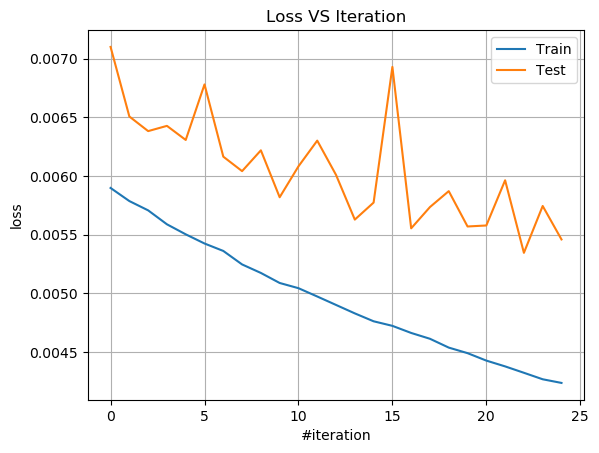

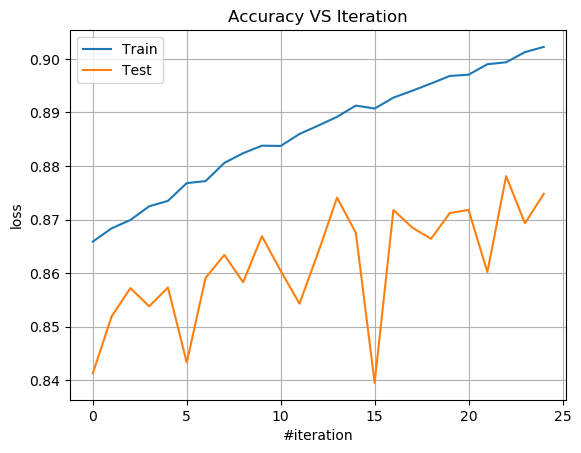

In [157]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

In [158]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.8748


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

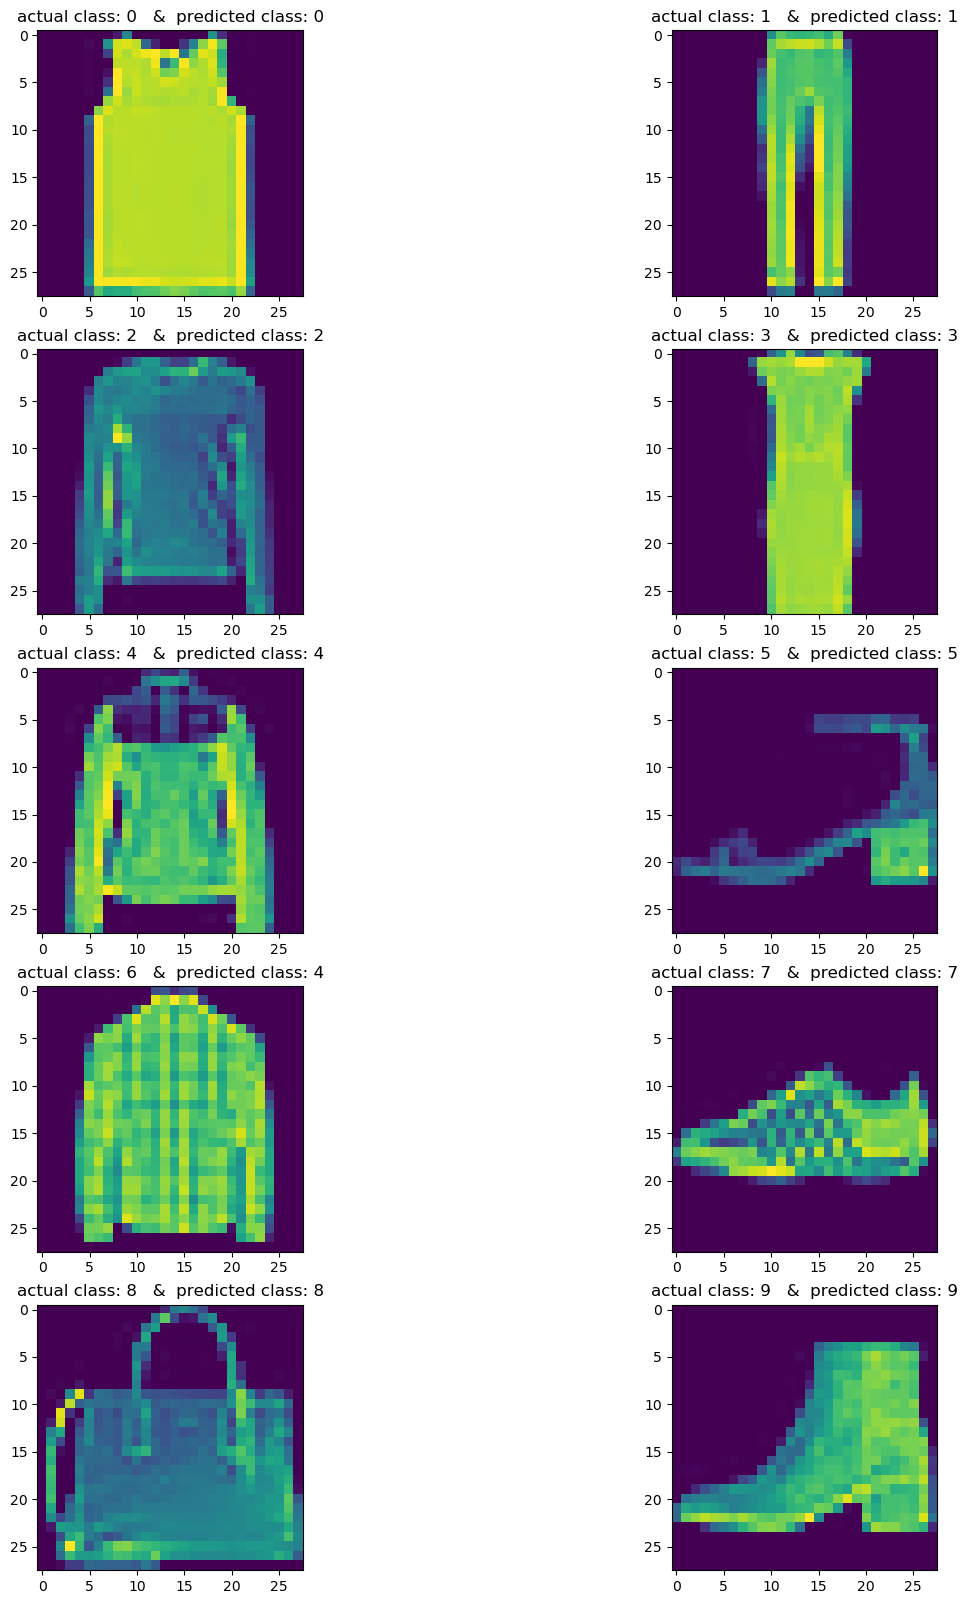

In [179]:
## FILL HERE
data = test_set.data
targets = test_set.targets
plt.figure(figsize=(15,20))
for i in range(num_classes):
    class_data = data[targets == i,:,:]
    random_idx = np.random.choice(class_data.shape[0],1)
    x = class_data[random_idx,:,:]
    x = x.type(torch.FloatTensor)
    x = x.to(device)
    
    p = model(x, parameters)
    y_pred = p.argmax(dim=-1)
    plt.subplot(5,2,i+1)
    plt.imshow(class_data[random_idx,:,:].reshape(class_data.shape[1],class_data.shape[2]))
    title = "actual class: "+str(i) + "   &  predicted class: "+ str(y_pred.item())
    plt.title(title)
